In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt





In [2]:


def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 自動建立資料夾



In [3]:
prefixs = [ "LoRA_Trigger", "noLoRA_Trigger", "training"]


In [4]:
def rename_files():
    base_path = "..\\data\\input"
    for p in prefixs:
        folder_path = os.path.join(base_path, p)
        ensure_folder_exists(folder_path)
        counter = 0
        for file_name in os.listdir(folder_path):
            print(file_name)
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(folder_path, p + "_" + str(counter) + ".png")
            os.rename(src, dst)
            counter += 1


In [ ]:
rename_files()

In [5]:
# read api from json file
api = {}
with open("anaysis with LoRA api.json", "r") as f:
    api = f.read()
api = json.loads(api)

trigger_prompt = " "
object_prompt = "a photo sks of chair in front of the TV"

In [6]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="sd_xl_base_1.0.safetensors",
    LoRA="greenchair_webui.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [7]:
print(config.short_object_prompt)

a photo sks of chair


In [8]:
import json
import requests
def send_request(api):
    # 3. 設定 API 的 URL 與 headers
    url = 'http://127.0.0.1:8188/prompt'
    headers = {'Content-Type': 'application/json'}

    # 4. 發送 POST request 並傳送修改後的 JSON 資料
    response = requests.post(url, headers=headers, data=json.dumps(api))

    # 5. 輸出回應結果
    print(response.status_code)
    print(response.json())

In [ ]:


def modify_api(api, config, counter = 0):
    api["prompt"]["3"]["inputs"]["ckpt_name"] = config.model
    api["prompt"]["2"]["inputs"]["lora_name"] = config.LoRA
    api["prompt"]["7"]["inputs"]["image"] = config.input_image
    api["prompt"]["4"]["inputs"]["text"] = config.trigger_prompt + config.object_prompt
    api["prompt"]["11"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}"
    api["prompt"]["15"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}@{counter}@"
    api["prompt"]["10"]["inputs"]["steps"] = config.total_steps
    api["prompt"]["10"]["inputs"]["denoise"] =  1-config.current_step/ config.total_steps
    api["prompt"]["1"]["inputs"]["start_at_step"] = config.current_step
    api["prompt"]["1"]["inputs"]["end_at_step"] = config.current_step + 1
    return api

In [ ]:
import shutil
output_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [ ]:
import shutil


generate_counter = 1

for prefix in prefixs:
    config.file_prefix = prefix
    # object_prompt = "a cute rat"
    # config.object_prompt = object_prompt
    for input_image in os.listdir(f"..\\..\\..\\myComfyUI\\input"):
        if prefix not in input_image:
            continue
        print(f"{prefix} {object_prompt} {input_image}")
        config.set_input_image(input_image)
        config.current_step = 0
        for i in range(20-1):
            config.current_step = i
            api = modify_api(api, config, generate_counter)
            generate_counter += 1
            send_request(api)
            print(f"{prefix} {object_prompt} {i} done")

In [9]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"


In [ ]:

for prefix in os.listdir(data_folder):
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                
                if '@' in file_name:
                    index = file_name.split('@')[1]
                    print(index)
                    hspace_file = os.path.join(hspace_folder, index+".pkl")
                    destination = os.path.join(data_folder, prefix, prompt, image_name)
                    # if hspace file exist
                    if os.path.exists(hspace_file):
                        shutil.move(hspace_file, destination)
                    else:
                        print(f"{hspace_file} not exist")




        


In [7]:
class read_file():
    def __init__(self, file_path):
        pass

    def load_hspace_file(filepath):
        """讀取 .pkl 檔案，並將 numpy.ndarray 轉換為 numpy array"""
        with open(filepath, 'rb') as f:
            arr = pickle.load(f)
        return arr

    def load_latent_file(filepath):
        """利用 safetensors.torch 讀取 .latent 檔案，並取出 'latent_tensor'"""
        sd = safetensors.torch.load_file(filepath)
        return sd['latent_tensor'].numpy()

    def load_image_file(filepath):
        """讀取圖片檔案，並轉換為 numpy array"""
        img = PIL.Image.open(filepath)
        return np.array(img)


In [ ]:
experiment_data = {}
for prefix in os.listdir(data_folder):
    experiment_data[prefix] = {}
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        experiment_data[prefix][prompt] = {}
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            experiment_data[prefix][prompt][image_name] = {}
            experiment_data[prefix][prompt][image_name]["hspace"] = []
            experiment_data[prefix][prompt][image_name]["image"] = []
            experiment_data[prefix][prompt][image_name]["latent"] = []

            start_index = 9999999999
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                if '@' in file_name:
                    print(file_name)
                    index = int(file_name.split('@')[1])
                    start_index = min(start_index, index)
            
            
            for i in range(20-1):
                hspace_file = os.path.join(data_folder, prefix, prompt, image_name, f"{start_index+i}.pkl")
                image_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}@{start_index+i}@_00001_.png")
                latent_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}_00001_.latent")

                if os.path.exists(hspace_file) and os.path.exists(image_file) and os.path.exists(latent_file):
                    experiment_data[prefix][prompt][image_name]["hspace"].append(read_file.load_hspace_file(hspace_file))
                    experiment_data[prefix][prompt][image_name]["image"].append(read_file.load_image_file(image_file))
                    experiment_data[prefix][prompt][image_name]["latent"].append(read_file.load_latent_file(latent_file))
                else:
                    if not os.path.exists(hspace_file):
                        print(f"{hspace_file} not exist")
                    if not os.path.exists(image_file):
                        print(f"{image_file} not exist")
                    if not os.path.exists(latent_file):
                        print(f"{latent_file} not exist")




In [ ]:
# turn experiment_data into numpy array
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        for image_name in experiment_data[prefix][prompt]:
            experiment_data[prefix][prompt][image_name]["hspace"] = np.array(experiment_data[prefix][prompt][image_name]["hspace"])
            experiment_data[prefix][prompt][image_name]["image"] = np.array(experiment_data[prefix][prompt][image_name]["image"])
            experiment_data[prefix][prompt][image_name]["latent"] = np.array(experiment_data[prefix][prompt][image_name]["latent"])

In [ ]:
print(experiment_data.keys())
print(experiment_data['LoRA_Trigger'].keys())
print(experiment_data['LoRA_Trigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png'].keys())
print(len(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace']))
print(len(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['image']))
print(len(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['latent']))

In [ ]:
# save experiment data
with open('experiment_data.pkl', 'wb') as f:
    pickle.dump(experiment_data, f)

In [10]:
# load experiment data
experiment_data = {}
with open('experiment_data.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    

In [9]:
# replace last image data with random data
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        last_image_name = list(experiment_data[prefix][prompt].keys())[-1]
        print(experiment_data[prefix][prompt][last_image_name]["image"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["latent"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["hspace"].shape)
        print("*"*10)
        # as random data
        experiment_data[prefix][prompt][last_image_name]["image"] = np.random.rand(19, 512, 512, 3)
        experiment_data[prefix][prompt][last_image_name]["latent"] = np.random.rand(19, 1, 4, 64, 64)
        experiment_data[prefix][prompt][last_image_name]["hspace"] = np.random.rand(19, 2, 1280, 8, 8)

        second_last_image_name = list(experiment_data[prefix][prompt].keys())[-2]
        # as zero data
        experiment_data[prefix][prompt][second_last_image_name]["image"] = np.zeros((19, 512, 512, 3))
        experiment_data[prefix][prompt][second_last_image_name]["latent"] = np.zeros((19, 1, 4, 64, 64))
        experiment_data[prefix][prompt][second_last_image_name]["hspace"] = np.zeros((19, 2, 1280, 8, 8))


(19, 1024, 1024, 3)
(19, 1, 4, 128, 128)
(19, 2, 1280, 32, 32)
**********
(19, 1024, 1024, 3)
(19, 1, 4, 128, 128)
(19, 2, 1280, 32, 32)
**********
(19, 1024, 1024, 3)
(19, 1, 4, 128, 128)
(19, 2, 1280, 32, 32)
**********


In [11]:
import numpy as np

def compute_global_stats(experiment_data):
    """
    計算三個 key 的全域 mean 與 var，
    回傳格式：{ 'latent': {'mean':…, 'var':…}, … }
    """
    stats = {}
    keys = ["latent", "image", "hspace"]
    for key in keys:
        flat = []
        print(f"Processing key: {key}")
        for prompts in experiment_data.values():
            for images in prompts.values():
                for fields in images.values():
                    # 檢查資料是否包含 NaN 或 Inf
                    invalid_mask = np.isnan(fields[key]) | np.isinf(fields[key])
                    if np.any(invalid_mask):
                        print(f"Filtered invalid data for key '{key}': {fields[key][invalid_mask]}")
                    
                    # 過濾掉無效數據（如 NaN 或 Inf）
                    valid_data = fields[key][~invalid_mask]
                    if valid_data.size > 0:
                        # 限制數值範圍，避免極端值
                        valid_data = np.clip(valid_data, -1e6, 1e6)
                        flat.append(valid_data.flatten())
                    else:
                        print(f"Warning: No valid data for key '{key}' in current fields.")
        if flat:
            concat = np.concatenate(flat)
            stats[key] = {
                "mean": concat.mean(),
                "var": concat.var(ddof=0)
            }
            # 檢查是否出現 inf，若出現則設為 0
            if np.isinf(stats[key]["var"]):
                print(f"Warning: Variance for key '{key}' is inf. Setting variance to 0.")
                stats[key]["var"] = 0
            print(f"Key: {key}, Mean: {stats[key]['mean']}, Variance: {stats[key]['var']}")
        else:
            stats[key] = {
                "mean": 0,
                "var": 0
            }
            print(f"Warning: No data found for key '{key}'. Setting mean and variance to 0.")
    return stats

def normalize_experiment_data_zscore(experiment_data):
    """
    用 compute_global_stats 回傳的 mean/var，
    對每張圖的三個 key 做 Z-Score 標準化。
    """
    stats = compute_global_stats(experiment_data)
    print(stats)
    normalized = {}

    for prefix, prompts in experiment_data.items():
        normalized[prefix] = {}
        for prompt, images in prompts.items():
            normalized[prefix][prompt] = {}
            for image_name, fields in images.items():
                normalized[prefix][prompt][image_name] = {}
                for key, arr in fields.items():
                    mu = stats[key]["mean"]
                    var = stats[key]["var"]
                    if var > 0:
                        # 避免溢位，限制數值範圍
                        zscore = (arr - mu) / np.sqrt(var)
                        zscore = np.clip(zscore, -1e6, 1e6)  # 限制範圍避免極端值
                        normalized[prefix][prompt][image_name][key] = zscore
                    else:
                        # 若 var=0（所有值相同），僅去中心化
                        normalized[prefix][prompt][image_name][key] = arr - mu
                        print(f"Warning: {prefix} {prompt} {image_name} {key} has zero variance, only centering applied.")
    return normalized

# 使用修正後的 normalize 函式
experiment_data = normalize_experiment_data_zscore(experiment_data)

Processing key: latent
Key: latent, Mean: 0.2645825147628784, Variance: 1995.36279296875
Processing key: image
Key: image, Mean: 117.97743009134507, Variance: 9003.508636551536
Processing key: hspace
Key: hspace, Mean: 0.03043588250875473, Variance: 28.488933563232422
{'latent': {'mean': 0.2645825, 'var': 1995.3628}, 'image': {'mean': 117.97743009134507, 'var': 9003.508636551536}, 'hspace': {'mean': 0.030435883, 'var': 28.488934}}


In [12]:
print(experiment_data.keys())
print(experiment_data['LoRA_Trigger'].keys())
print(experiment_data['LoRA_Trigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png'].keys())
print(len(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace']))
print(len(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['image']))
print(len(experiment_data['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['latent']))

dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])
dict_keys(['a photo sks of chair'])
dict_keys(['LoRA_Trigger_0.png', 'LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])
dict_keys(['hspace', 'image', 'latent'])
19
19
19


In [13]:
import numpy as np

def euclidean(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.any(np.isnan(p1)) or np.any(np.isnan(p2)) or np.any(np.isinf(p1)) or np.any(np.isinf(p2)):
        print("Invalid input detected:", p1, p2)
        return float('inf')
    return np.linalg.norm(p1 - p2)


def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [14]:
# see as different step

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            for image_name in experiment_data[prefix][prompt].keys():
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                avg_data = {"latent": None, "image": None, "hspace": None}

                # Calculate the average for each key
                for key in ["hspace", "latent", "image"]:
                    all_steps = [
                        experiment_data[prefix][prompt][img_name][key]
                        for img_name in experiment_data[prefix][prompt].keys()
                        if experiment_data[prefix][prompt][img_name][key].shape == experiment_data[prefix][prompt][image_name][key].shape
                    ]
                    if all_steps:
                        avg_data[key] = np.mean(np.array(all_steps), axis=0)+0.000001
                    else:
                        avg_data[key] = None


                # Calculate the Euclidean distance from the average
                for key in ["latent", "image", "hspace"]:
                    if avg_data[key] is not None:
                        for i in range(0, 20 - 1):

                            distance = euclidean(
                                experiment_data[prefix][prompt][image_name][key][i],
                                avg_data[key][i]
                            )
                            anaysis_data[prefix][prompt][image_name][key].append(distance)

    return anaysis_data
anaysis_data = {"L2_step": {}, "frechet_step": {}, "L1_step": {}}
anaysis_data["L2_step"] = calculate_euclidean_distance(experiment_data)

In [15]:
print(anaysis_data["L2_step"].keys())
print(anaysis_data["L2_step"]['LoRA_Trigger'].keys())
print(anaysis_data["L2_step"]['LoRA_Trigger'][config.short_object_prompt].keys())
print(anaysis_data["L2_step"]['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_1.png'].keys())
print(len(anaysis_data["L2_step"]['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_1.png']['hspace']))
print(len(anaysis_data["L2_step"]['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_1.png']['image']))
print(len(anaysis_data["L2_step"]['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_1.png']['latent']))



dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])
dict_keys(['a photo sks of chair'])
dict_keys(['LoRA_Trigger_0.png', 'LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])
dict_keys(['latent', 'image', 'hspace'])
19
19
19


In [16]:
# anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['latent']
anaysis_data["L2_step"]['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_1.png']['hspace']

[167.9242,
 246.75069,
 335.67105,
 413.6036,
 554.2137,
 590.3409,
 664.9654,
 716.1171,
 787.9167,
 857.9748,
 919.893,
 963.31323,
 1033.9733,
 1120.4349,
 1194.1722,
 1258.4567,
 1308.2844,
 1347.4663,
 1356.4766]

Processing prefix: LoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


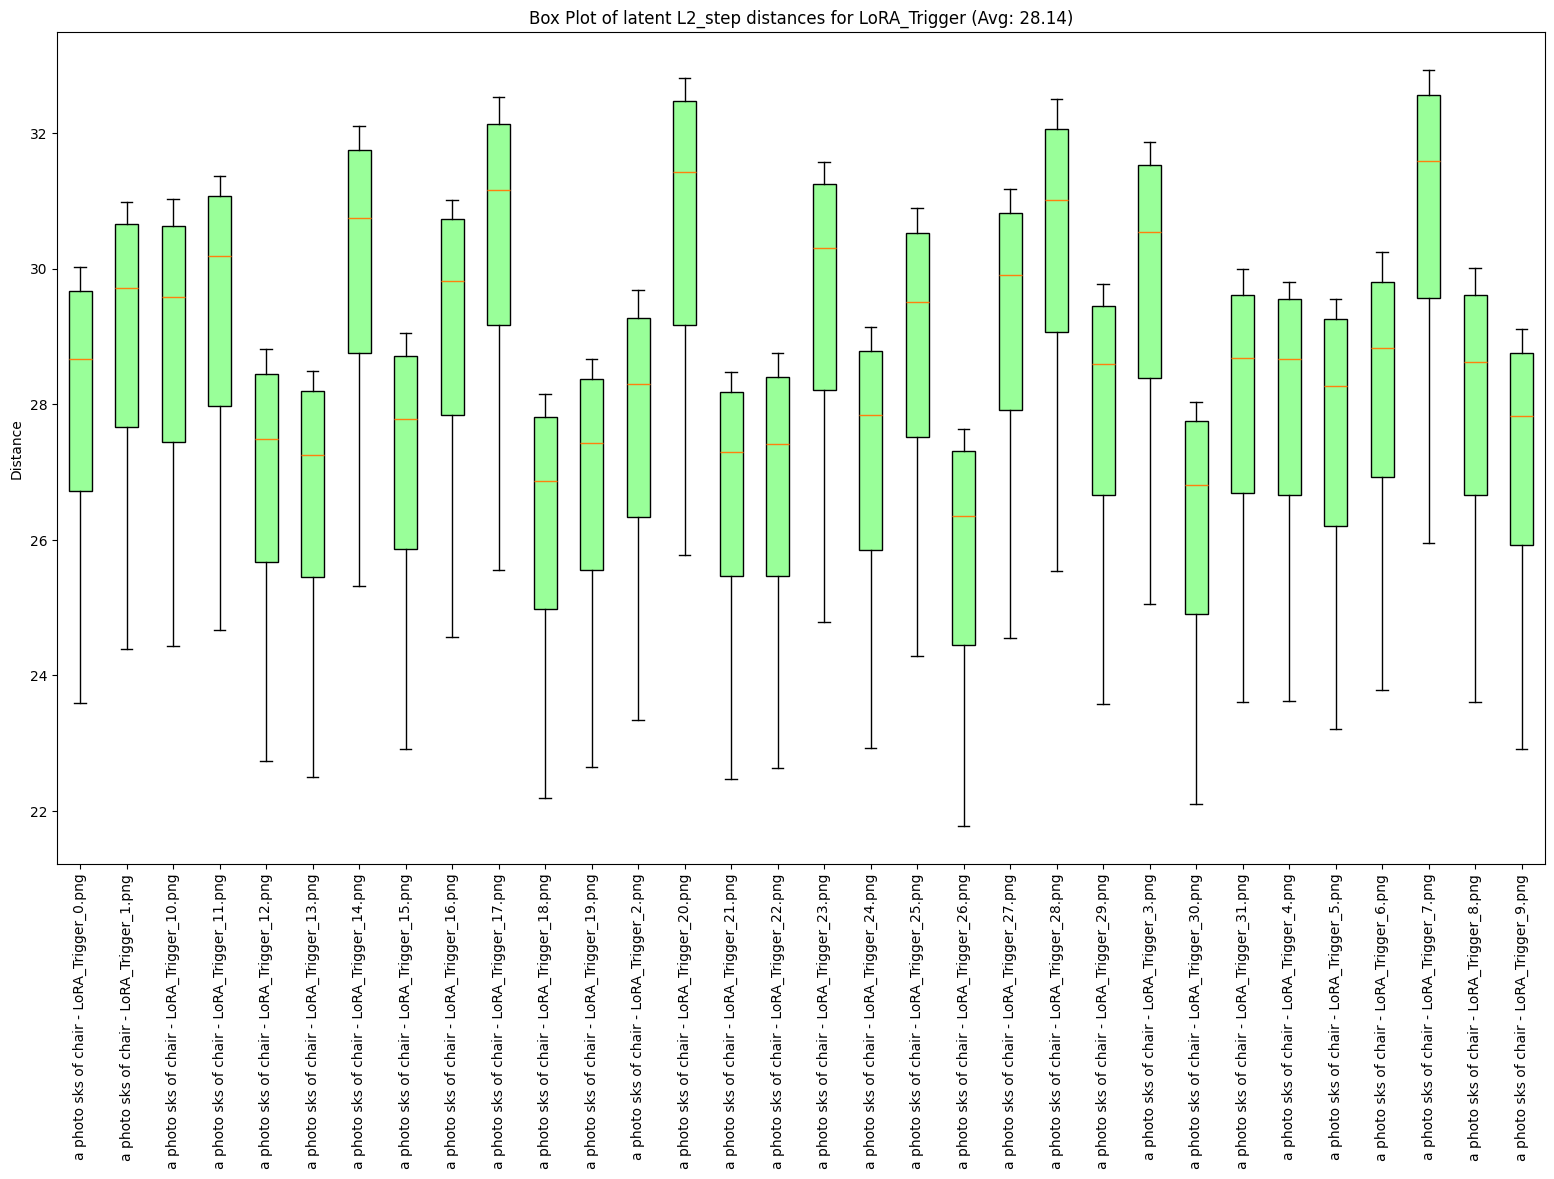

Processing prefix: noLoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


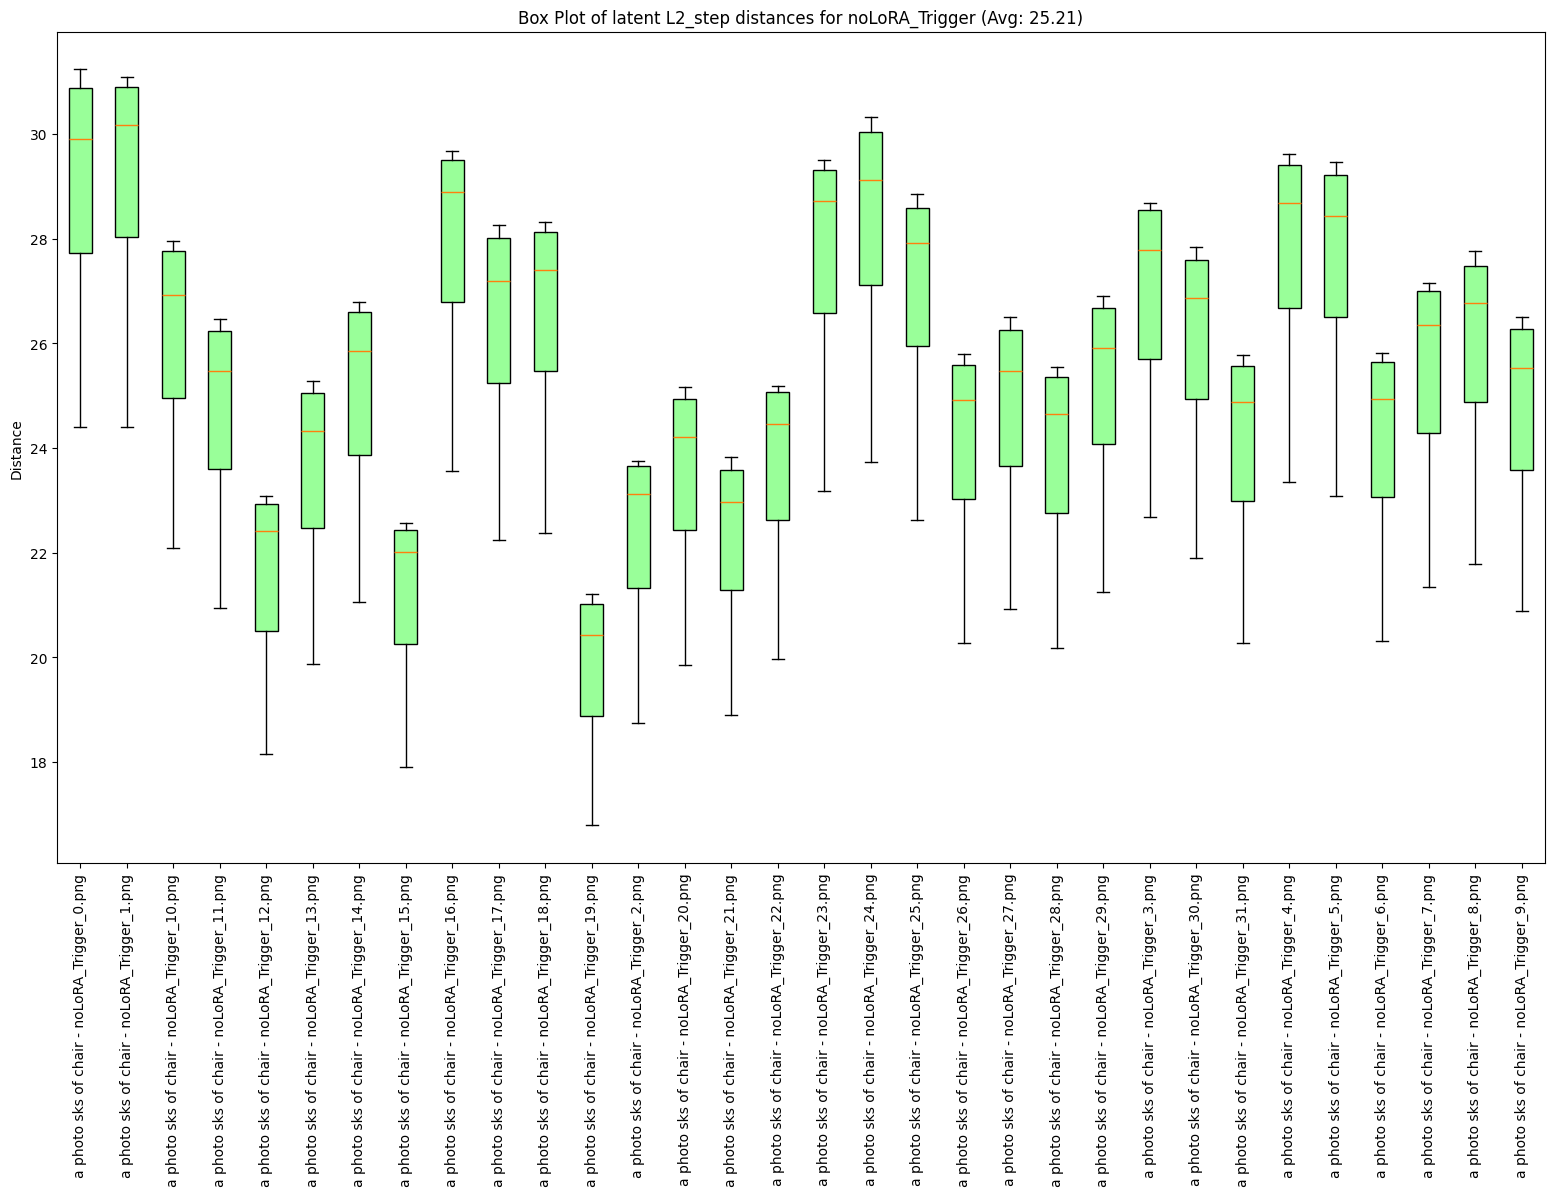

Processing prefix: training
Number of boxes: 25, Number of labels: 25


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


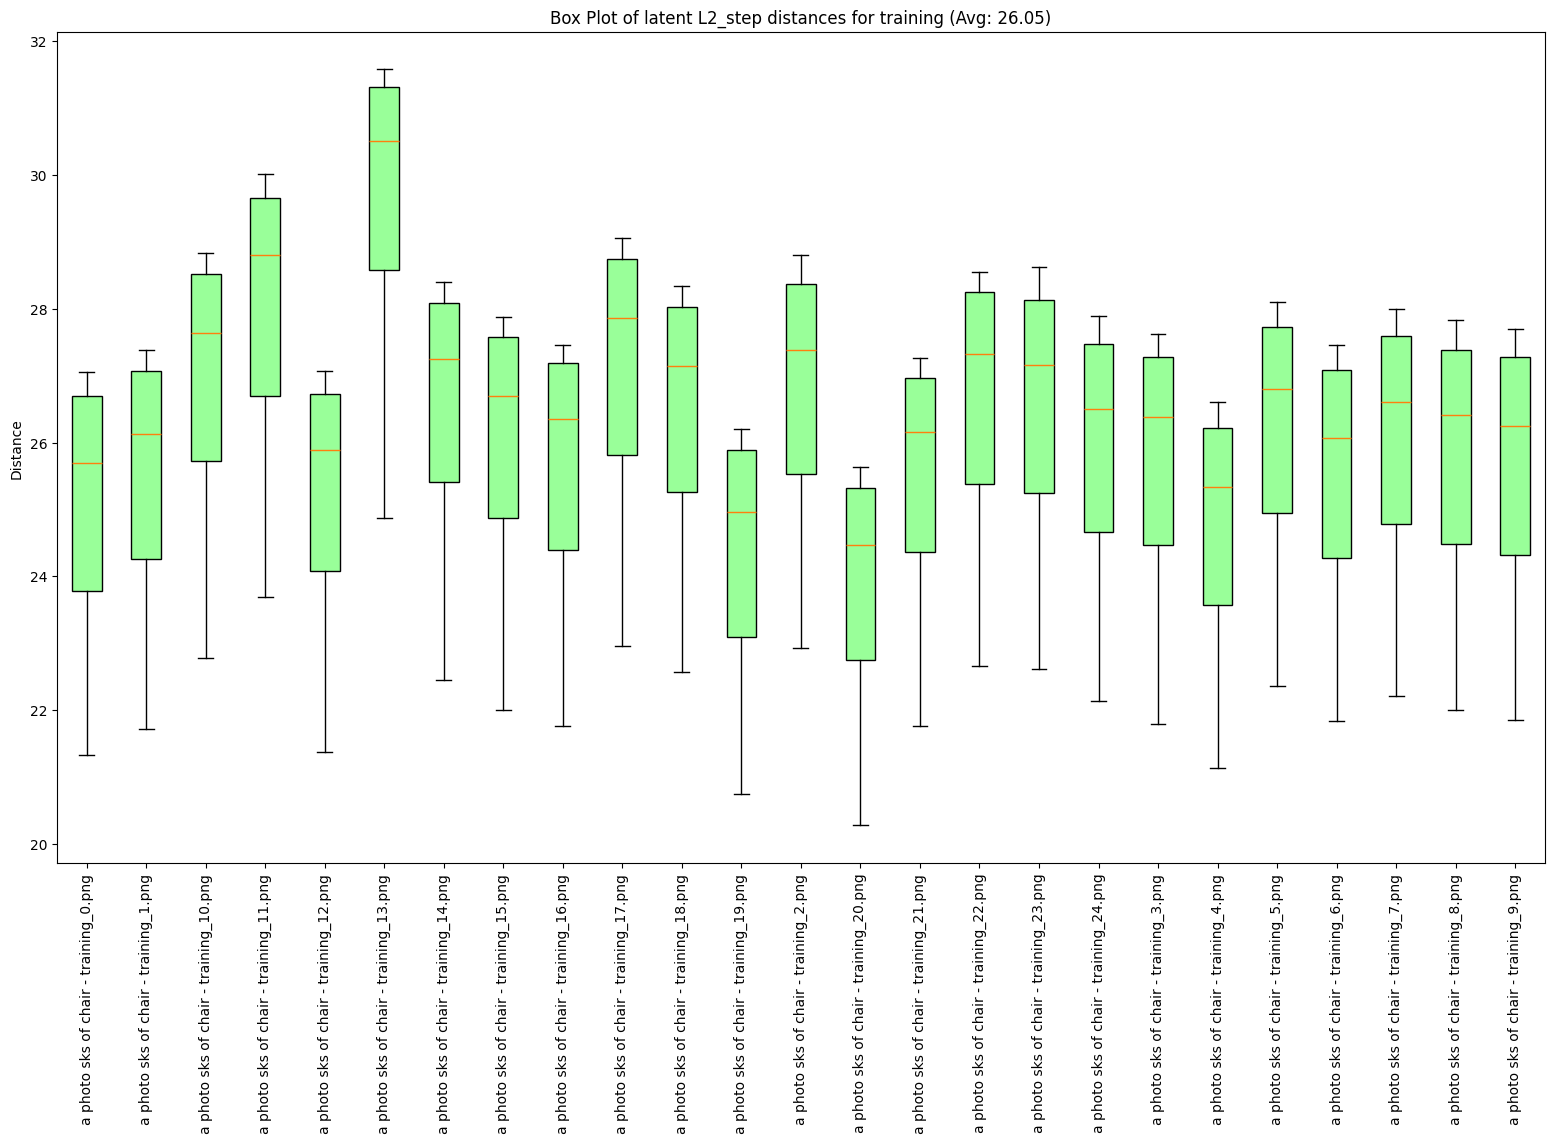

C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


Processing prefix: LoRA_Trigger
Number of boxes: 32, Number of labels: 32


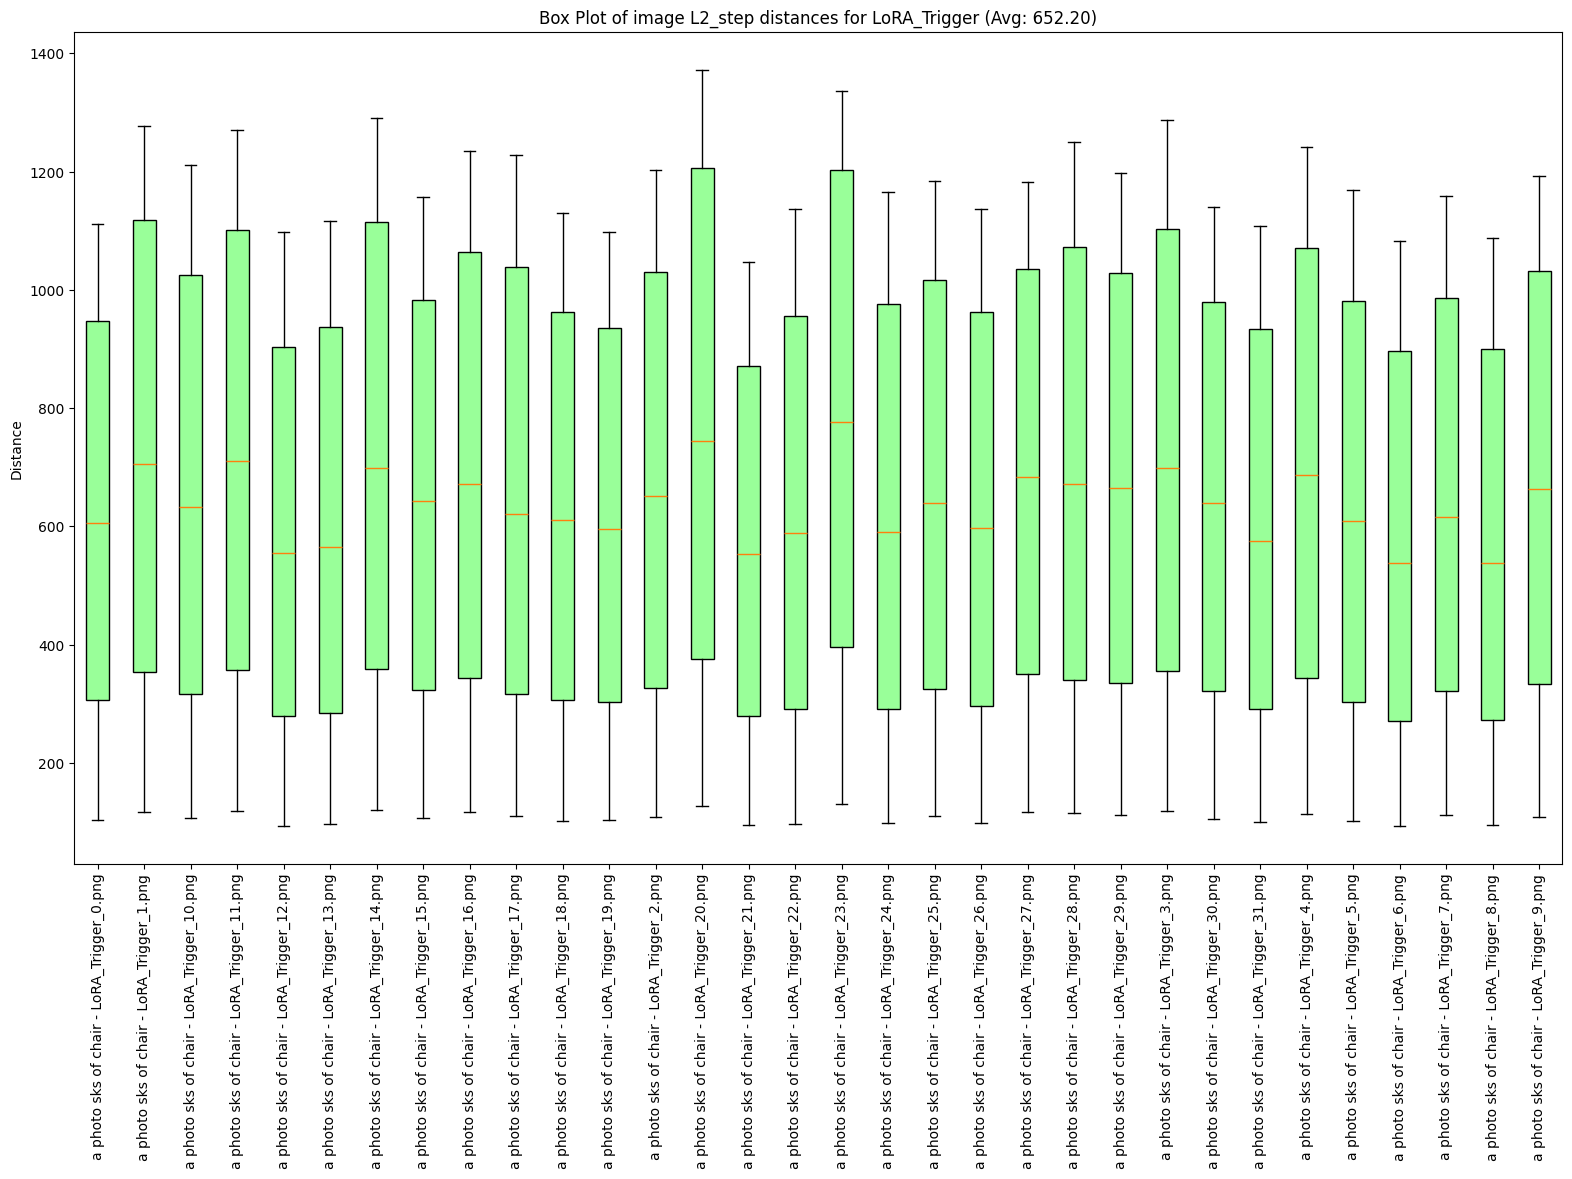

Processing prefix: noLoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


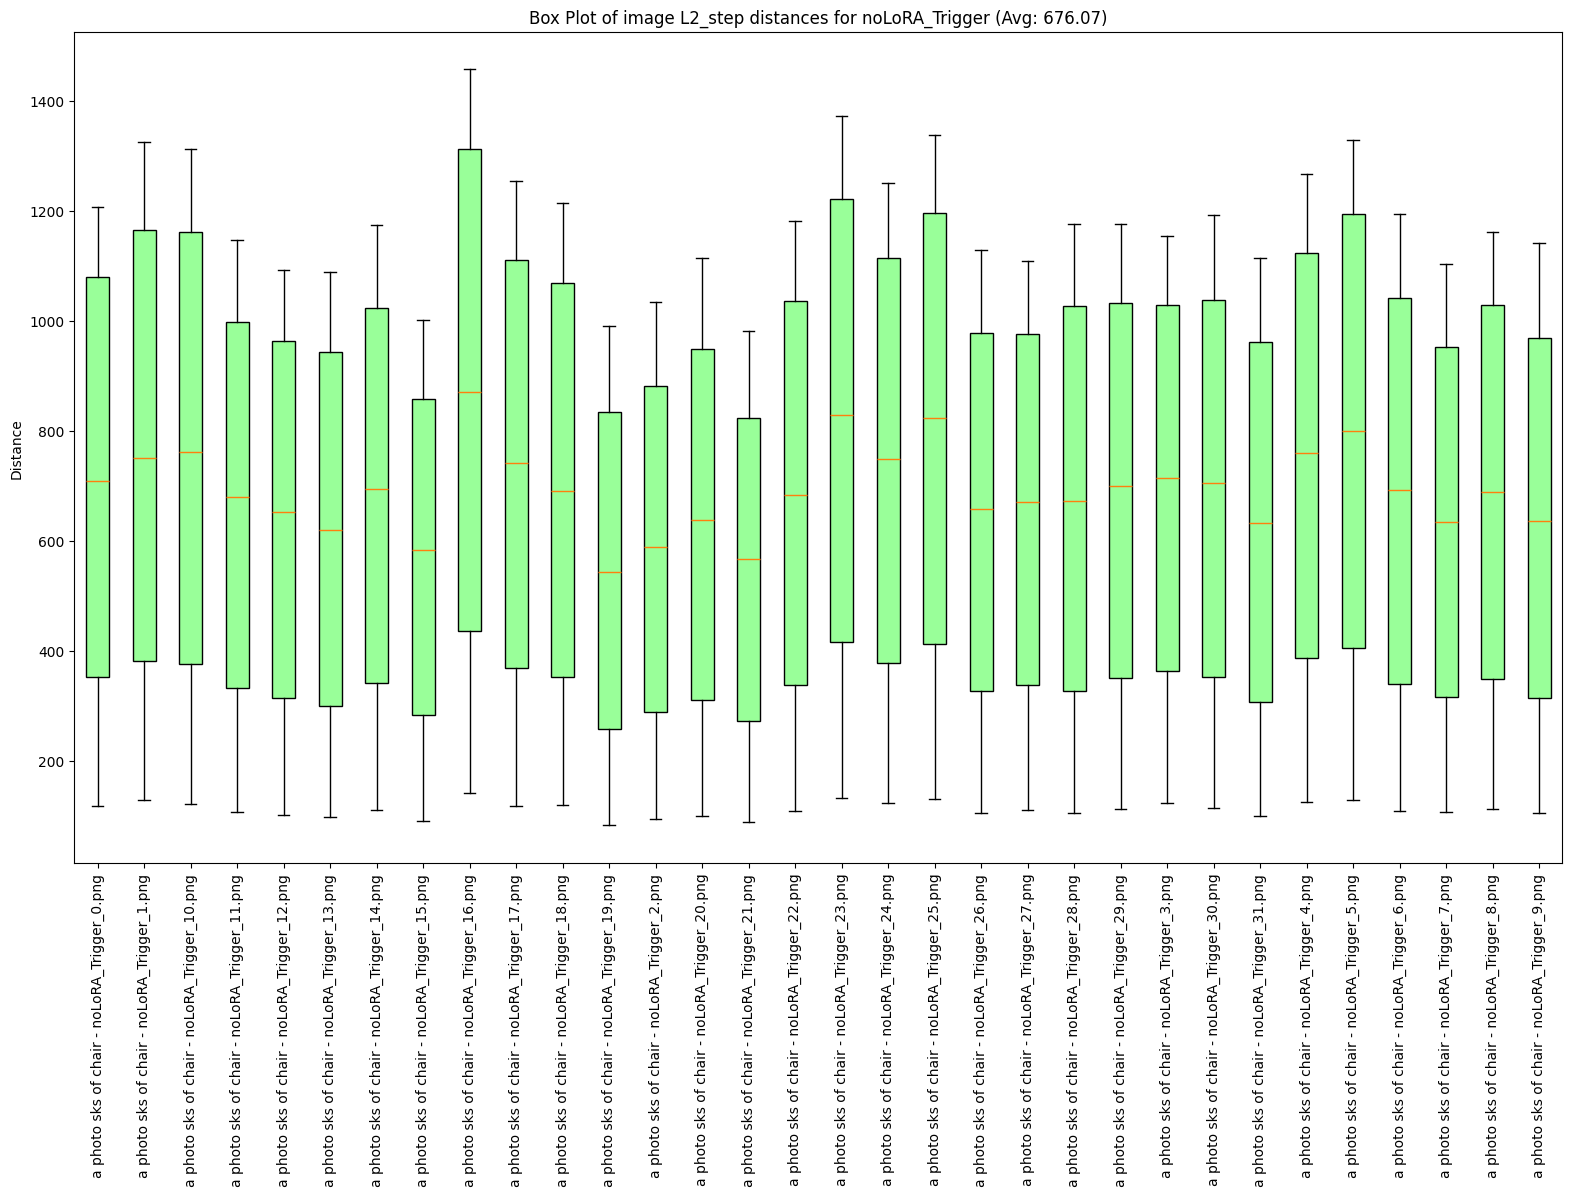

Processing prefix: training
Number of boxes: 25, Number of labels: 25


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


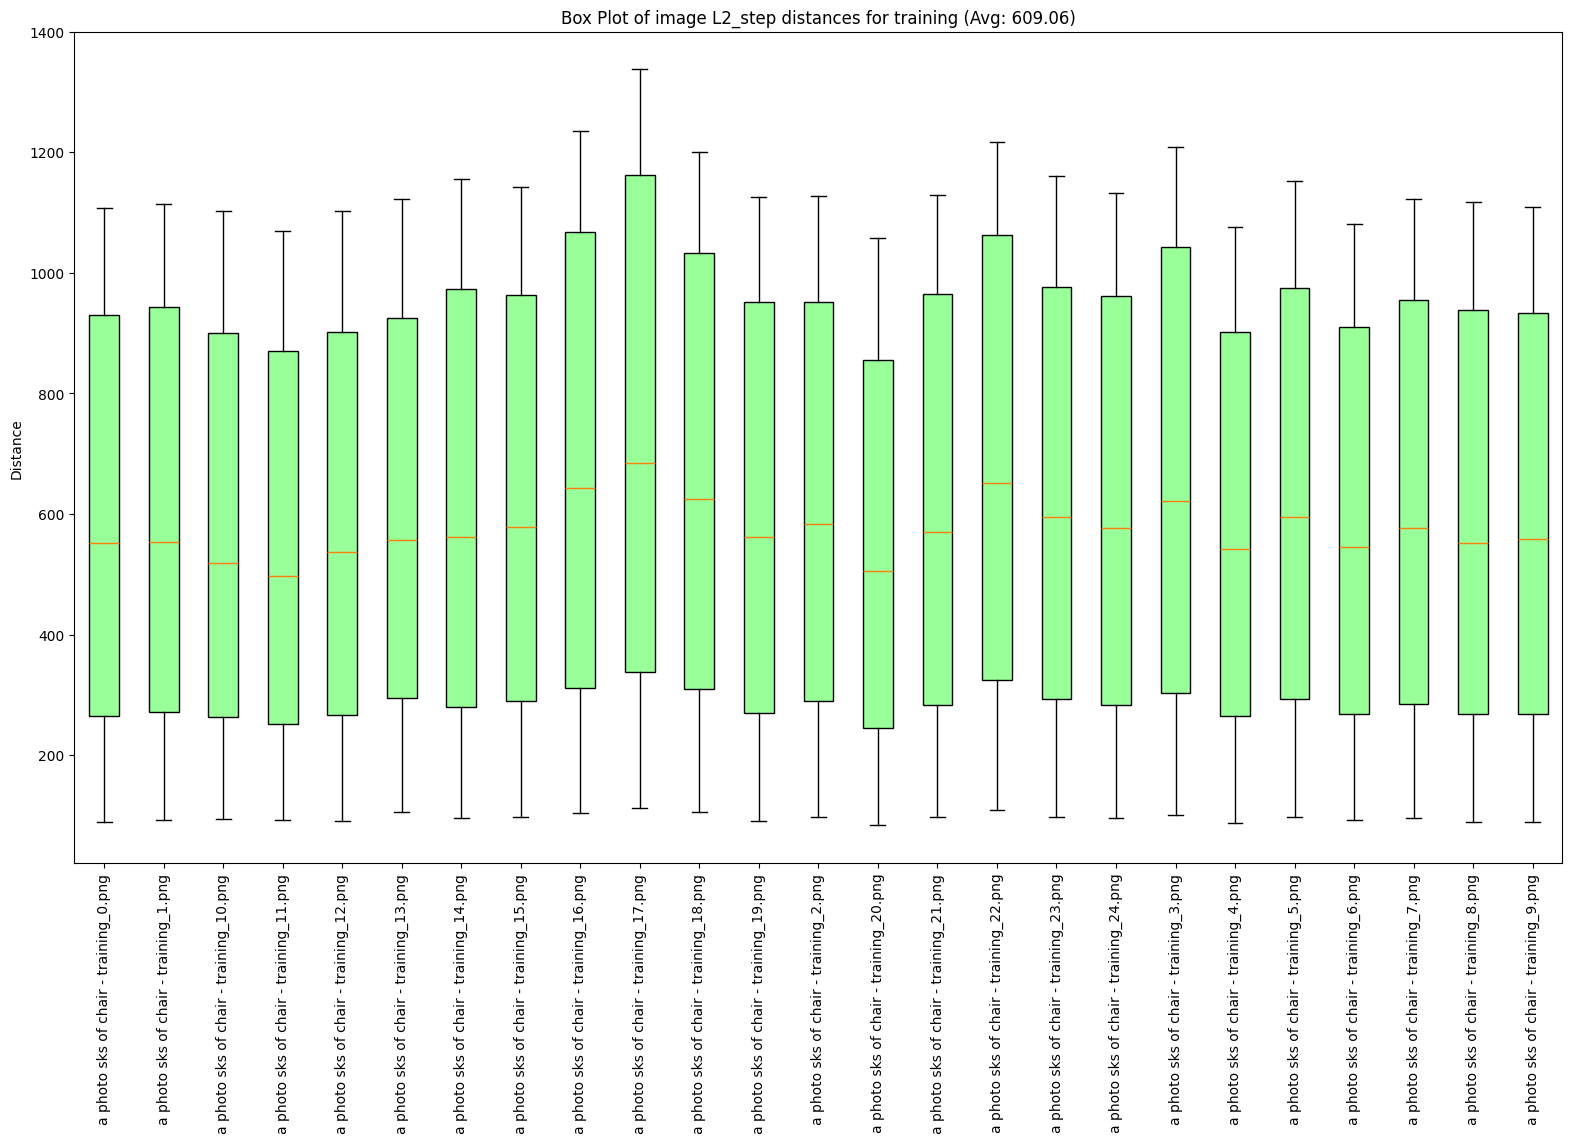

Processing prefix: LoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


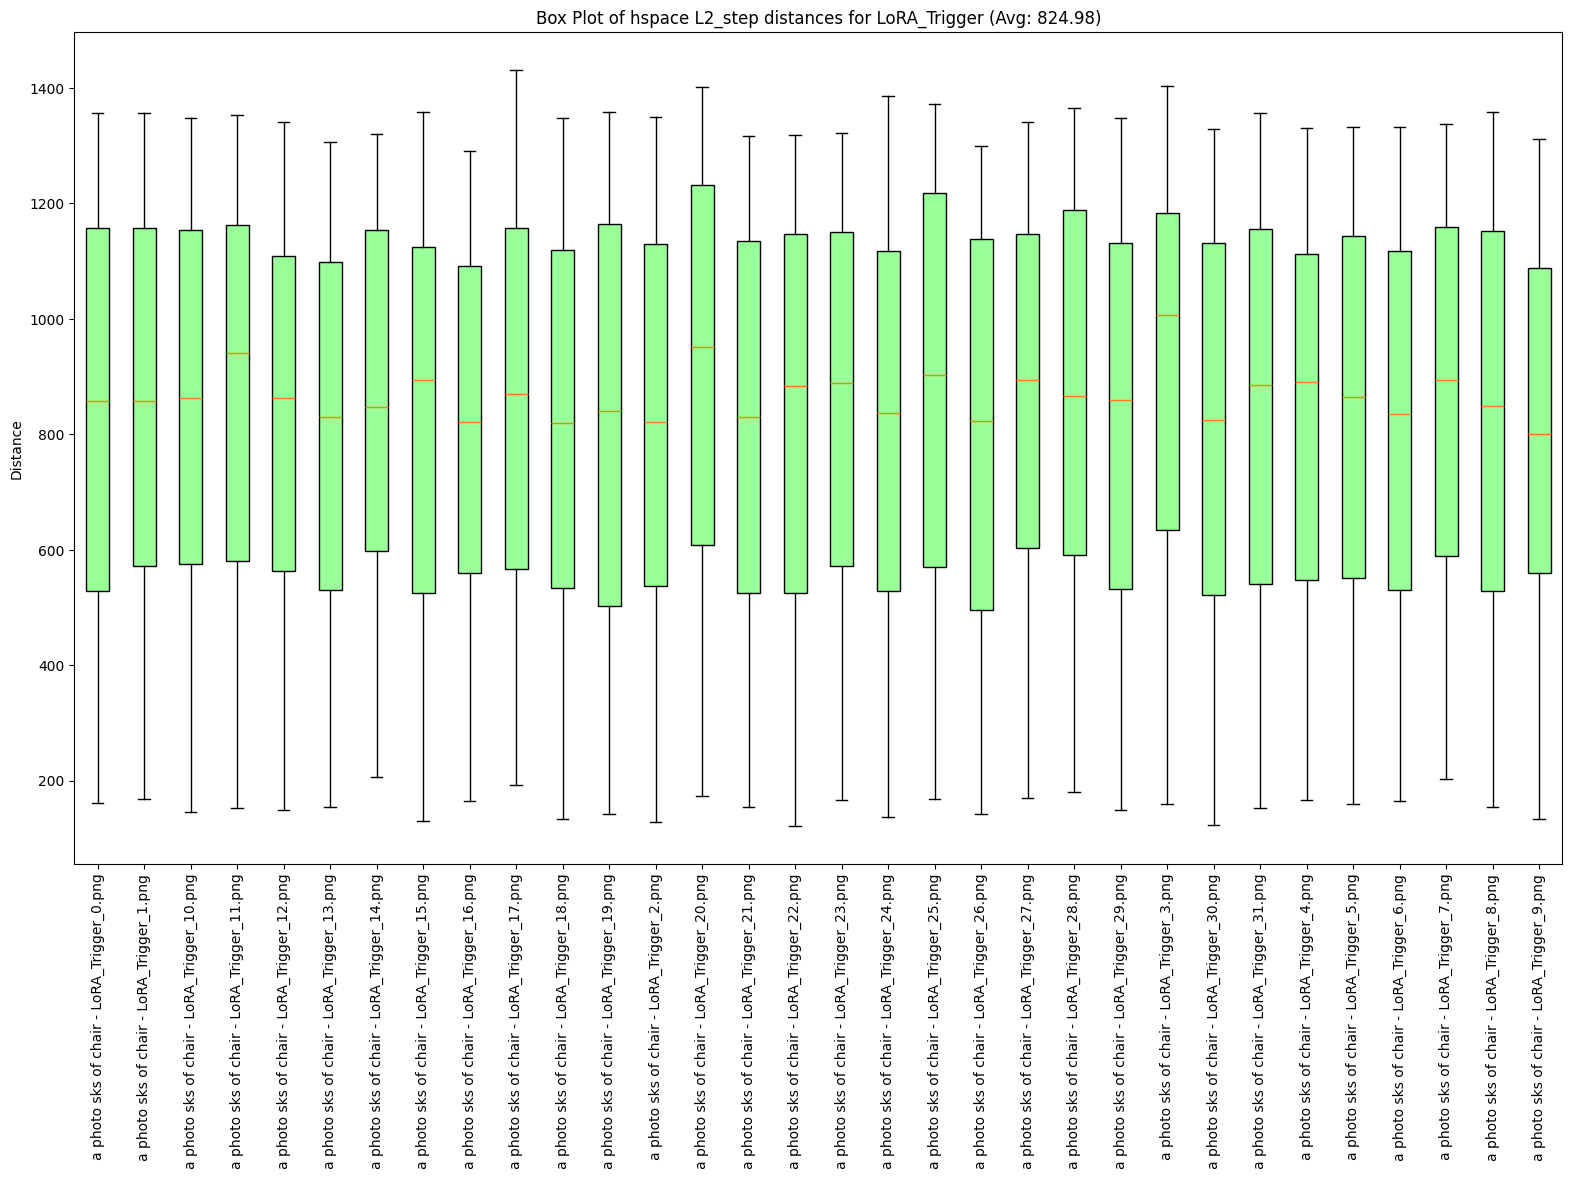

Processing prefix: noLoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


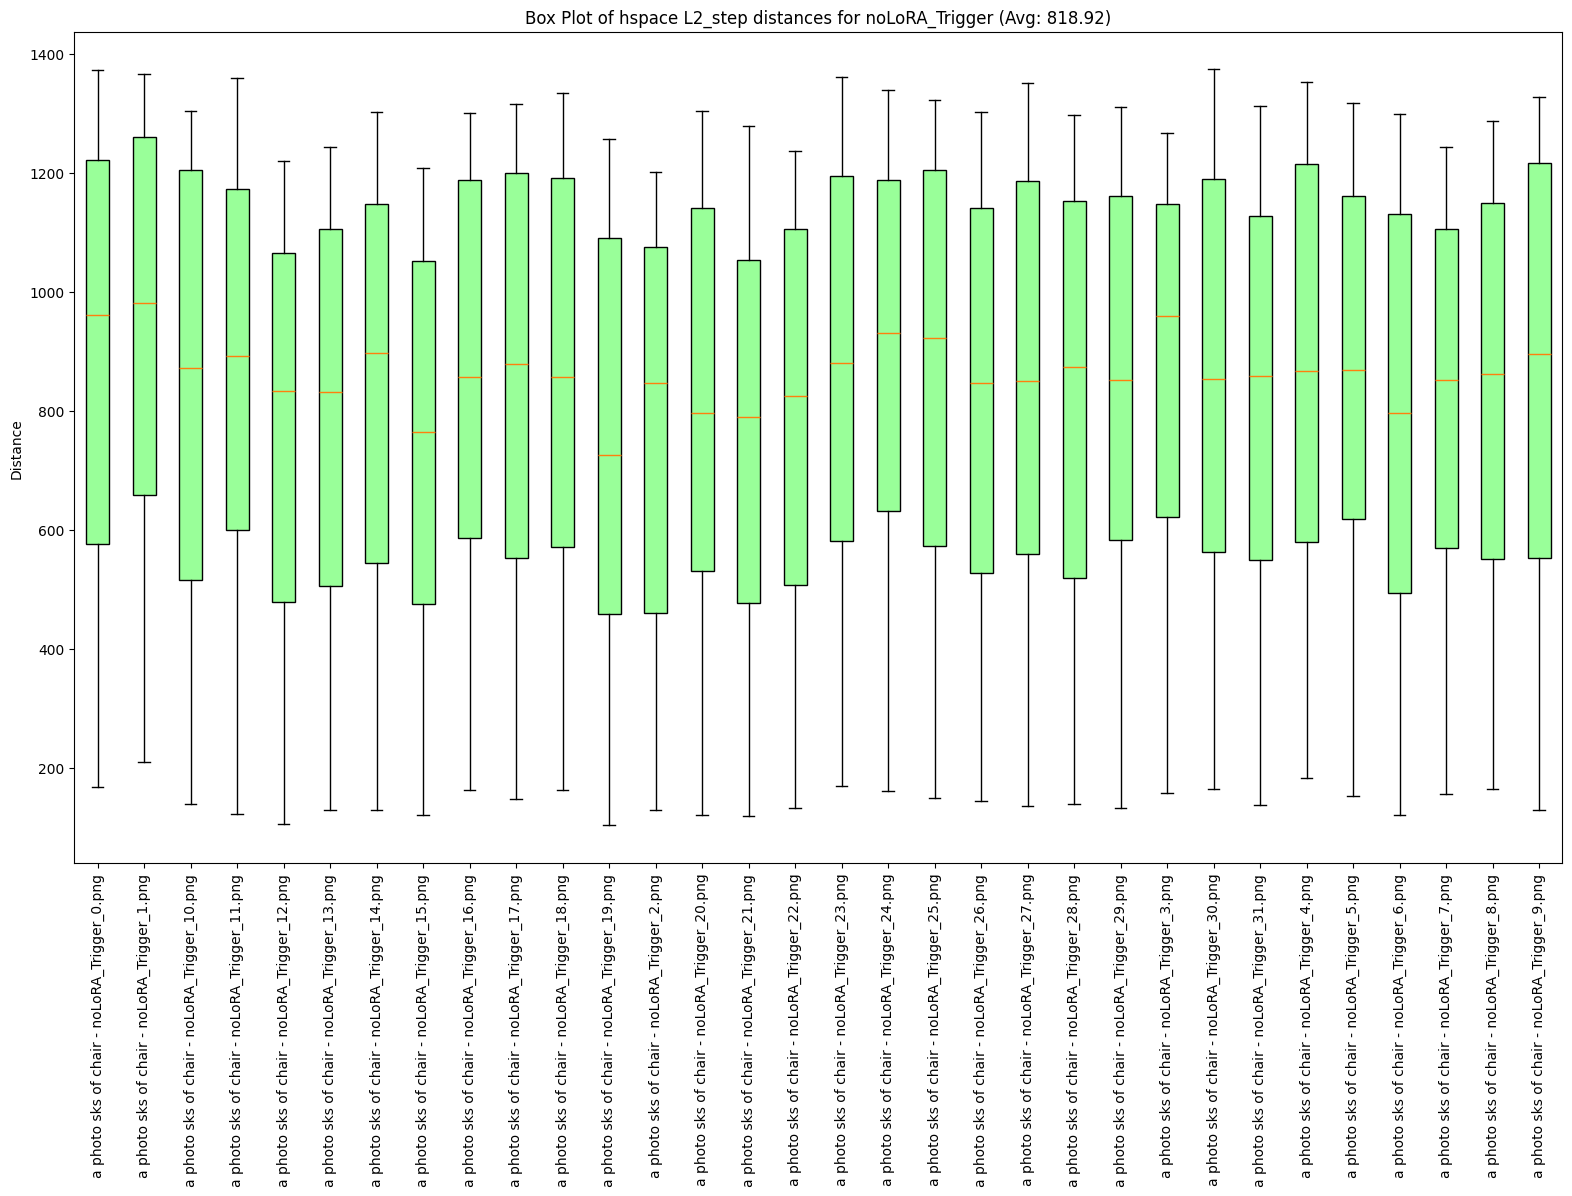

Processing prefix: training
Number of boxes: 25, Number of labels: 25


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


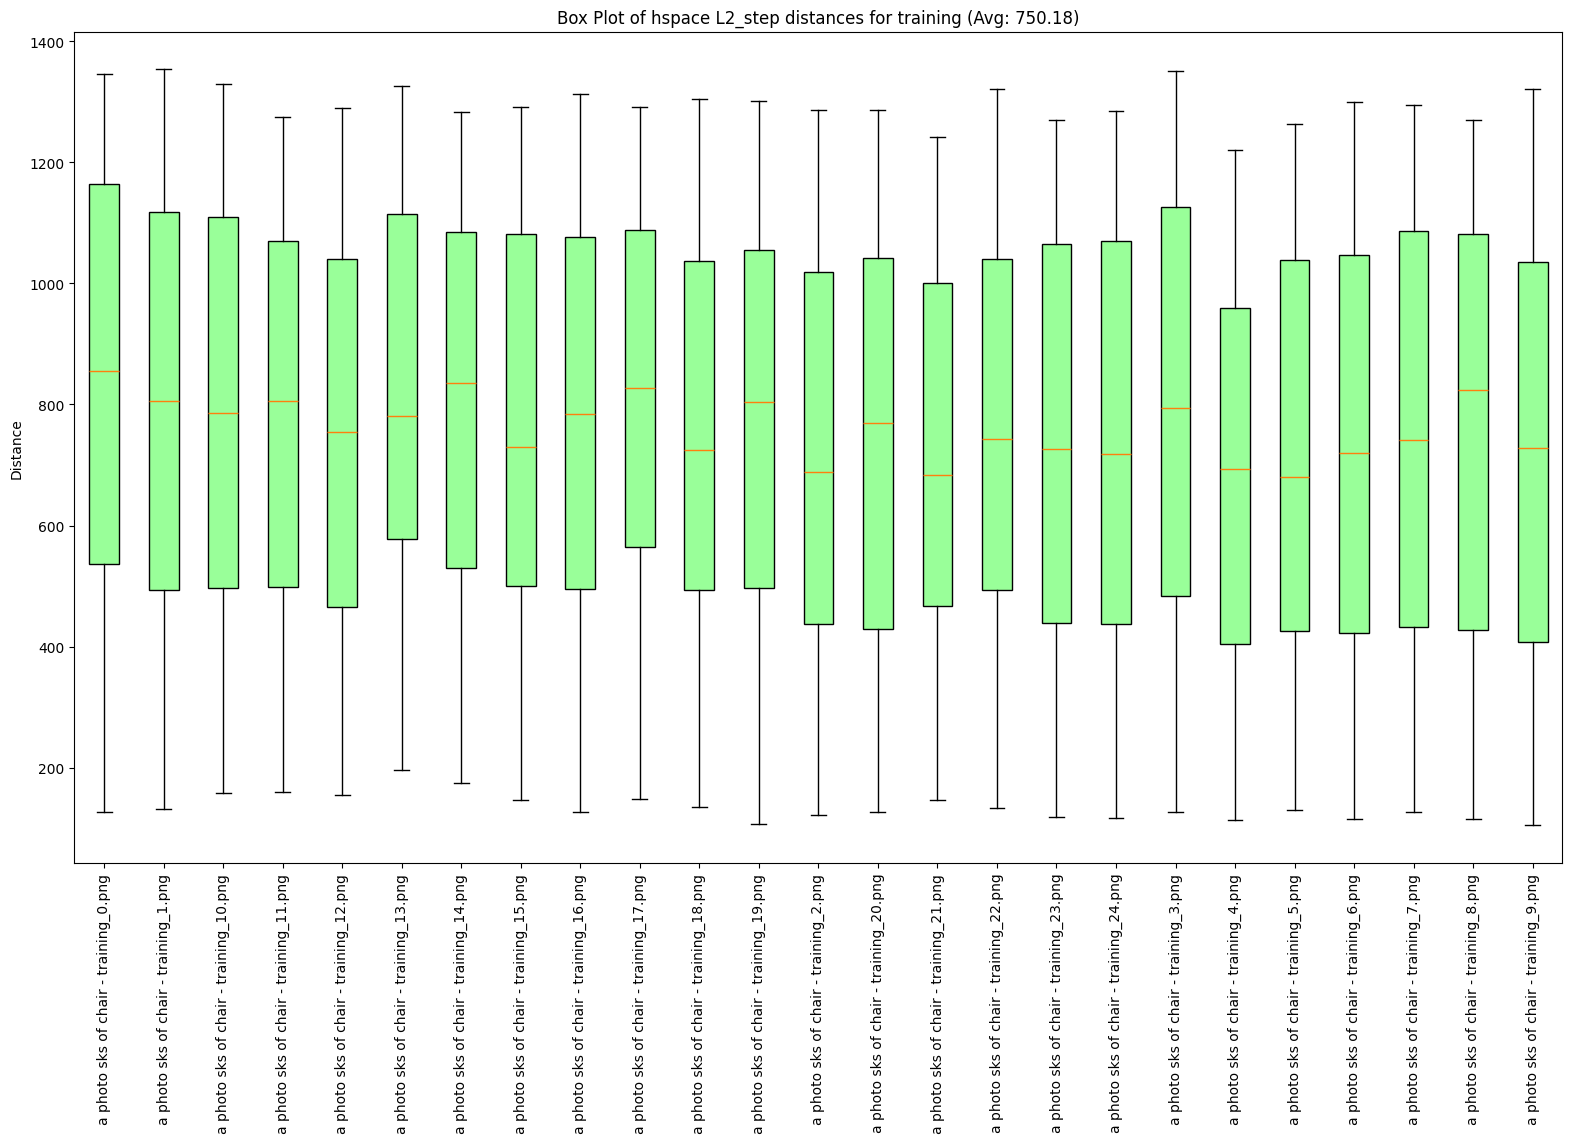

In [17]:
import numpy as np
import matplotlib.pyplot as plt
def plot_boxplot(anaysis_data, key, distance_type="L2_step"):
    color = {'L2_step': '#99FF99', 'frechet_step': '#99CCFF', 'L1_step': '#FF9999', 'cosine_similarity': '#55AAFF'}[distance_type]
    
    for prefix in anaysis_data.keys():
        data_to_plot = []
        labels = []
        
        # Print debug information
        print(f"Processing prefix: {prefix}")
        
        for prompt in anaysis_data[prefix].keys():
            for image_name in anaysis_data[prefix][prompt].keys():
                try:
                    data = anaysis_data[prefix][prompt][image_name][key]
                    # Only add non-empty data
                    if isinstance(data, list) and len(data) > 0:
                        data_to_plot.append(data)
                        labels.append(f'{prompt} - {image_name}')
                except Exception as e:
                    print(f"Error processing {prefix}/{prompt}/{image_name}/{key}: {e}")
        
        # Skip if no valid data
        if not data_to_plot:
            print(f"No valid data to plot for {prefix}/{key}")
            continue
            
        print(f"Number of boxes: {len(data_to_plot)}, Number of labels: {len(labels)}")
        
        # Double-check that dimensions match before plotting
        if len(data_to_plot) != len(labels):
            print(f"Warning: Mismatch between data_to_plot ({len(data_to_plot)}) and labels ({len(labels)})")
            continue

        try:
            plt.figure(figsize=(19.2, 10.8))
            box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
            
            for patch in box['boxes']:
                patch.set_facecolor(color)
            
            avg_distance = np.mean([np.mean(d) for d in data_to_plot if d])
            plt.ylabel('Distance')
            plt.title(f'Box Plot of {key} {distance_type} distances for {prefix} (Avg: {avg_distance:.2f})')
            plt.xticks(rotation=90)
            plt.show()
        except Exception as e:
            print(f"Error during plotting: {e}")

plot_boxplot(anaysis_data["L2_step"], 'latent', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'image', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'hspace', "L2_step")

In [18]:
# do the same thing for frechet distance
def calculate_frechet_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
# anaysis_data["frechet_step"] = calculate_frechet_distance(experiment_data)


In [19]:
# do the same thing for L1 distance
def calculate_L1_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key] - experiment_data[prefix][prompt][first_image_name][key]))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
# anaysis_data["L1_step"] = calculate_L1_distance(experiment_data)

In [20]:
# calculate the cosine similarity between each image and the first image
import numpy as np

def calculate_cosine_similarity(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue

                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        print(f"in {prefix} {prompt} {image_name} {key} {i}")
                        print(f"first {first_image_name}")
                        vec_a = experiment_data[prefix][prompt][image_name][key][i].flatten()
                        vec_b = experiment_data[prefix][prompt][first_image_name][key][i].flatten()
                        norm_a = np.linalg.norm(vec_a)
                        norm_b = np.linalg.norm(vec_b)
                        if norm_a == 0 or norm_b == 0:
                            distance = float('nan')  # 或設為 0 或 180，依照需求
                        else:
                            cos_sim = np.dot(vec_a, vec_b) / (norm_a * norm_b)
                            cos_sim = np.clip(cos_sim, -1.0, 1.0)  # 避免浮點誤差超出 [-1, 1]
                            distance = np.arccos(cos_sim) * 180 / np.pi
                        anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

# experiment_data['LoRA_Trigger']['a photo sks of chair']['LoRA_Trigger_9.png'] = experiment_data['LoRA_Trigger']['a photo sks of chair']['LoRA_Trigger_10.png']
# experiment_data['noLoRA_Trigger']['a photo sks of chair']['noLoRA_Trigger_9.png'] = experiment_data['noLoRA_Trigger']['a photo sks of chair']['noLoRA_Trigger_10.png']
experiment_data['training']['a photo sks of chair']['training_9.png'] = experiment_data['training']['a photo sks of chair']['training_10.png']
anaysis_data["cosine_similarity"] = calculate_cosine_similarity(experiment_data)

LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 0
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 1
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 2
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 3
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 4
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 5
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 6
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 7
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 8
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 9
first LoRA_Trigger_0.png
in LoRA_Trigger a photo sks of chair LoRA_Trigger_1.png latent 10
first LoRA_Trig

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


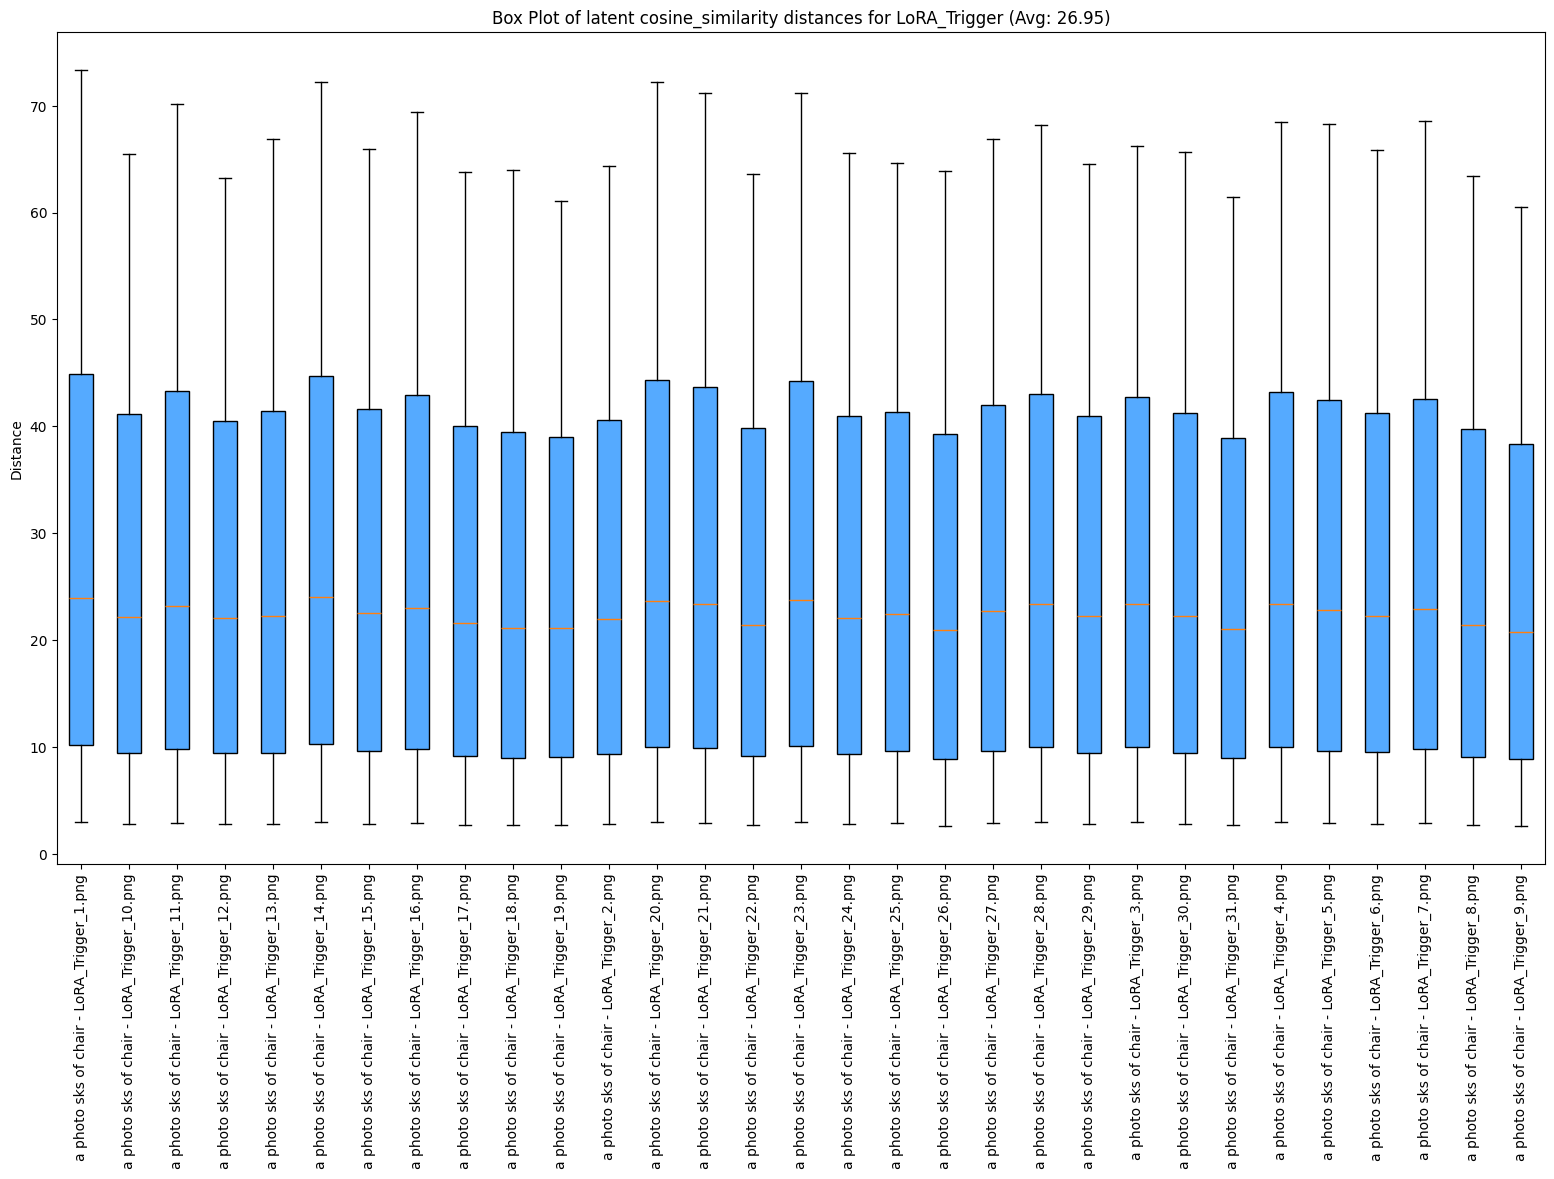

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


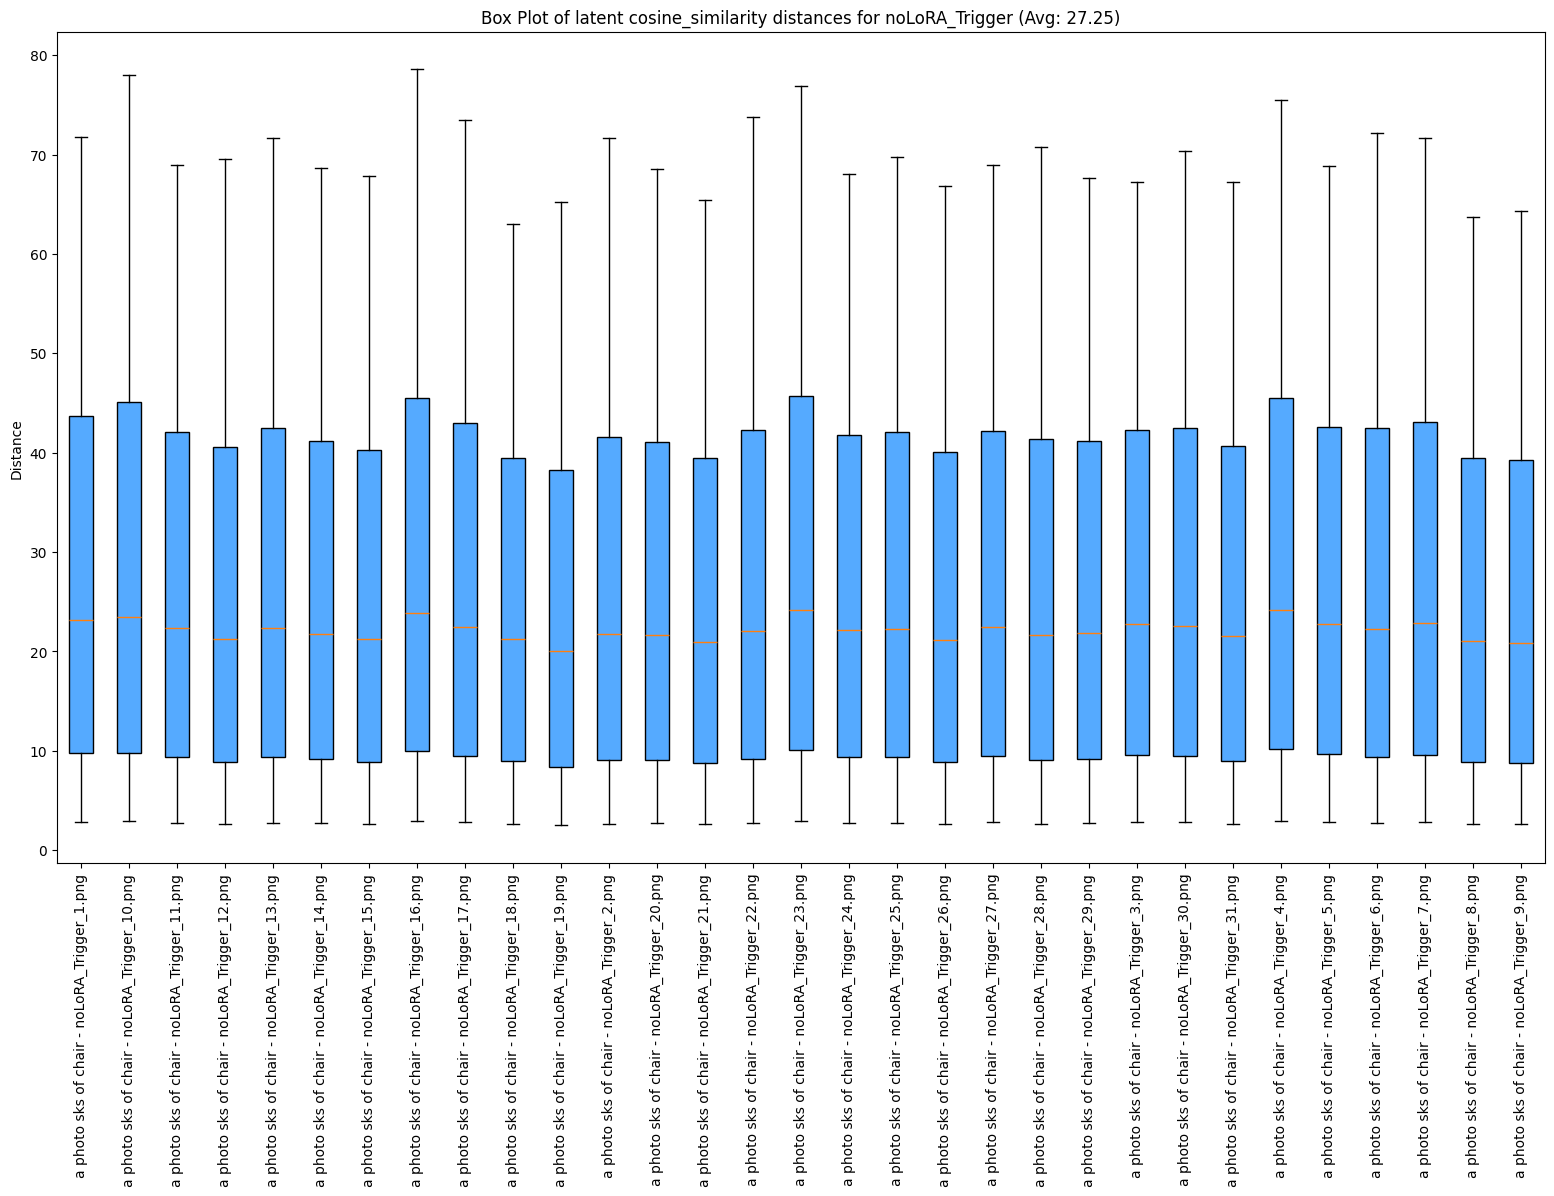

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


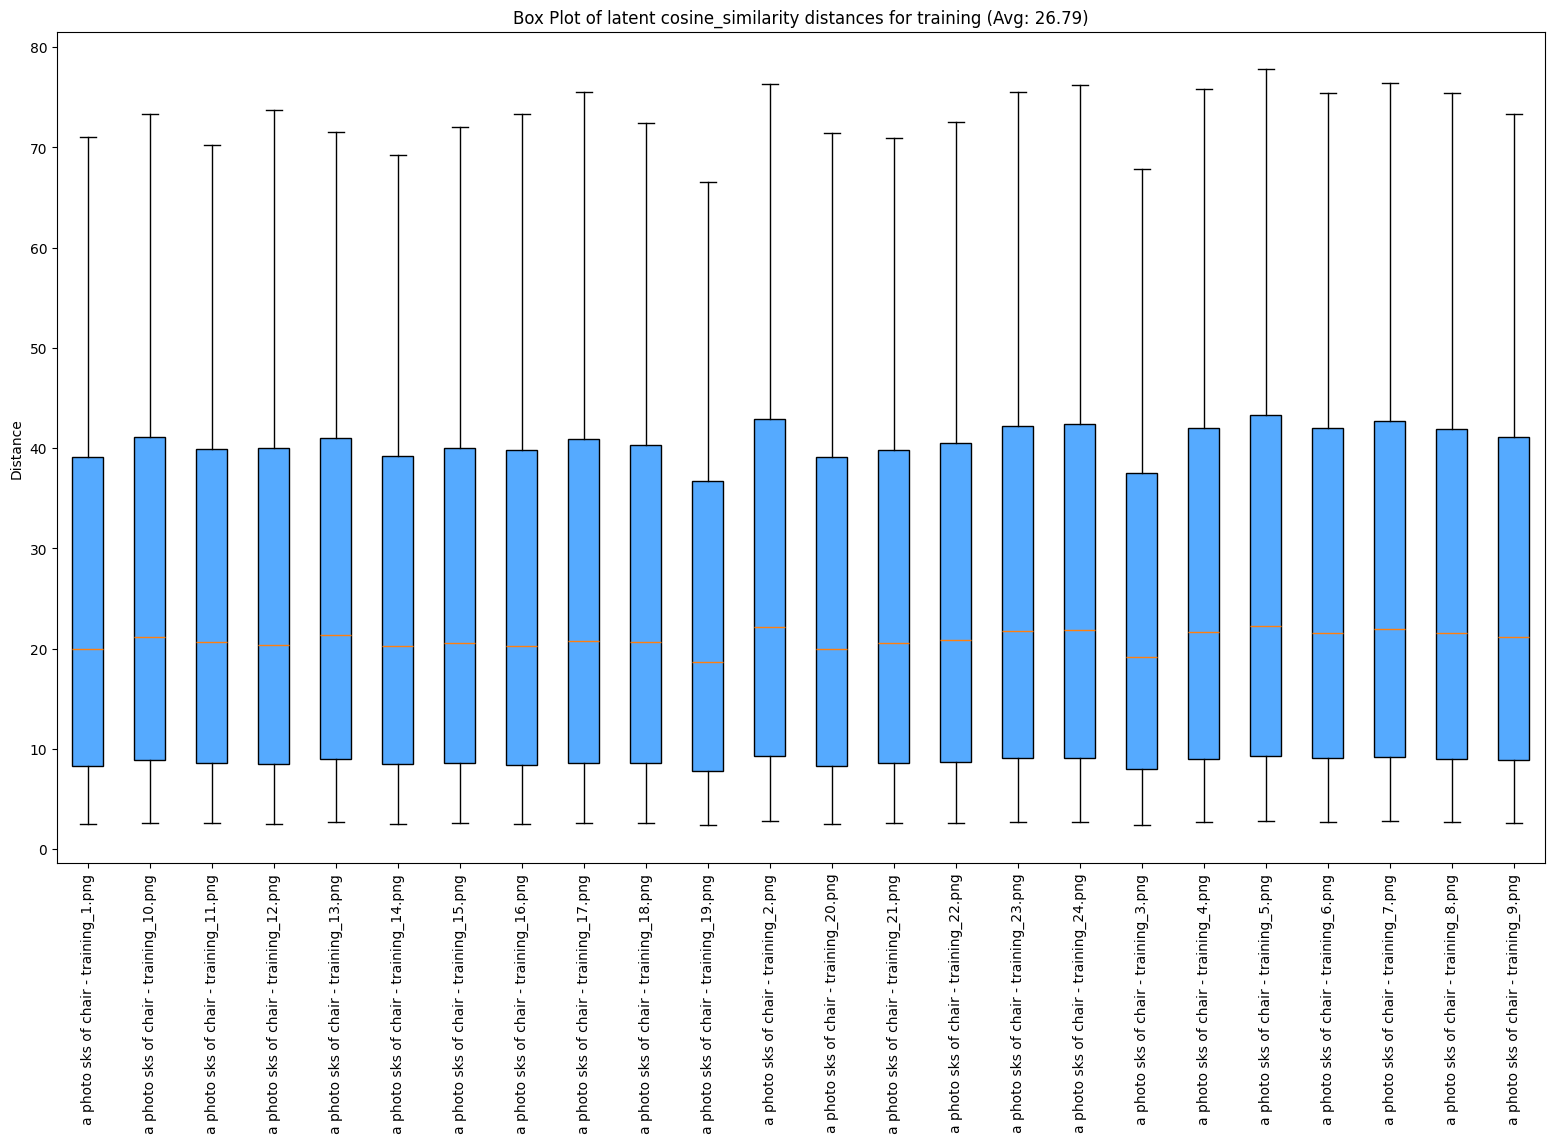

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


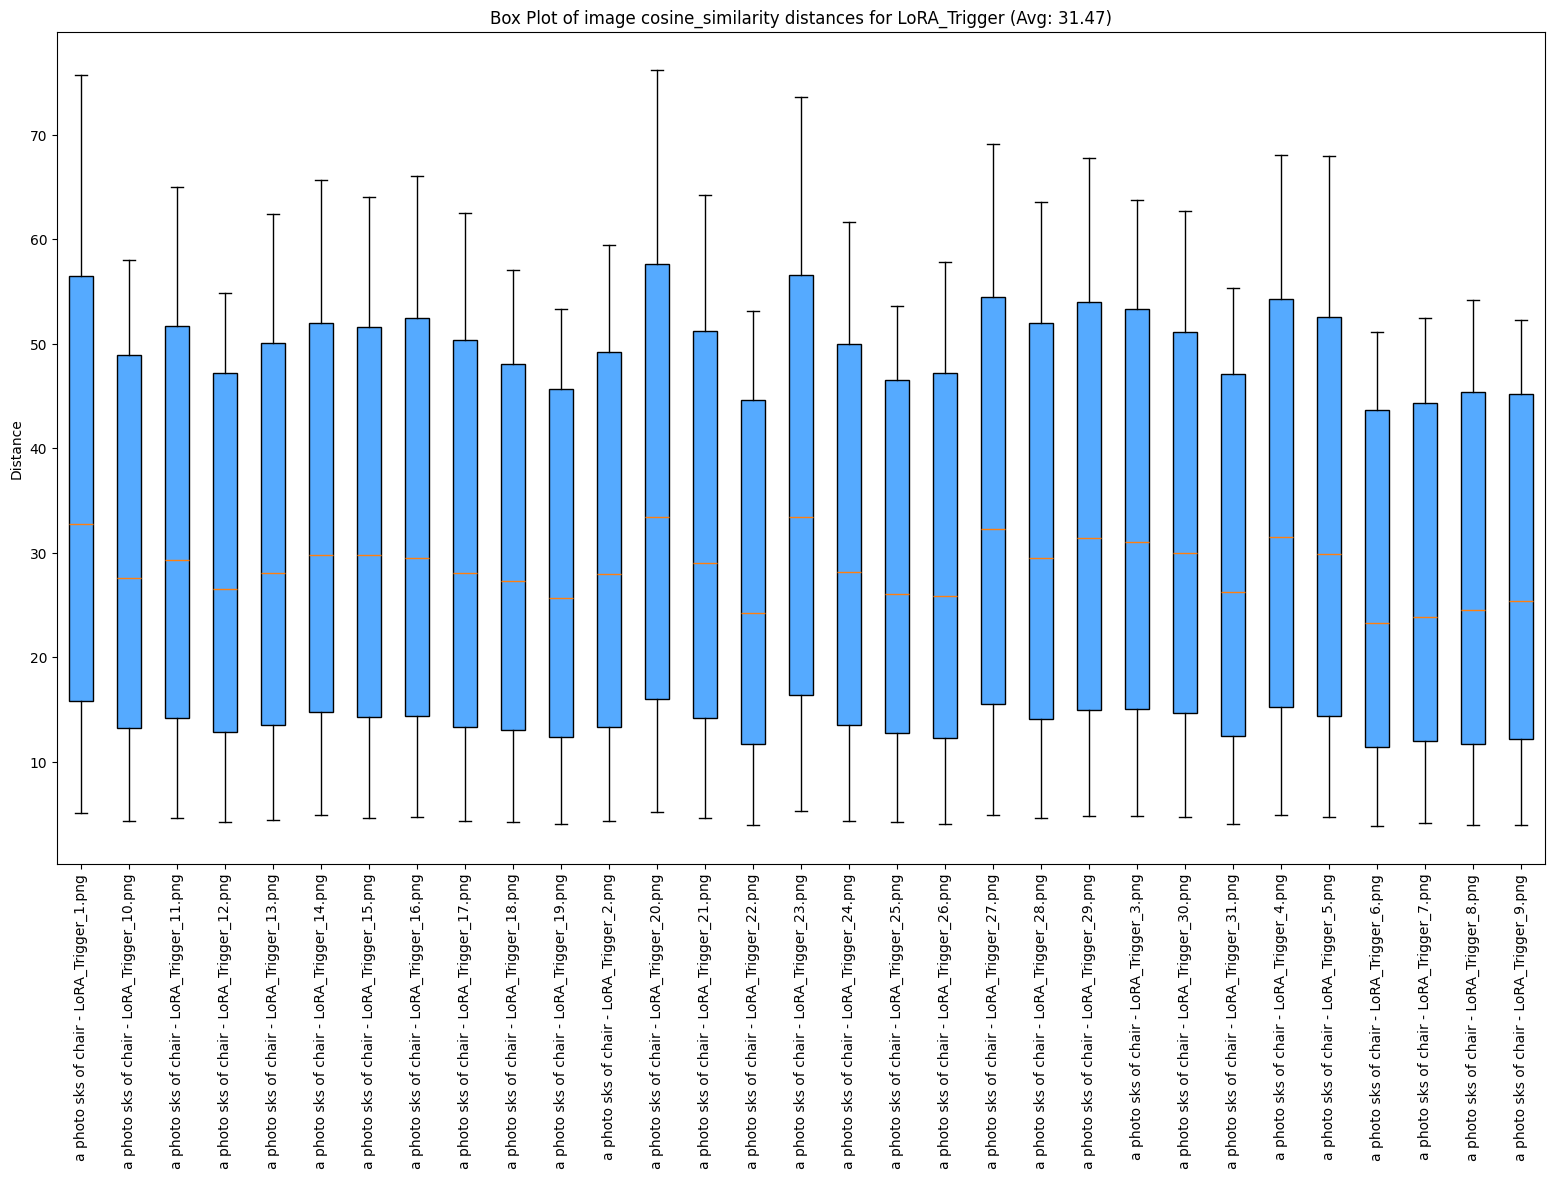

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


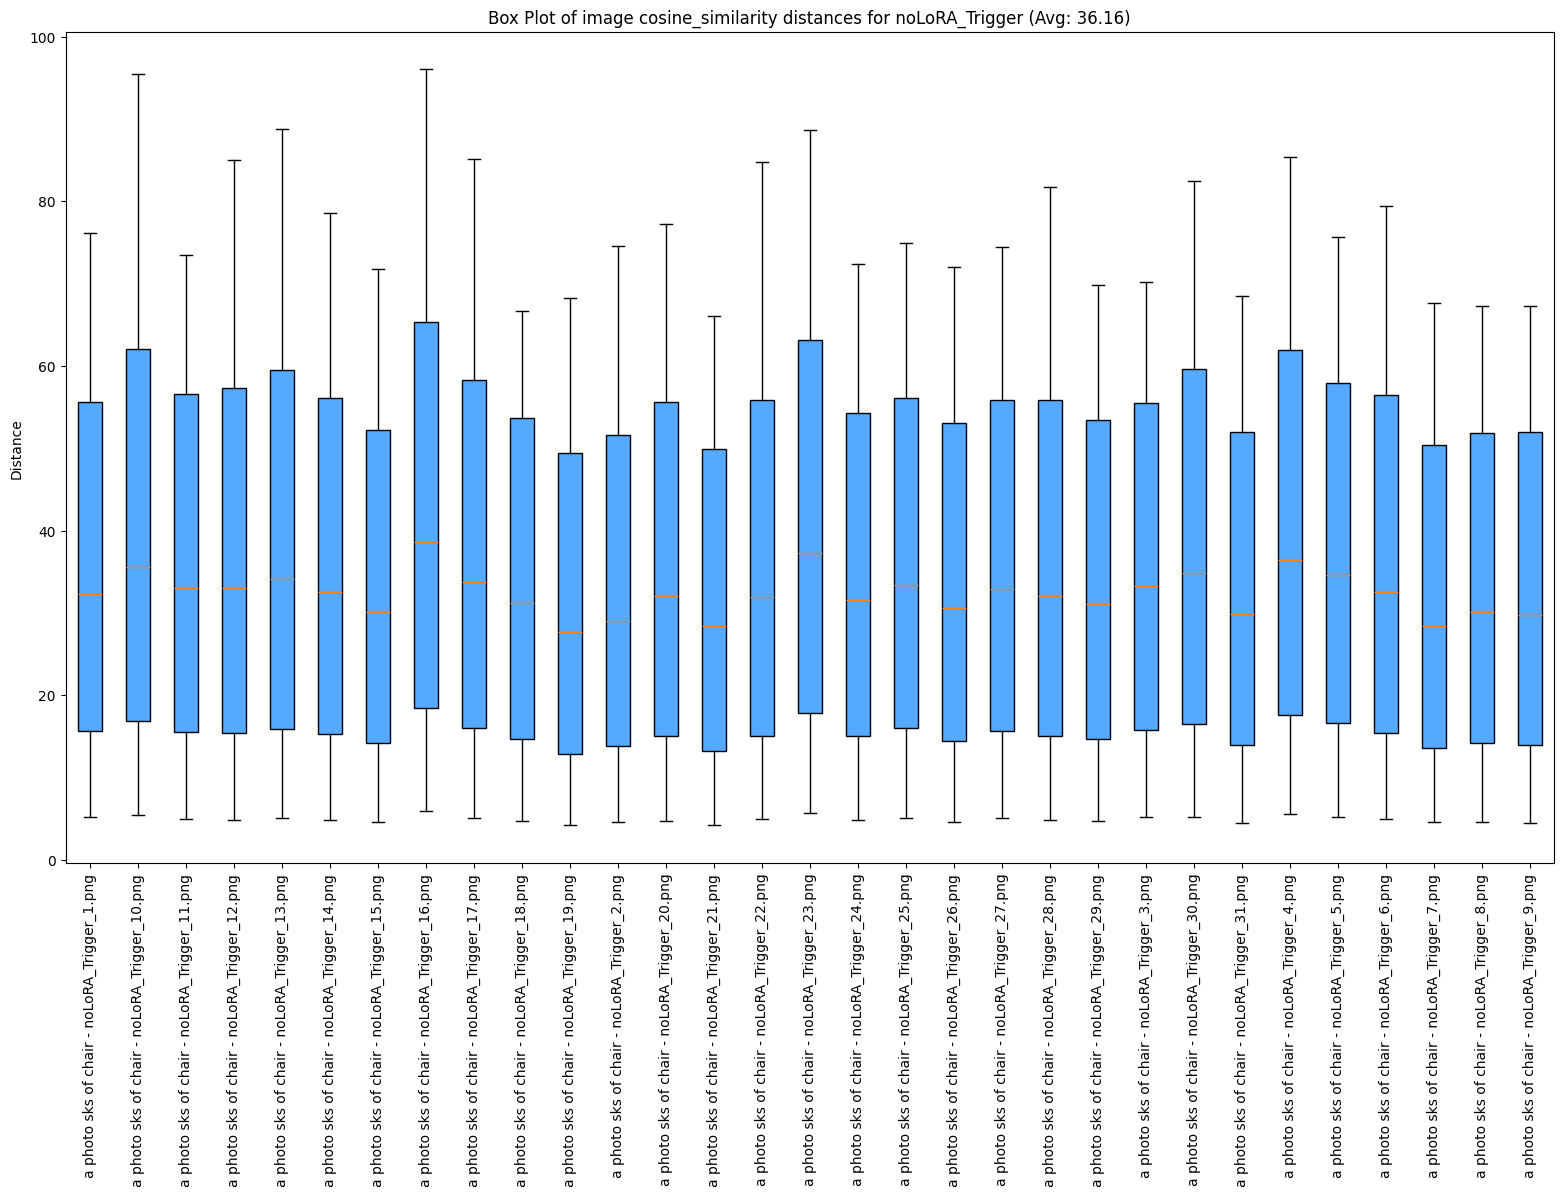

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


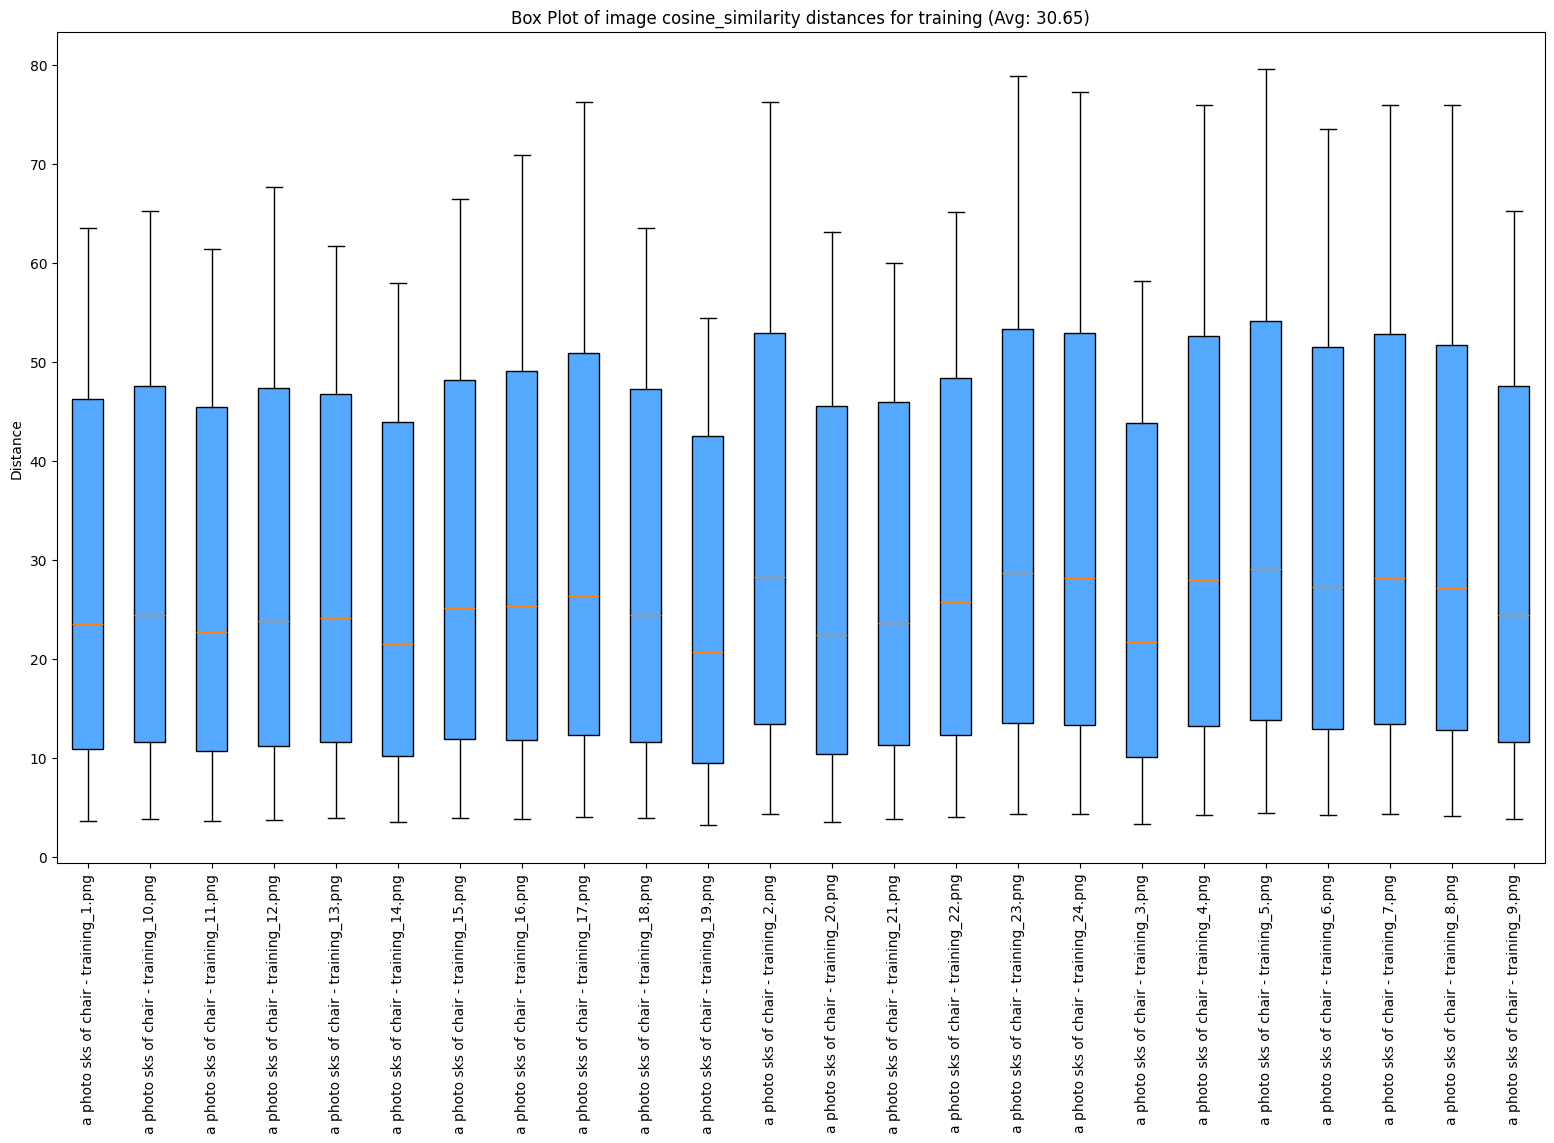

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


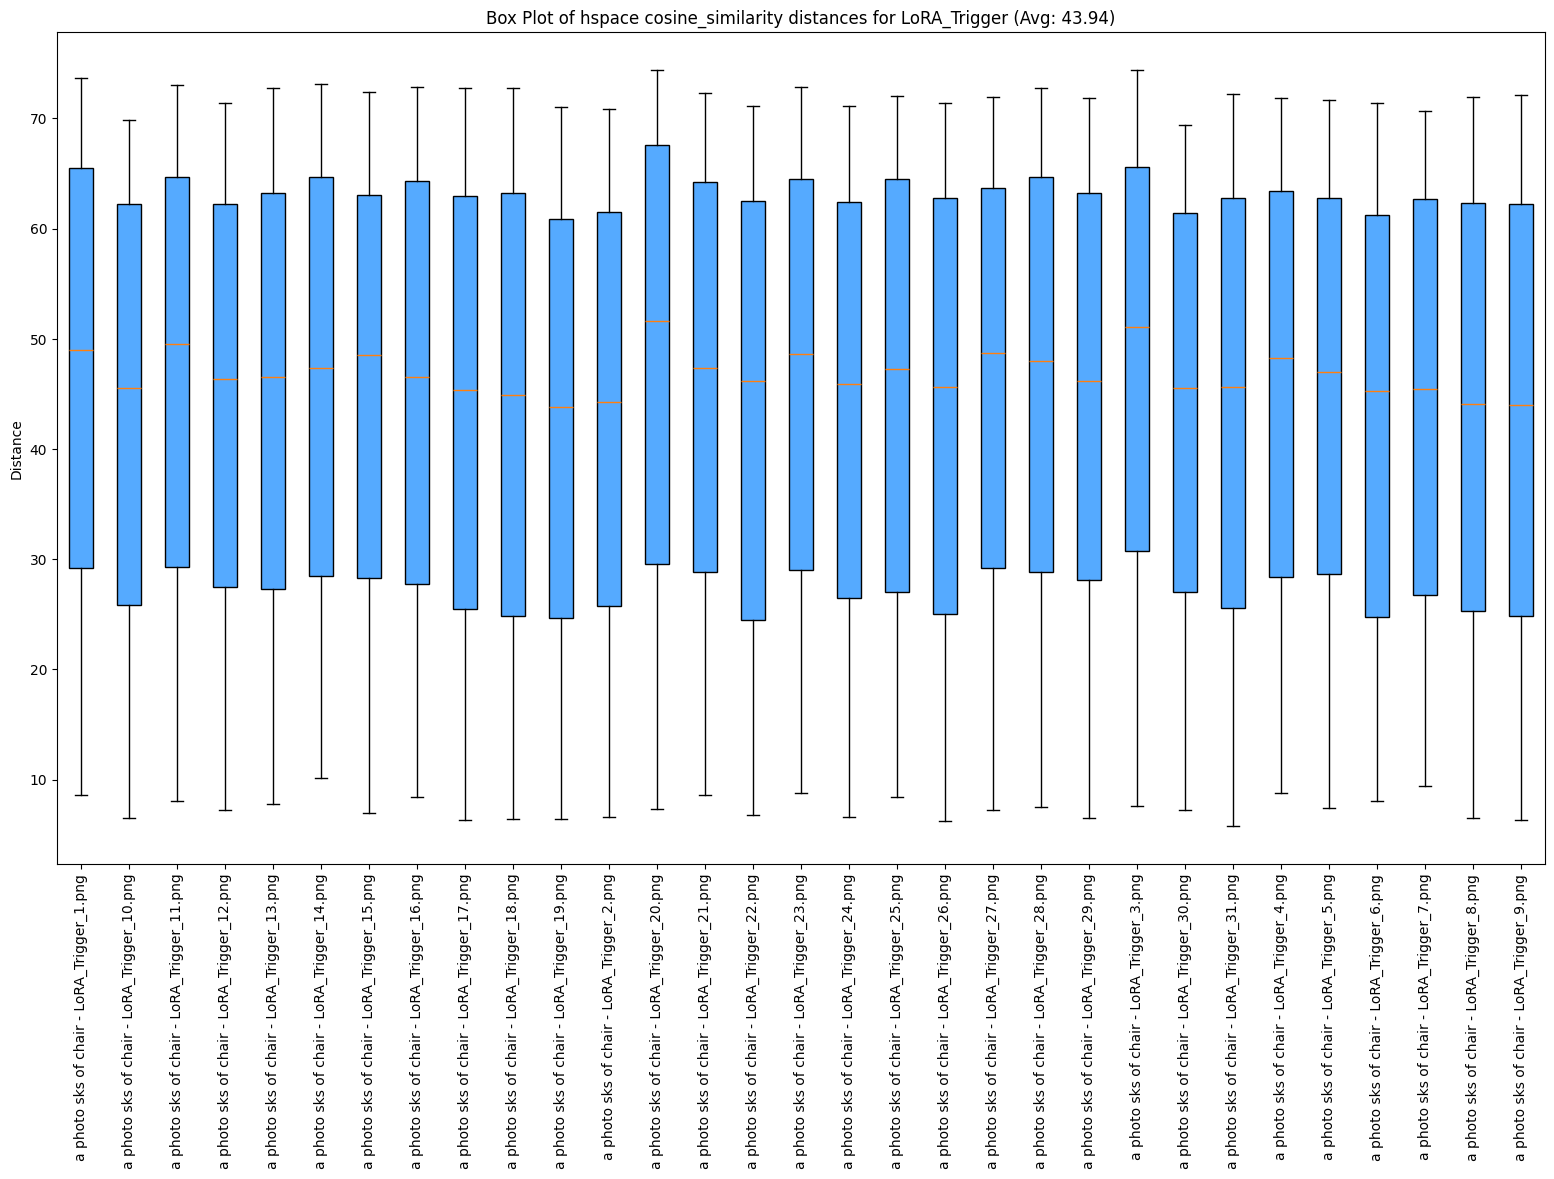

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


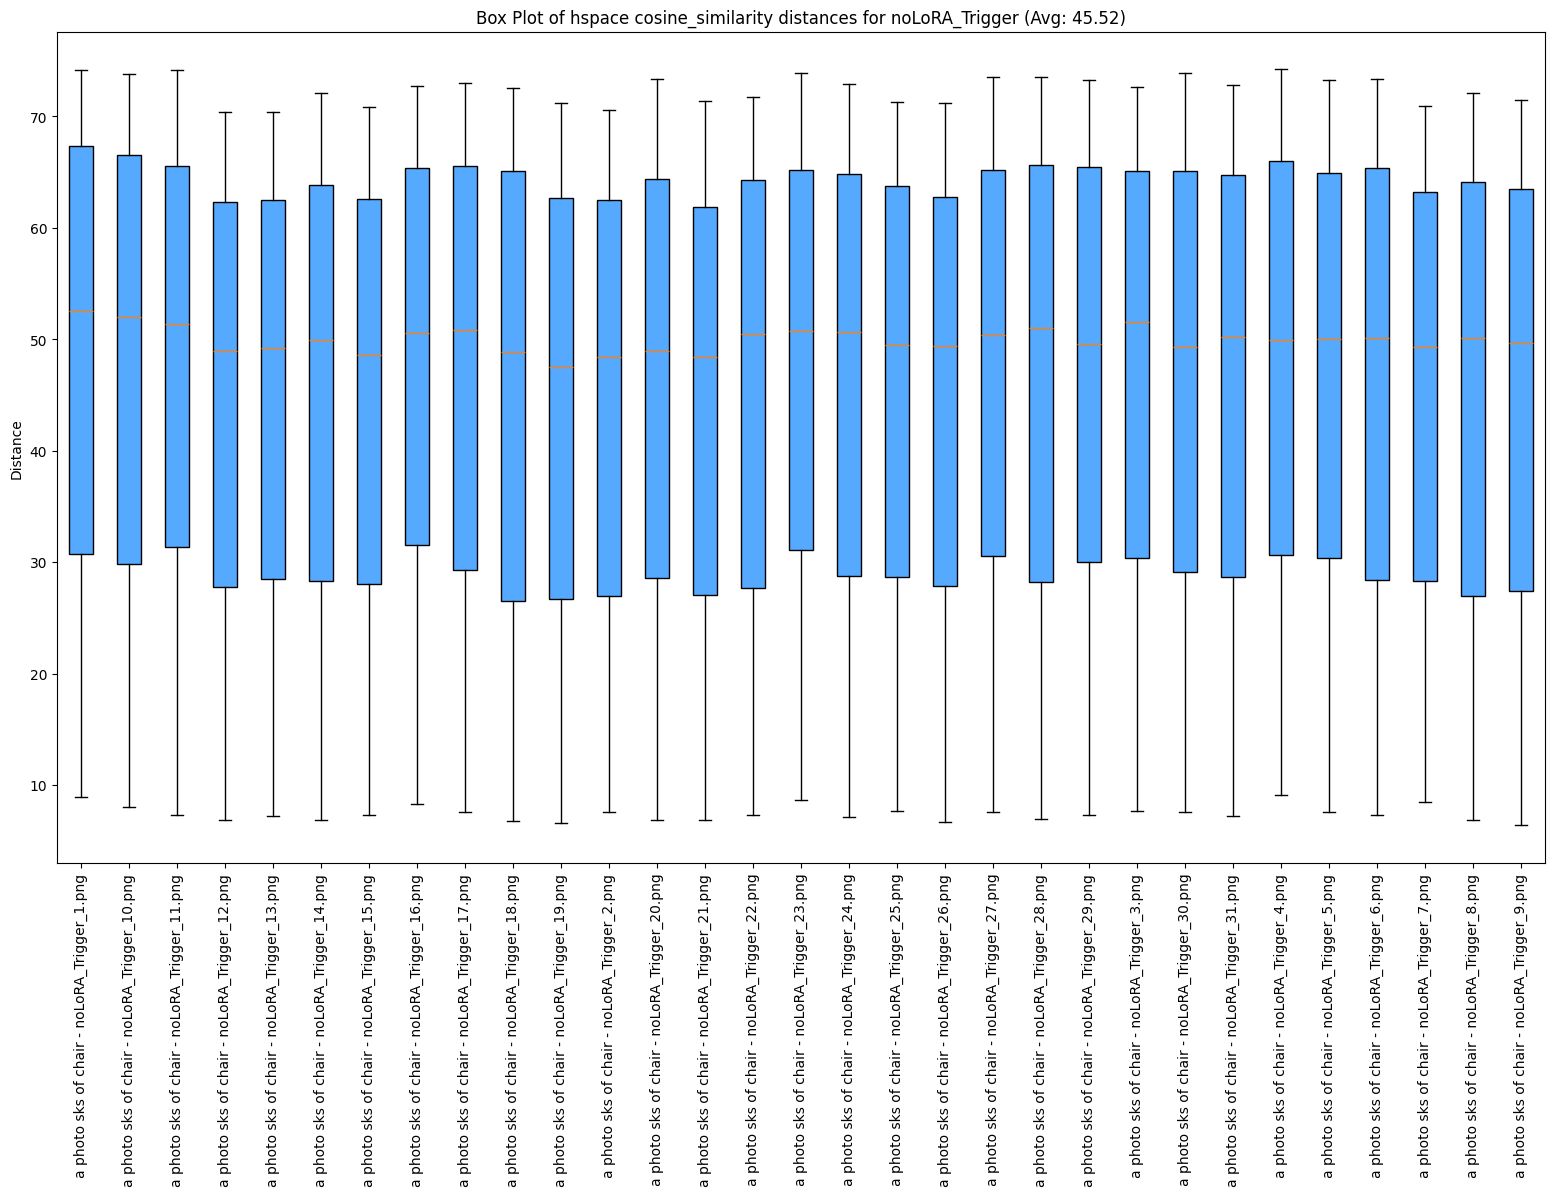

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_6044\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


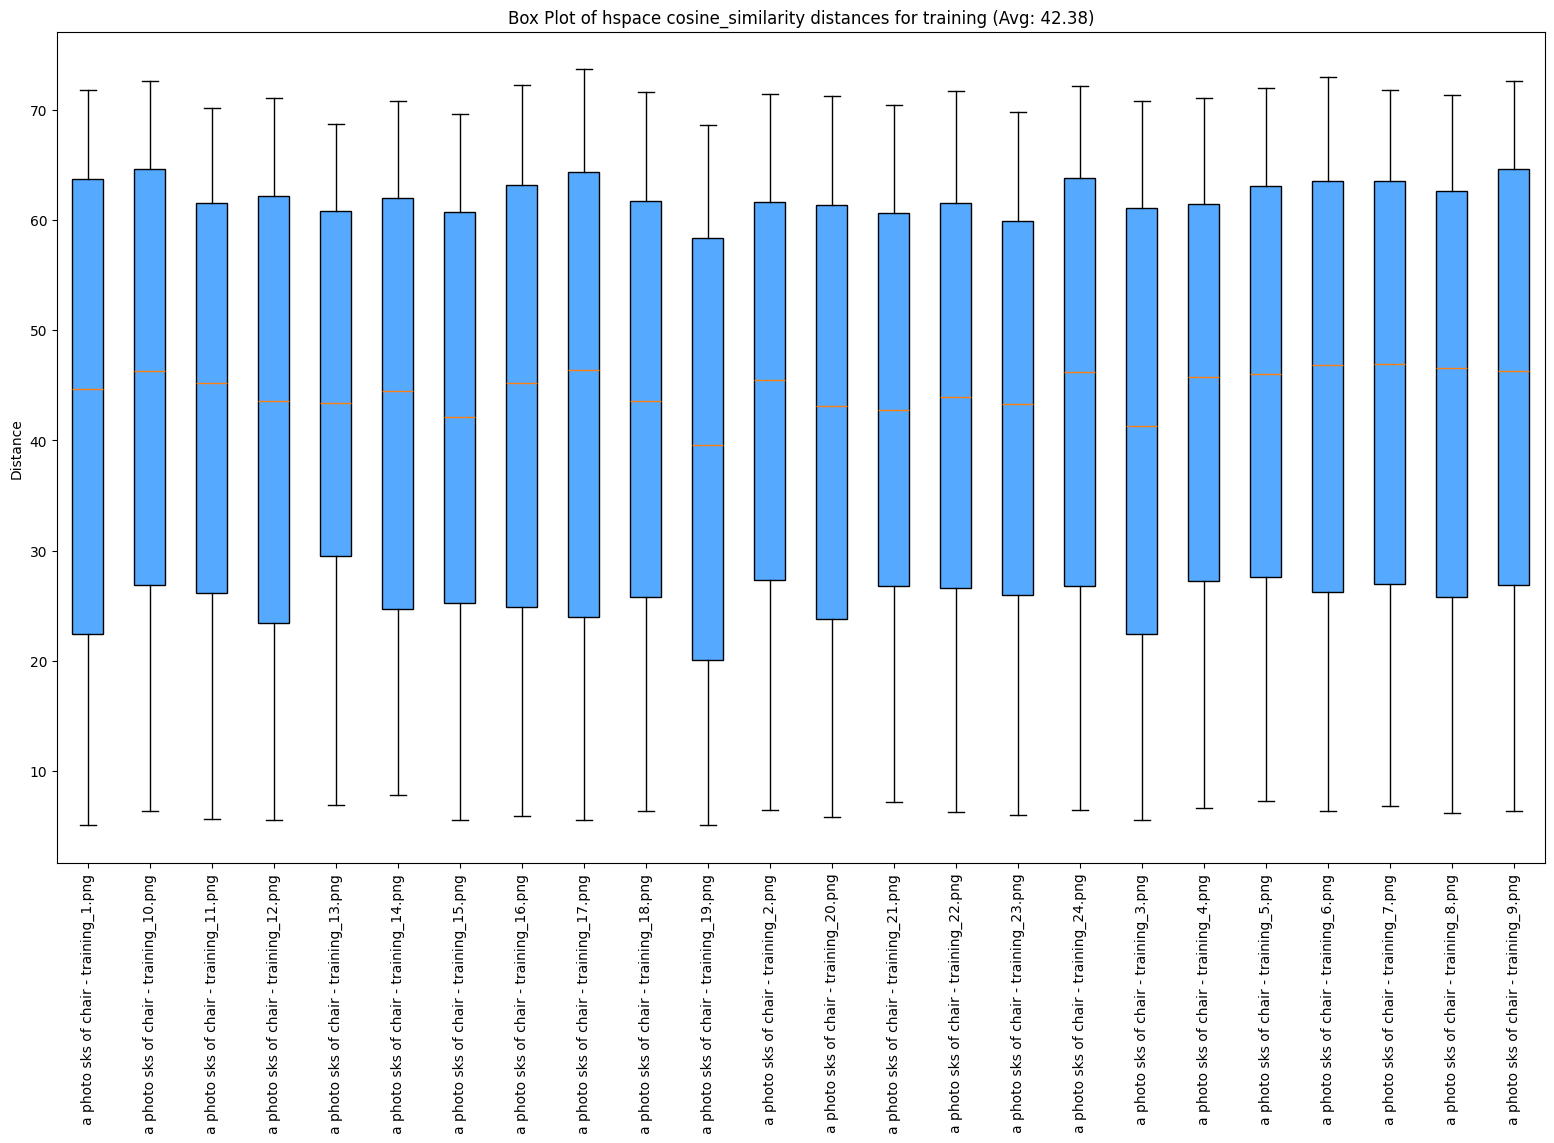

In [21]:

# # plot L1 distance
# plot_boxplot(anaysis_data["L1_step"], 'latent', "L1_step")
# plot_boxplot(anaysis_data["L1_step"], 'image', "L1_step")
# plot_boxplot(anaysis_data["L1_step"], 'hspace', "L1_step")

# # plot frechet distance
# plot_boxplot(anaysis_data["frechet_step"], 'latent', "frechet_step")
# plot_boxplot(anaysis_data["frechet_step"], 'image', "frechet_step")
# plot_boxplot(anaysis_data["frechet_step"], 'hspace', "frechet_step")

# plot cosine similarity
plot_boxplot(anaysis_data["cosine_similarity"], 'latent', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'image', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'hspace', "cosine_similarity")

In [22]:
# see all step as a whole array

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = euclidean(experiment_data[prefix][prompt][image_name][key].flatten(), experiment_data[prefix][prompt][first_image_name][key].flatten())
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [23]:
# calculate the frechet distance of latent, image, hspace between each image and the first image
def calculate_frechet_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [24]:
# calculate the L1 distance of latent, image, hspace between each image and the first image
def calculate_L1_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key].flatten() - experiment_data[prefix][prompt][first_image_name][key].flatten()))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data


In [25]:
anaysis_data["L2_whole"] = calculate_euclidean_distance_whole_together(experiment_data)
# anaysis_data["frechet_whole"] = calculate_frechet_distance_whole_together(experiment_data)
# anaysis_data["L1_whole"] = calculate_L1_distance_whole_together(experiment_data)

LoRA_Trigger_0.png
noLoRA_Trigger_0.png
training_0.png


In [26]:
print(anaysis_data["L2_whole"])

{'LoRA_Trigger': {'a photo sks of chair': {'LoRA_Trigger_1.png': {'latent': [187.15741], 'image': [5143.786227389506], 'hspace': [5823.5913]}, 'LoRA_Trigger_10.png': {'latent': [174.1046], 'image': [4466.5922037088785], 'hspace': [5528.763]}, 'LoRA_Trigger_11.png': {'latent': [181.06096], 'image': [4668.530262013076], 'hspace': [5819.036]}, 'LoRA_Trigger_12.png': {'latent': [174.35759], 'image': [4278.519287208401], 'hspace': [5623.141]}, 'LoRA_Trigger_13.png': {'latent': [174.5913], 'image': [4532.9278832018845], 'hspace': [5638.1655]}, 'LoRA_Trigger_14.png': {'latent': [187.94247], 'image': [4784.57095434673], 'hspace': [5758.681]}, 'LoRA_Trigger_15.png': {'latent': [177.03046], 'image': [4681.3347652099], 'hspace': [5676.426]}, 'LoRA_Trigger_16.png': {'latent': [179.93442], 'image': [4715.326530361404], 'hspace': [5672.514]}, 'LoRA_Trigger_17.png': {'latent': [169.83345], 'image': [4554.574388001215], 'hspace': [5615.3887]}, 'LoRA_Trigger_18.png': {'latent': [165.58228], 'image': [4

In [27]:
# calculate the average distance of different distance type、different prefix、different prompt、different distance type
def calculate_average_distance(anaysis_data):
    average_data = {}
    for distance_type in anaysis_data.keys():
        average_data[distance_type] = {}
        for prefix in anaysis_data[distance_type].keys():
            average_data[distance_type][prefix] = {}
            for prompt in anaysis_data[distance_type][prefix].keys():
                average_data[distance_type][prefix][prompt] = {}
                for key in ["latent", "image", "hspace"]:
                    average_data[distance_type][prefix][prompt][key] = np.mean([np.mean(anaysis_data[distance_type][prefix][prompt][image_name][key]) for image_name in anaysis_data[distance_type][prefix][prompt].keys()])
    return average_data

average_data = calculate_average_distance(anaysis_data)

for distance_type in average_data.keys():
    print(f"Distance Type: {distance_type}")
    for prefix in average_data[distance_type].keys():
        print(f"Prefix: {prefix}")
        for prompt in average_data[distance_type][prefix].keys():
            print(f"Prompt: {prompt}")
            for key in average_data[distance_type][prefix][prompt].keys():
                print(f"Key: {key} Avg: {average_data[distance_type][prefix][prompt][key]:.2f}")
            print()
        print() 




Distance Type: L2_step
Prefix: LoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 28.14
Key: image Avg: 652.20
Key: hspace Avg: 824.98


Prefix: noLoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 25.21
Key: image Avg: 676.07
Key: hspace Avg: 818.92


Prefix: training
Prompt: a photo sks of chair
Key: latent Avg: 26.05
Key: image Avg: 609.06
Key: hspace Avg: 750.18


Distance Type: frechet_step
Distance Type: L1_step
Distance Type: cosine_similarity
Prefix: LoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 26.95
Key: image Avg: 31.47
Key: hspace Avg: 43.94


Prefix: noLoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 27.25
Key: image Avg: 36.16
Key: hspace Avg: 45.52


Prefix: training
Prompt: a photo sks of chair
Key: latent Avg: 26.79
Key: image Avg: 30.65
Key: hspace Avg: 42.38


Distance Type: L2_whole
Prefix: LoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 176.06
Key: image Avg: 4551.66
Key: hspace Avg: 5650.37


Prefix: noLoRA_Trigger

In [28]:
import pandas as pd
records = []
for distance_type in average_data:
    for prefix in average_data[distance_type]:
        for prompt in average_data[distance_type][prefix]:
            row = {
                "Distance Type": distance_type,
                "Prefix": prefix,
                "Prompt": prompt,
            }
            row.update(average_data[distance_type][prefix][prompt])
            records.append(row)

df = pd.DataFrame(records)

print(df)

       Distance Type          Prefix                Prompt      latent  \
0            L2_step    LoRA_Trigger  a photo sks of chair   28.138214   
1            L2_step  noLoRA_Trigger  a photo sks of chair   25.210333   
2            L2_step        training  a photo sks of chair   26.045950   
3  cosine_similarity    LoRA_Trigger  a photo sks of chair   26.954231   
4  cosine_similarity  noLoRA_Trigger  a photo sks of chair   27.248276   
5  cosine_similarity        training  a photo sks of chair   26.792388   
6           L2_whole    LoRA_Trigger  a photo sks of chair  176.058548   
7           L2_whole  noLoRA_Trigger  a photo sks of chair  170.989670   
8           L2_whole        training  a photo sks of chair  161.219421   

         image       hspace  
0   652.199947   824.983093  
1   676.073231   818.916077  
2   609.063803   750.184387  
3    31.465494    43.937097  
4    36.155364    45.515163  
5    30.646468    42.379175  
6  4551.662041  5650.369629  
7  4895.847746  582

In [29]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for prefix in experiment_data.keys():
        analysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            analysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    continue
                analysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = distance_func(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        analysis_data[prefix][prompt][image_name][key].append(distance)
    return analysis_data


In [30]:

def plot_distance_over_time(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF', 'training': '#00FFF0'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            plt.figure(figsize=(19.2, 10.8))
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=image_name, color=colors[prefix])
            plt.xlabel('Time Step')
            plt.ylabel('Distance')
            plt.title(f'{distance_type} Distance Over Time for {prefix} - {prompt} ({key})')
            plt.legend()
            plt.show()


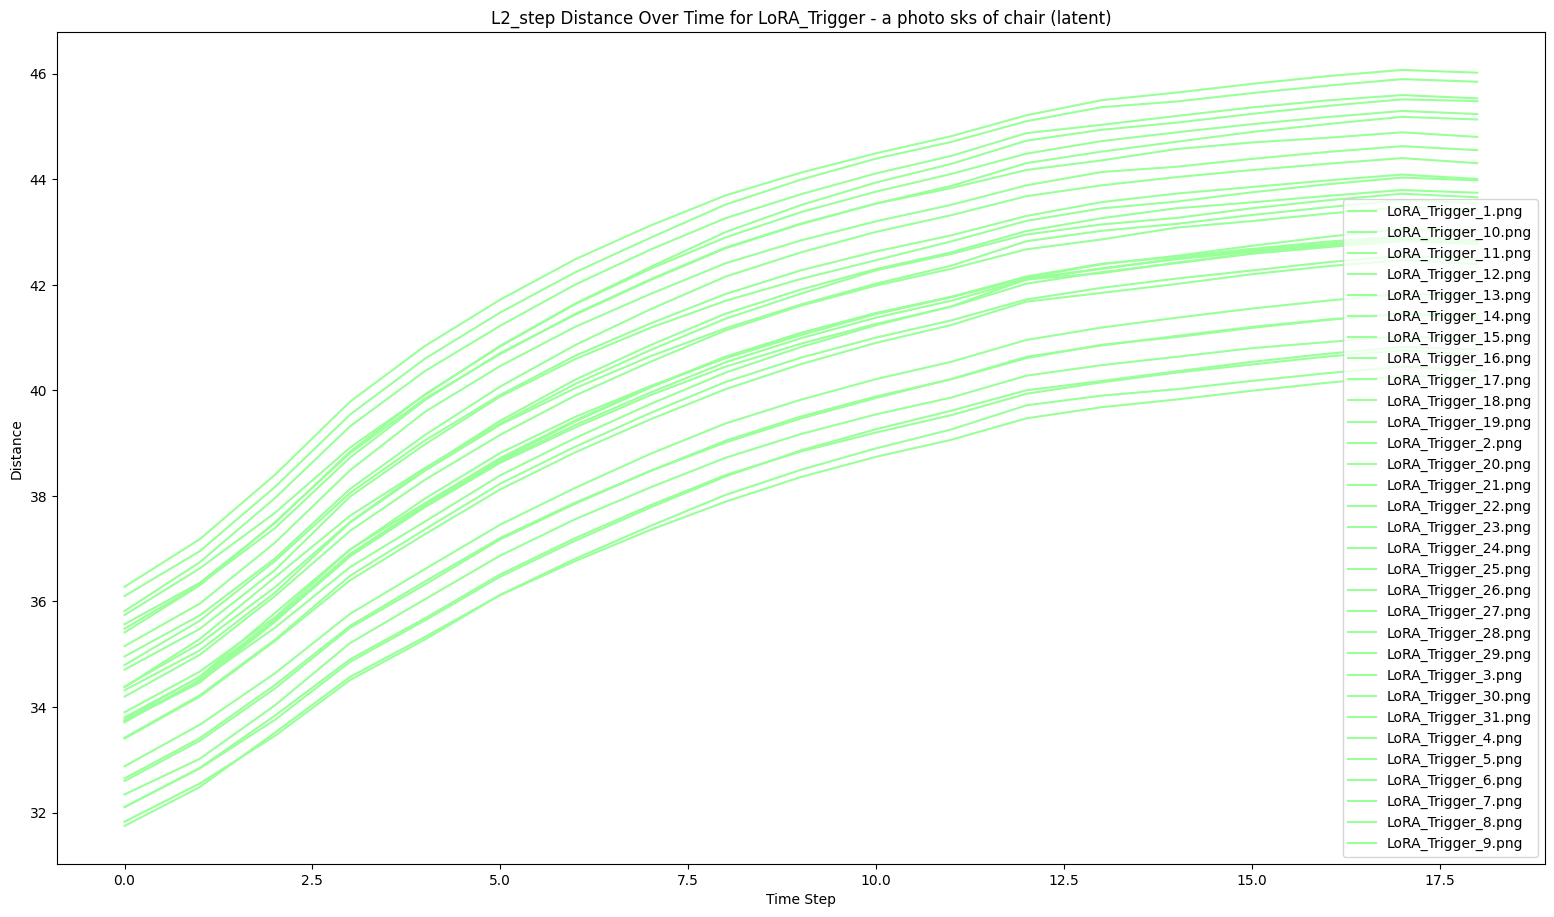

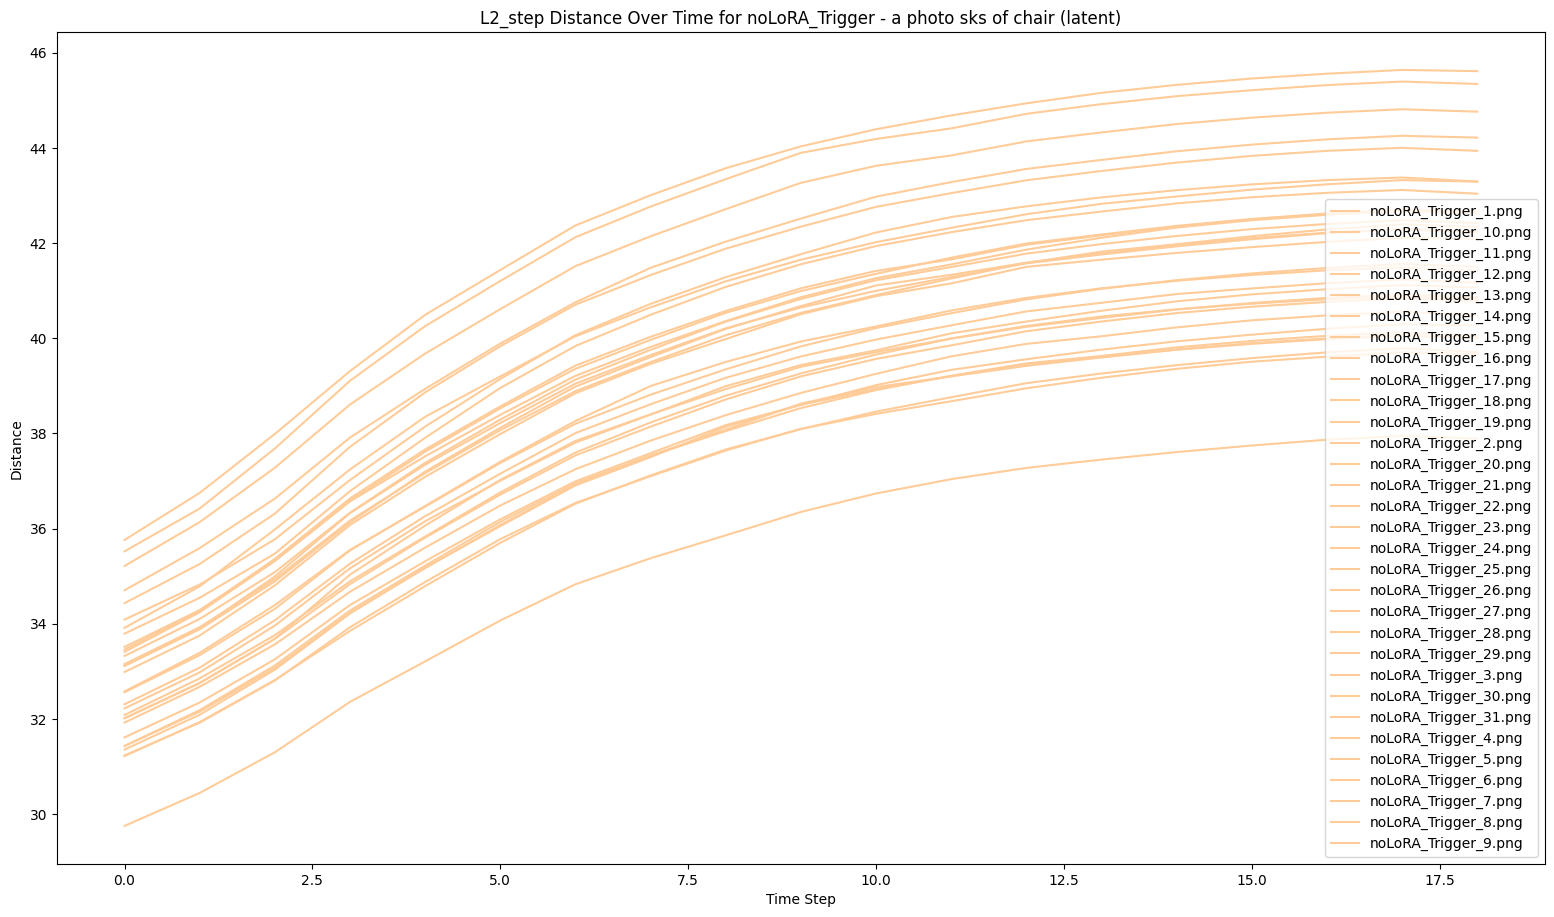

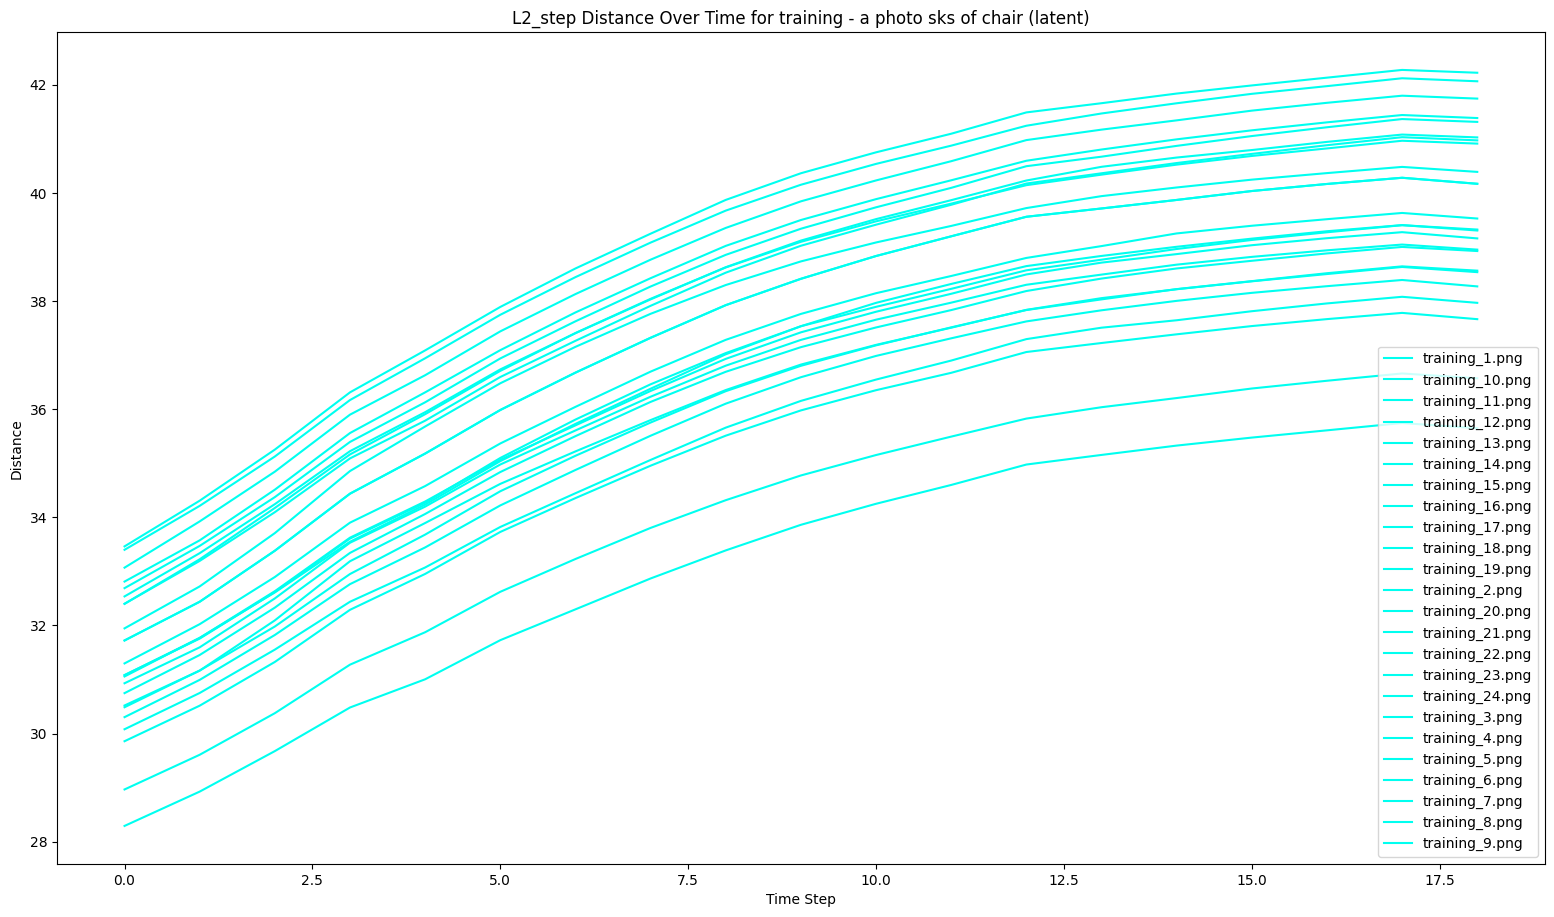

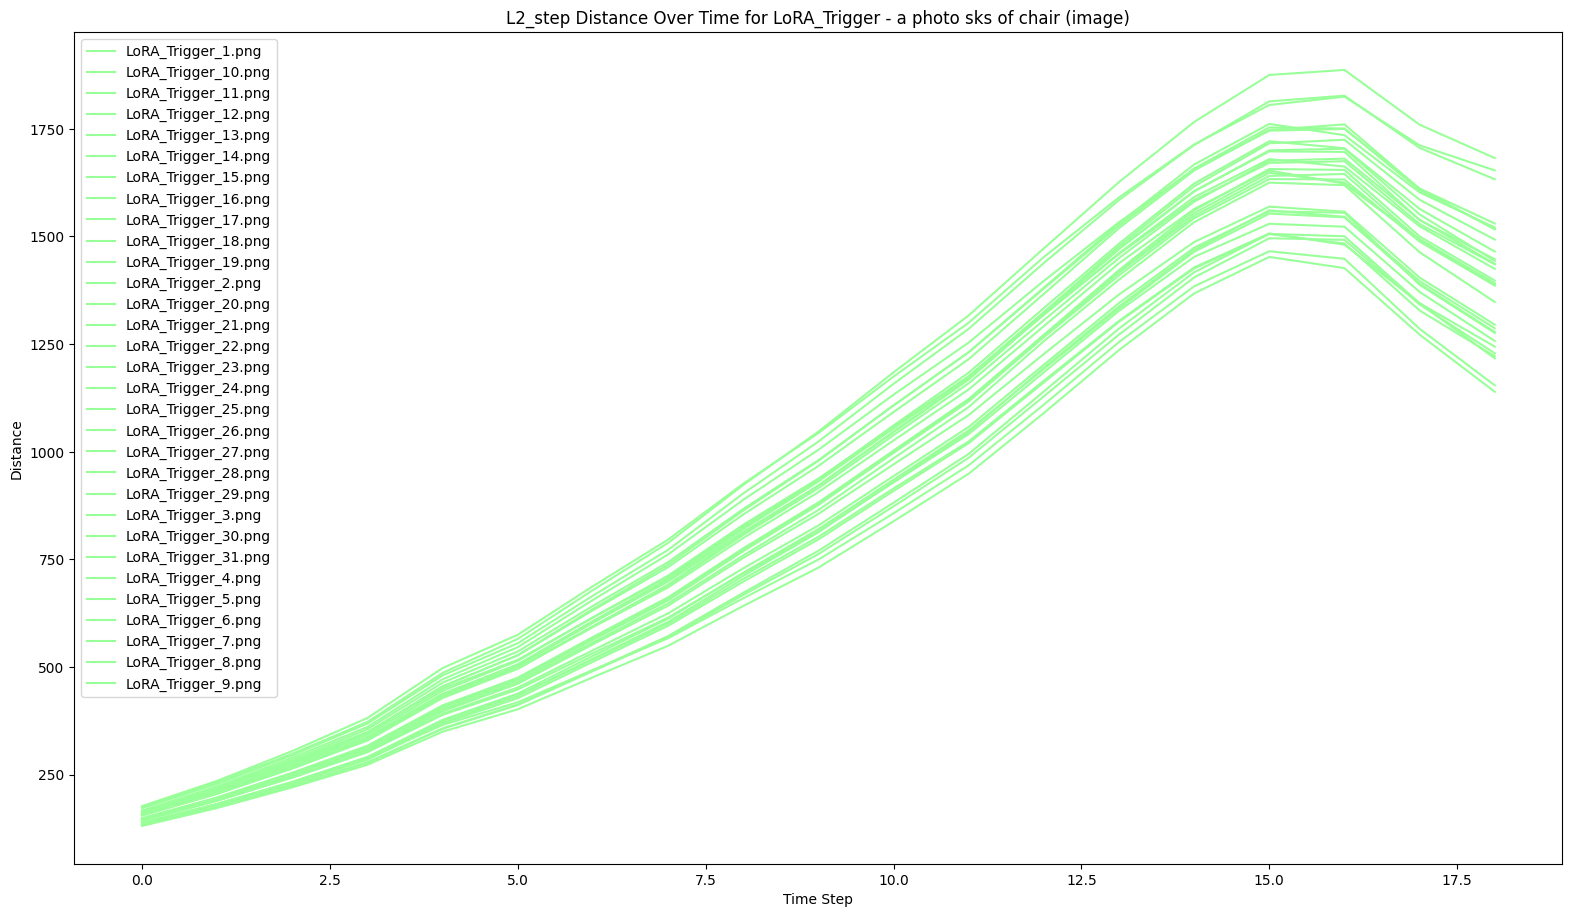

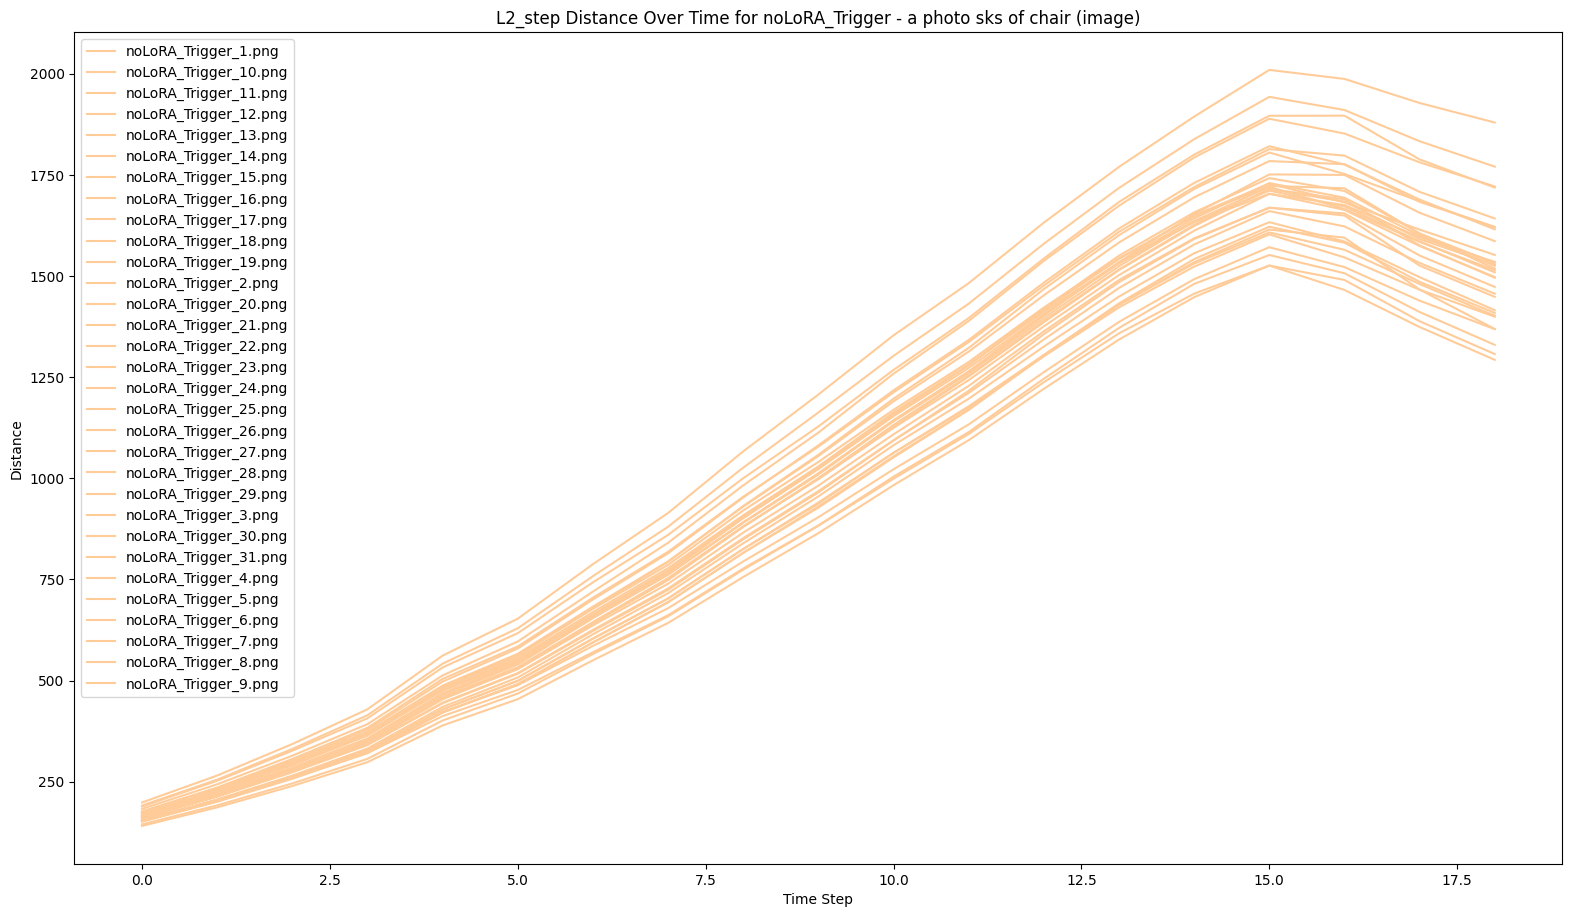

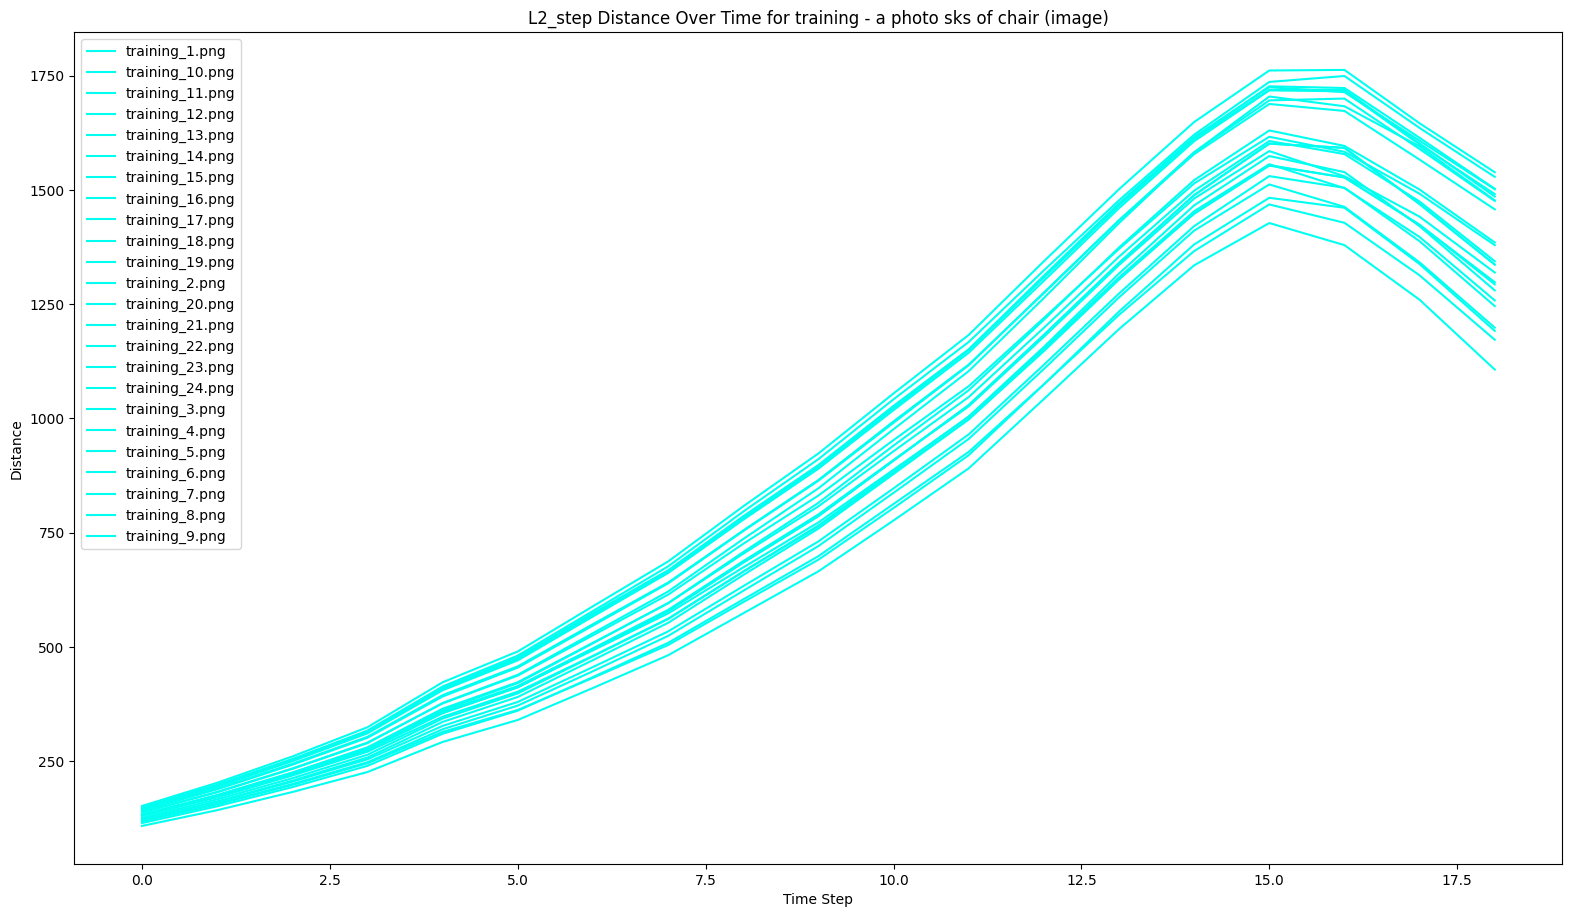

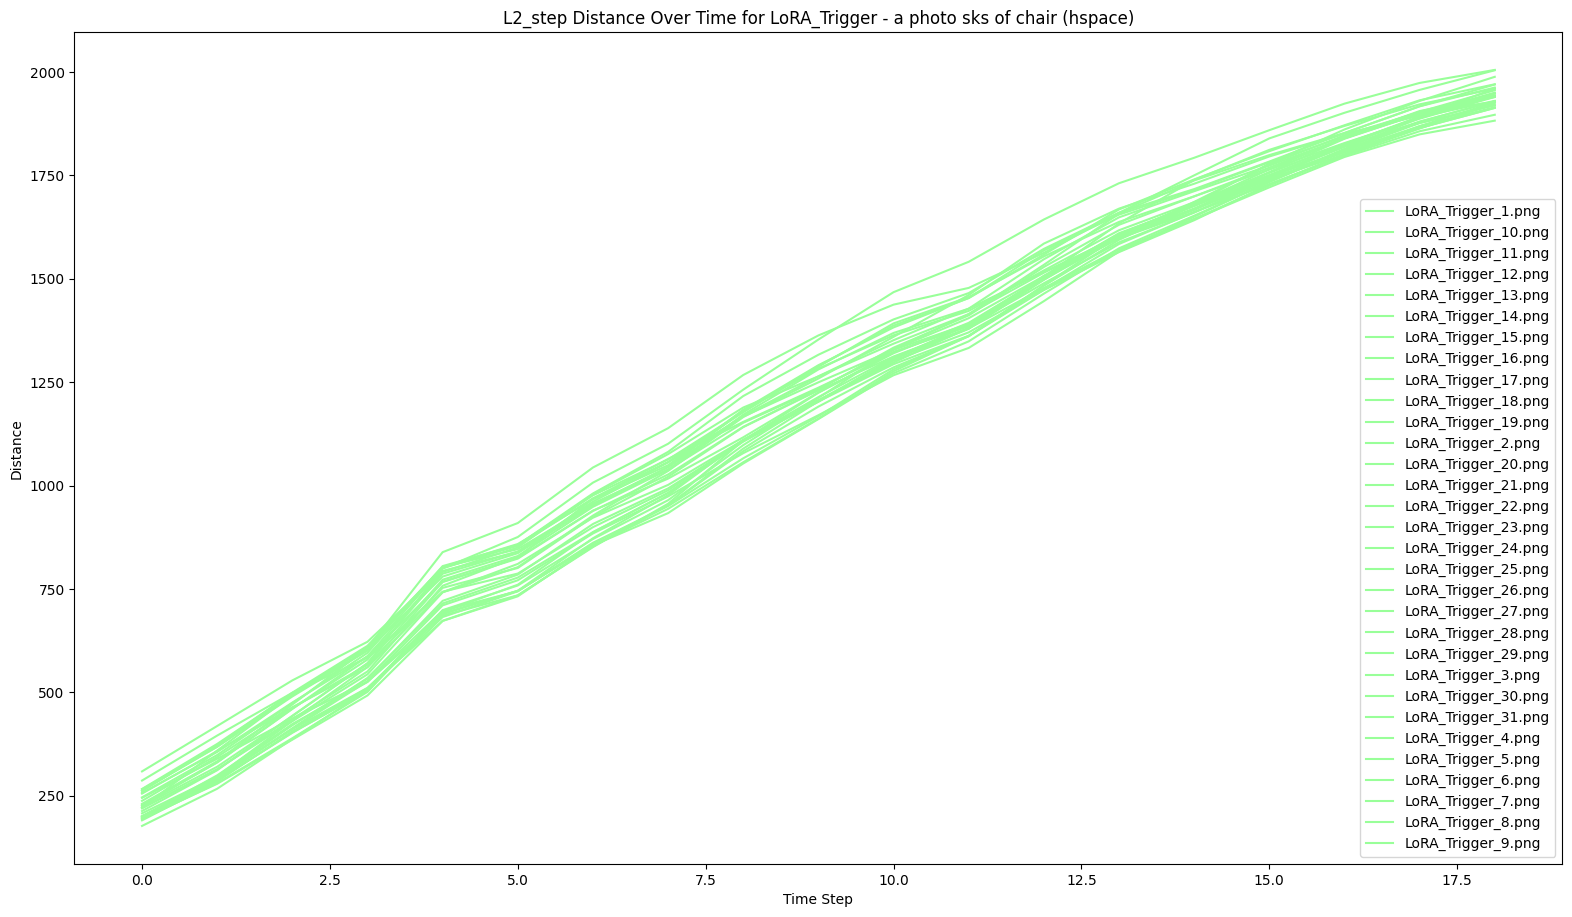

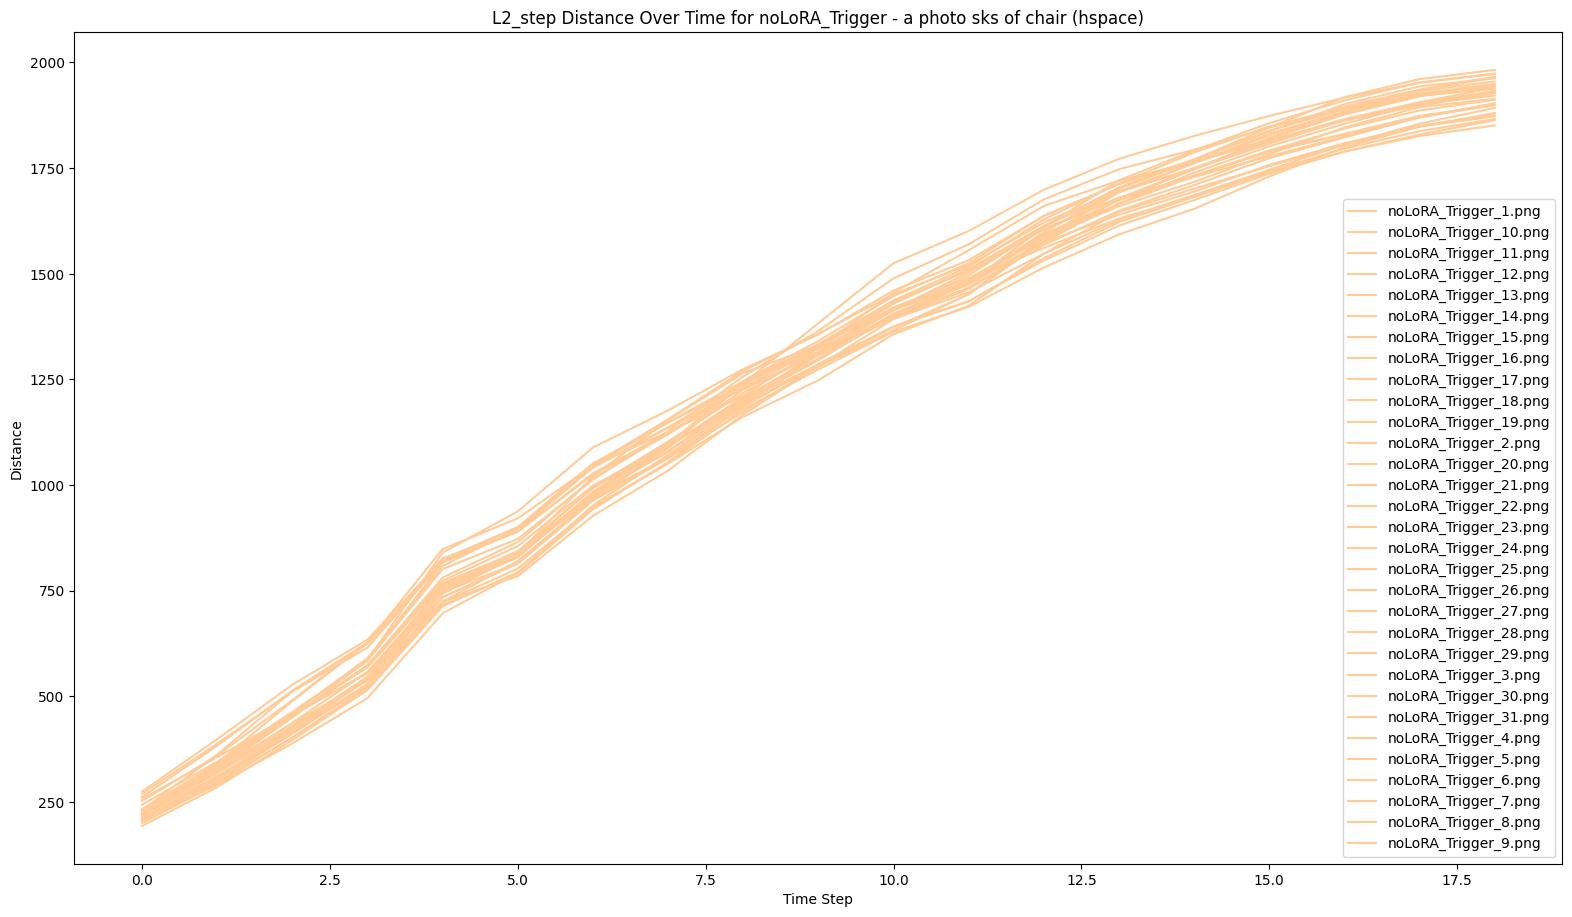

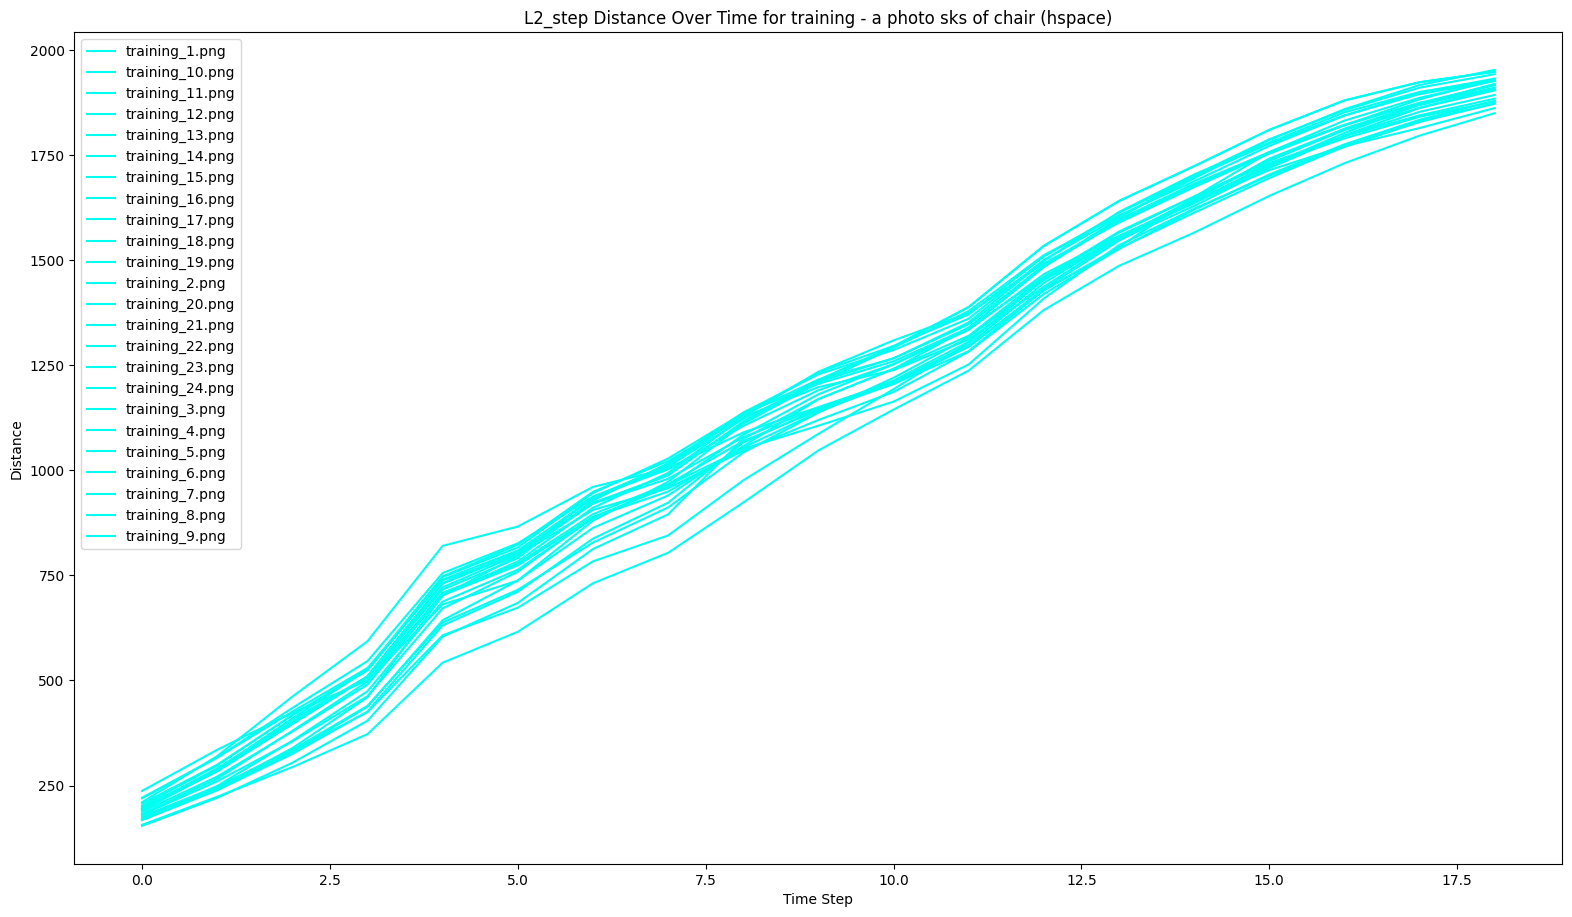

In [31]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)
plot_distance_over_time(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time(l2_analysis_data, 'hspace', "L2_step")

In [32]:
# 參考上面的，但每種距離個畫一張圖就好，latent 一張(裡面有每個 prefix)，image 一張(裡面有每個 prefix)，hspace 一張(裡面有每個 prefix)
# 並且每張圖上的線條(prefix)要有不同的顏色，並且要有圖例
# 並且要有標題，標題要顯示 distance_type、prefix、prompt、key
# 並且要有 x 軸標籤、y 軸標籤

def plot_distance_over_time_draw_by_distance(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF', 'training': '#00FFF0'}
    plt.figure(figsize=(19.2, 10.8))
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=f'{prefix} - {prompt} - {image_name}', color=colors[prefix])
    plt.xlabel('Time Step')
    plt.ylabel('Distance')
    plt.title(f'{distance_type} Distance Over Time ({key})')
    plt.show()


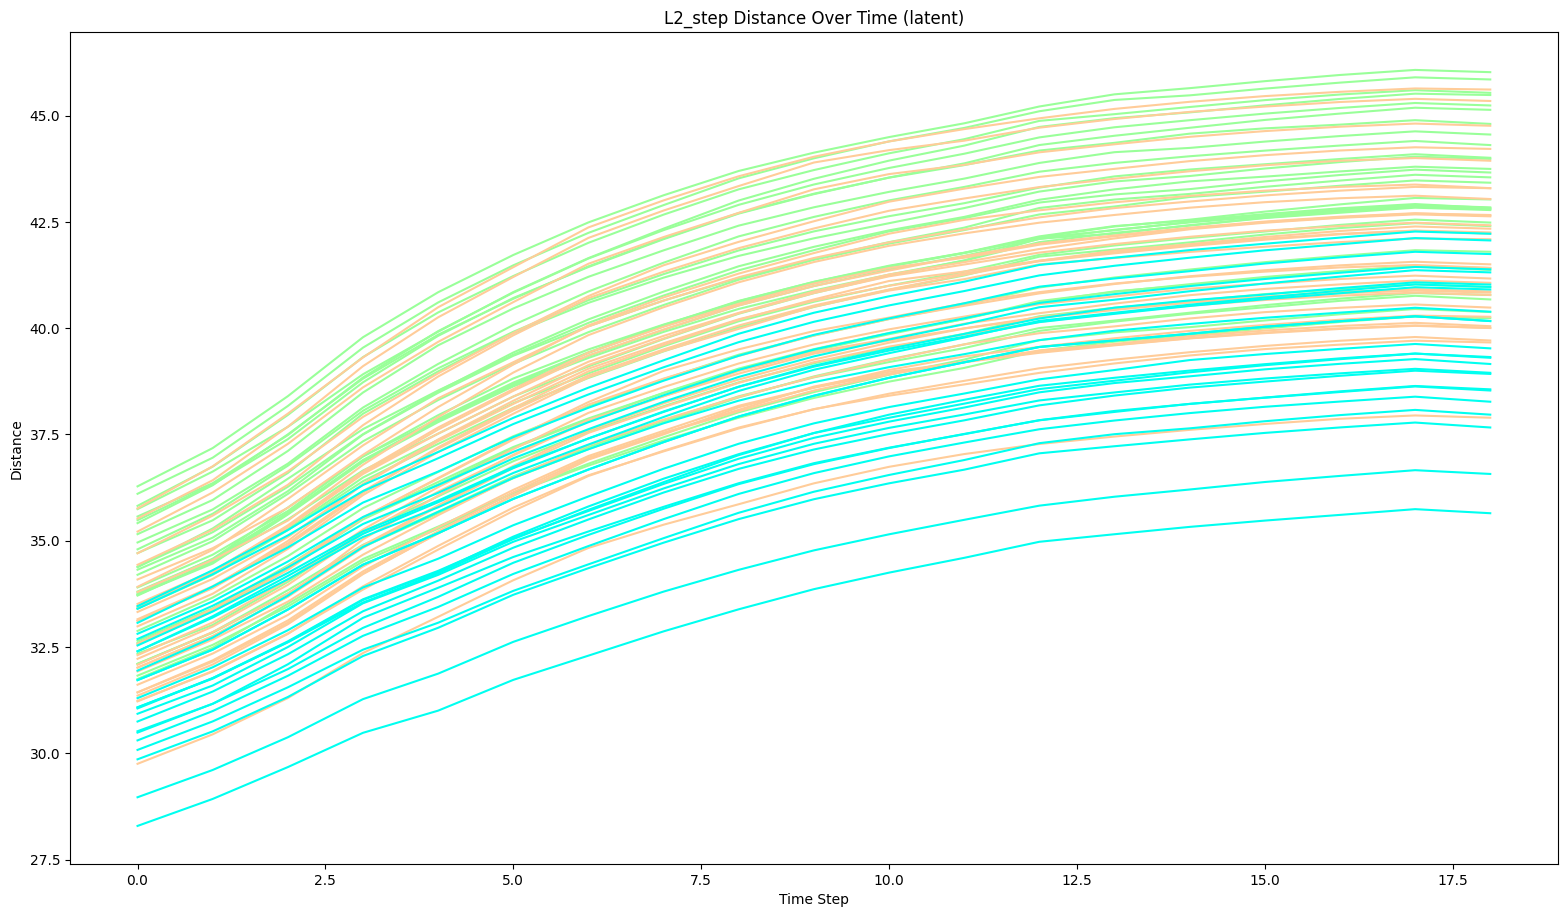

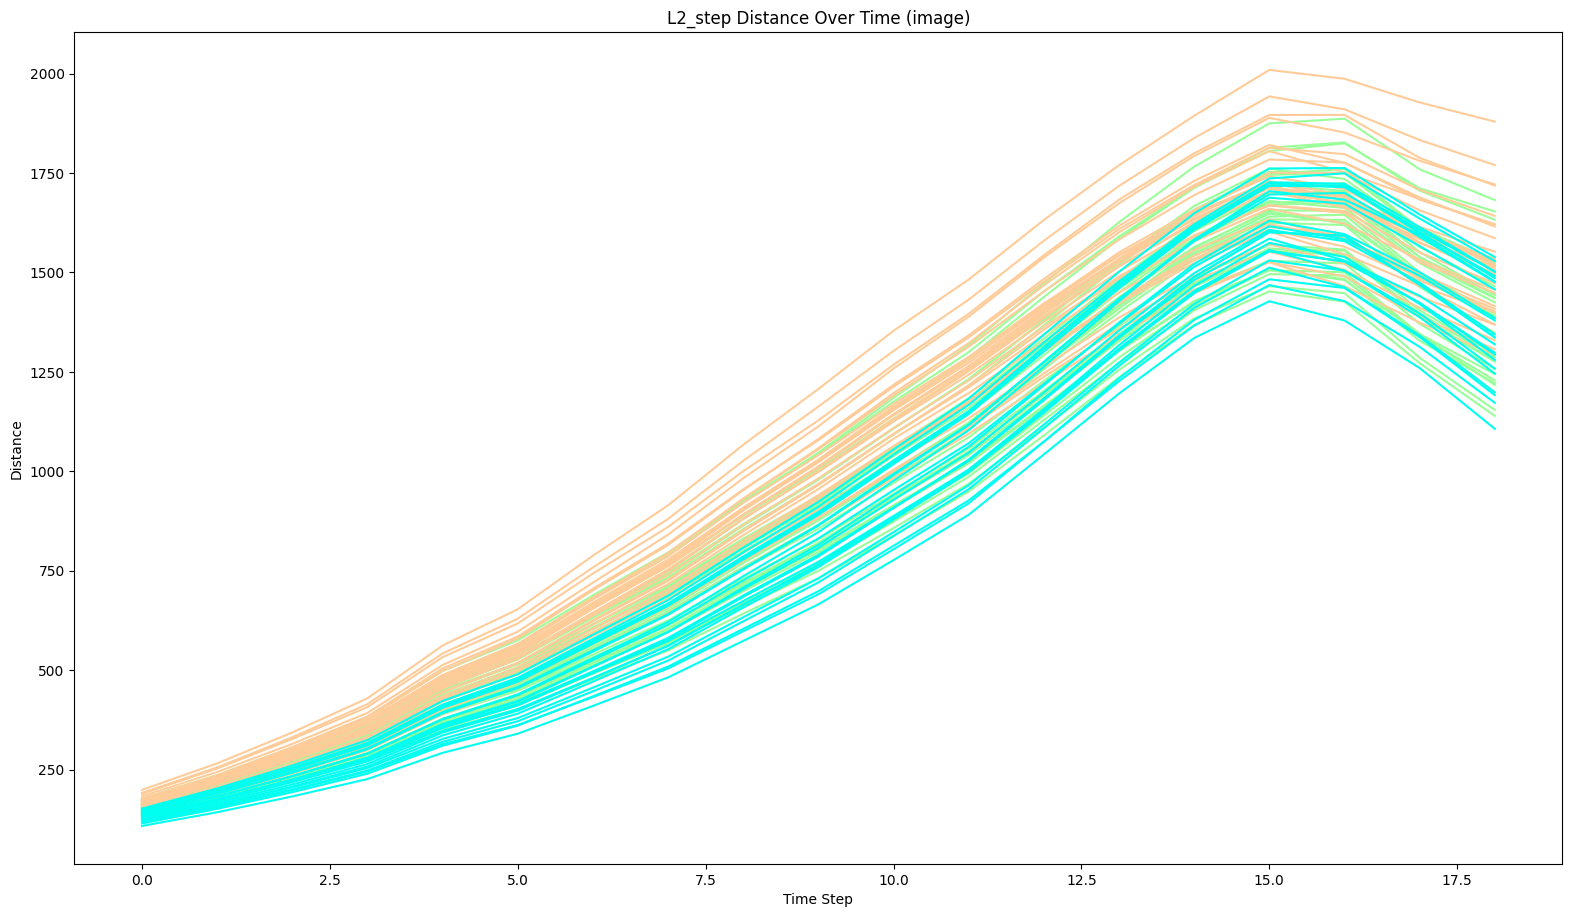

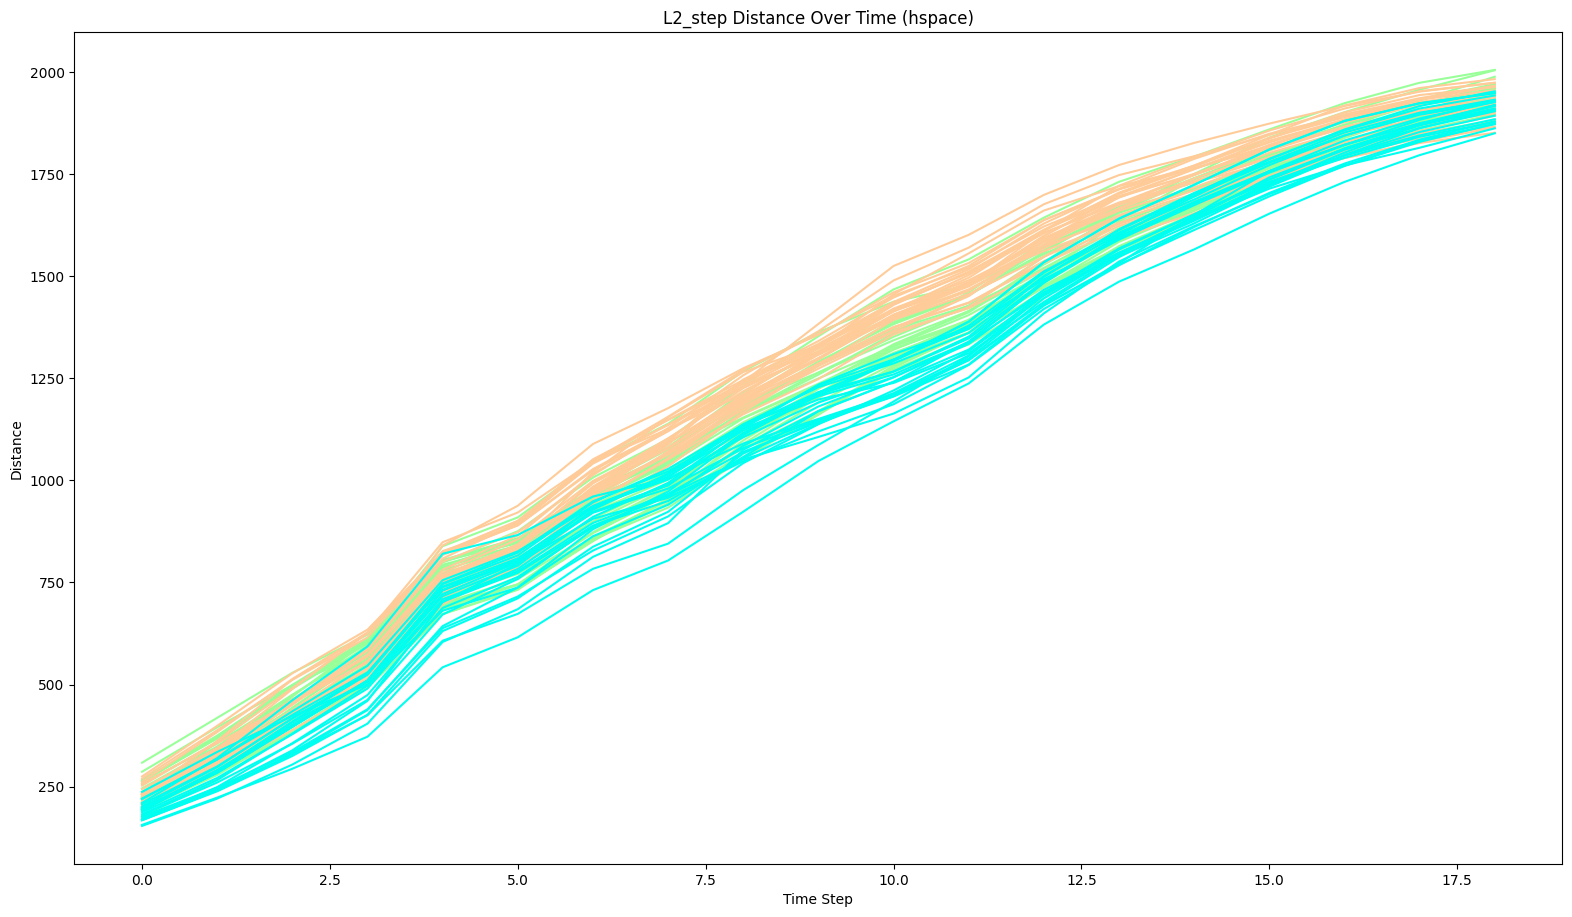

In [33]:
# Example usage
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'hspace', "L2_step")

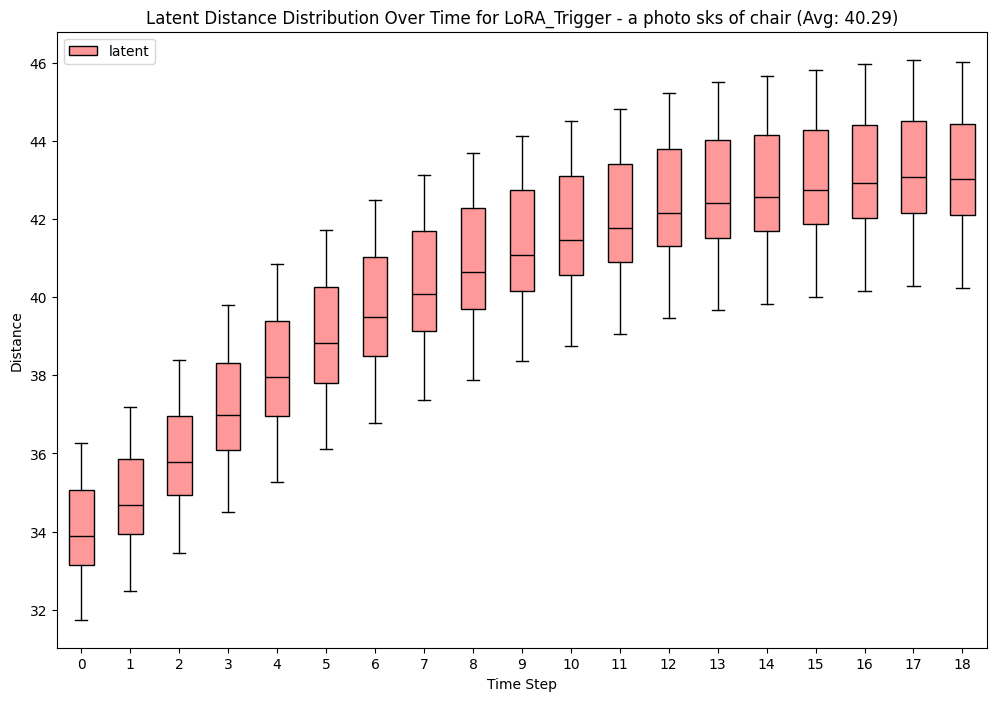

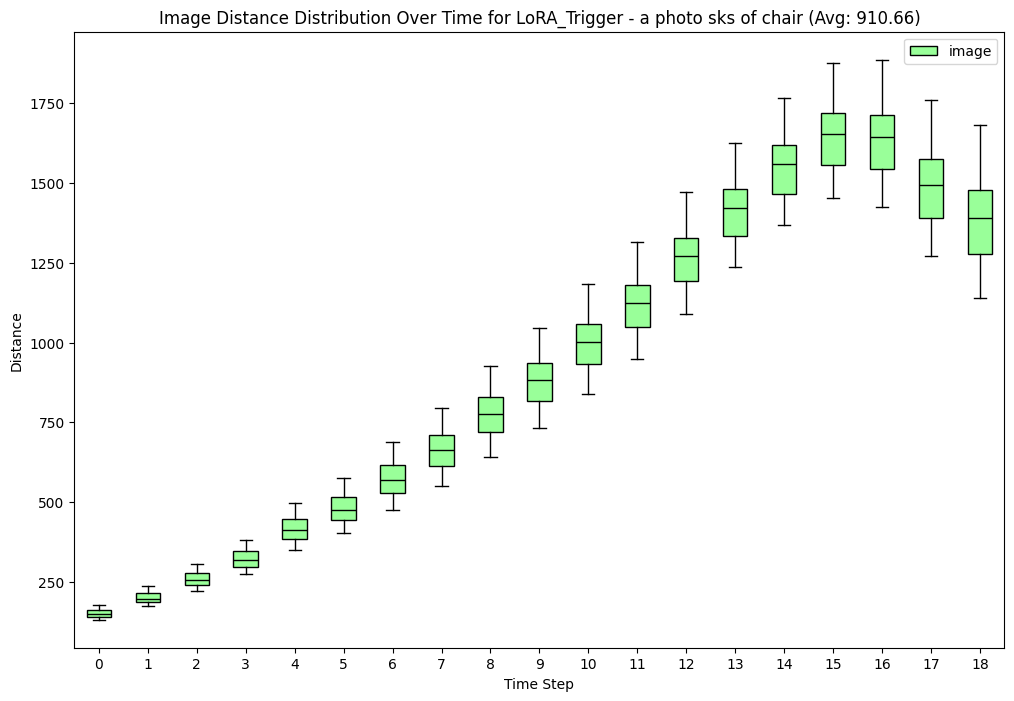

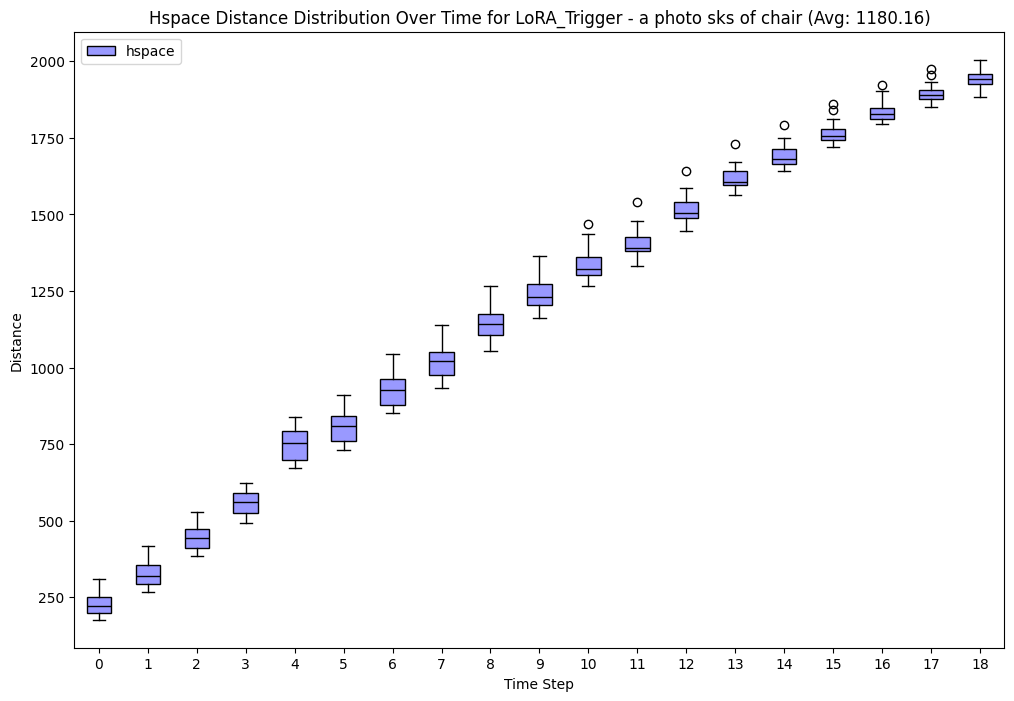

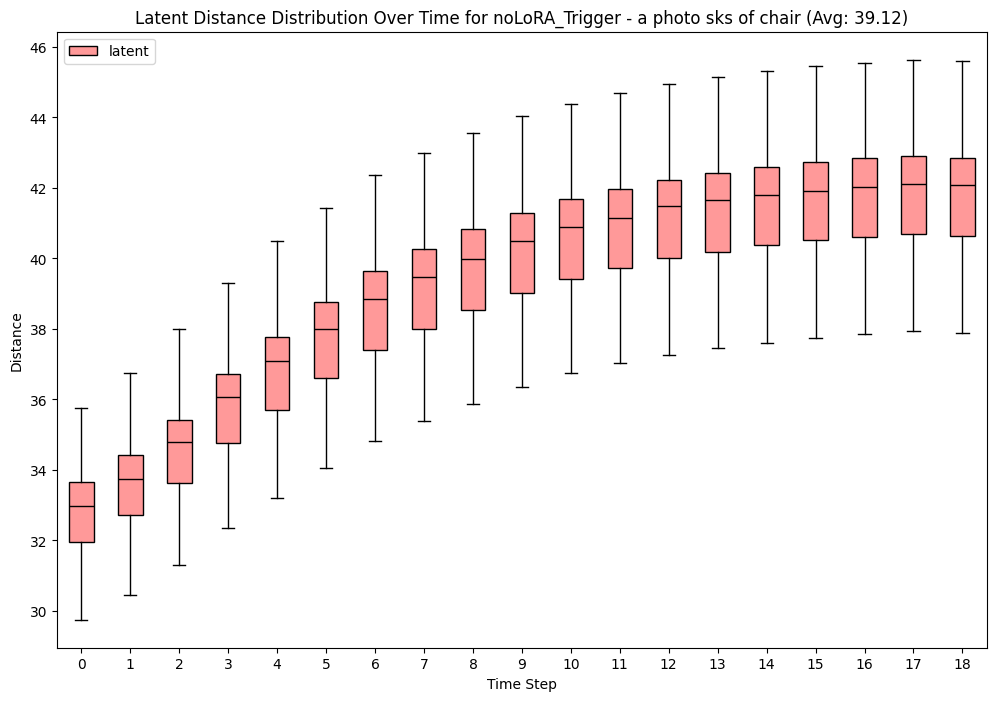

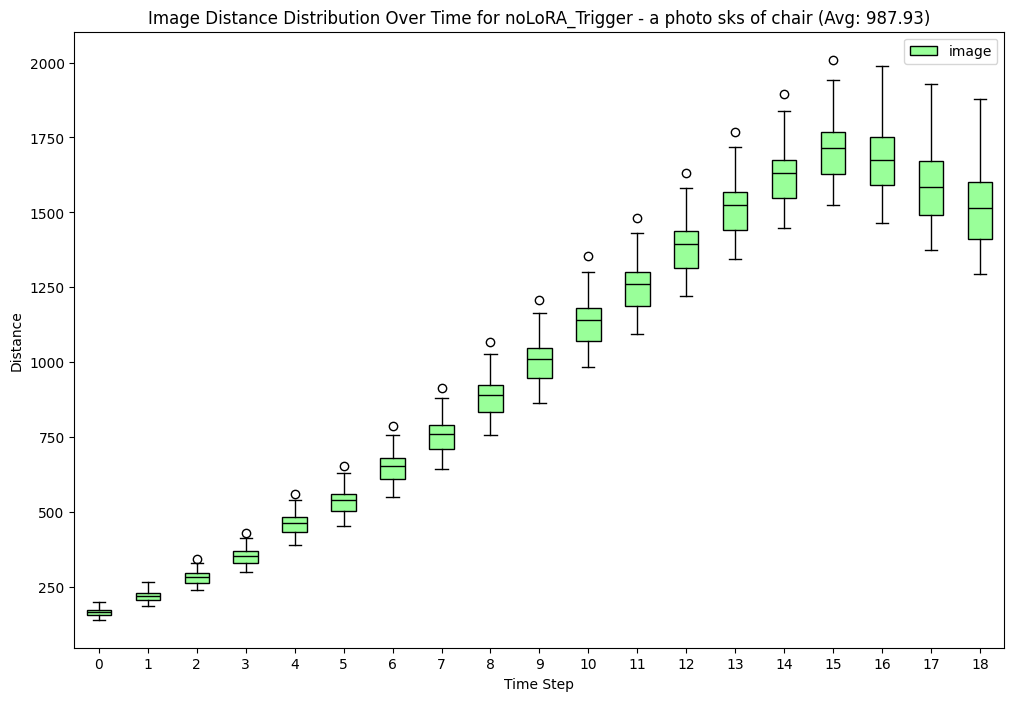

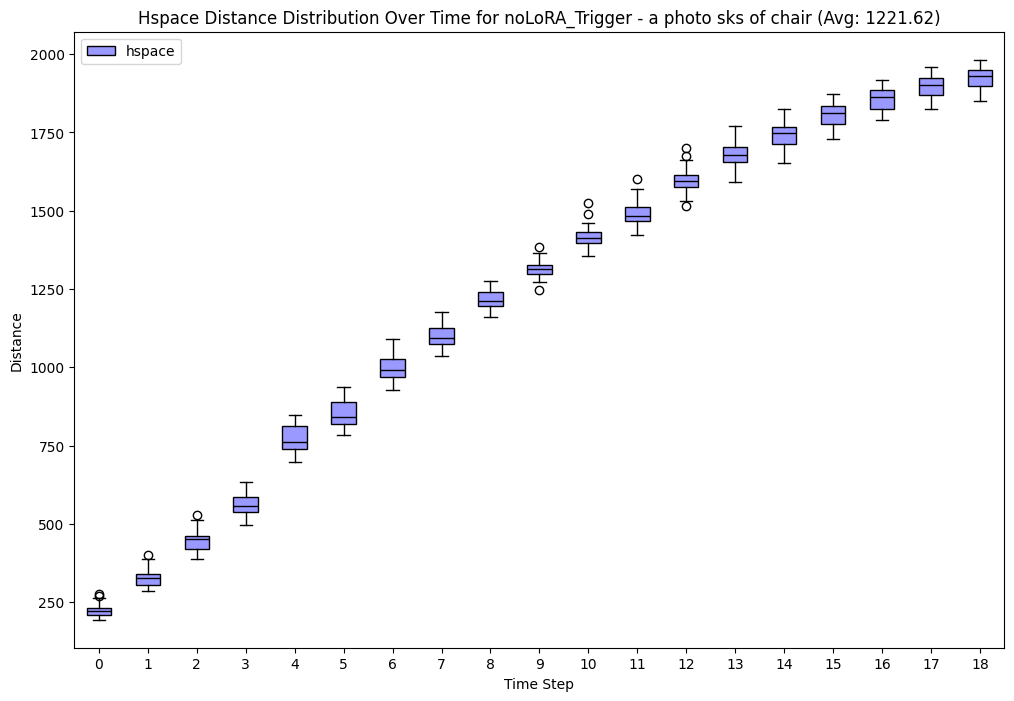

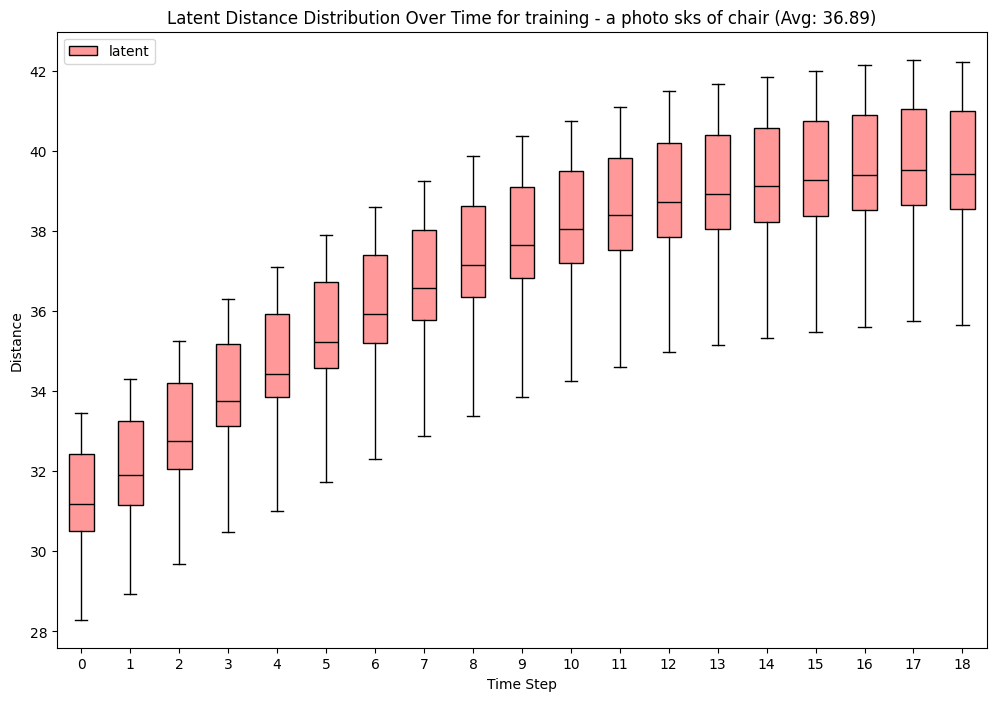

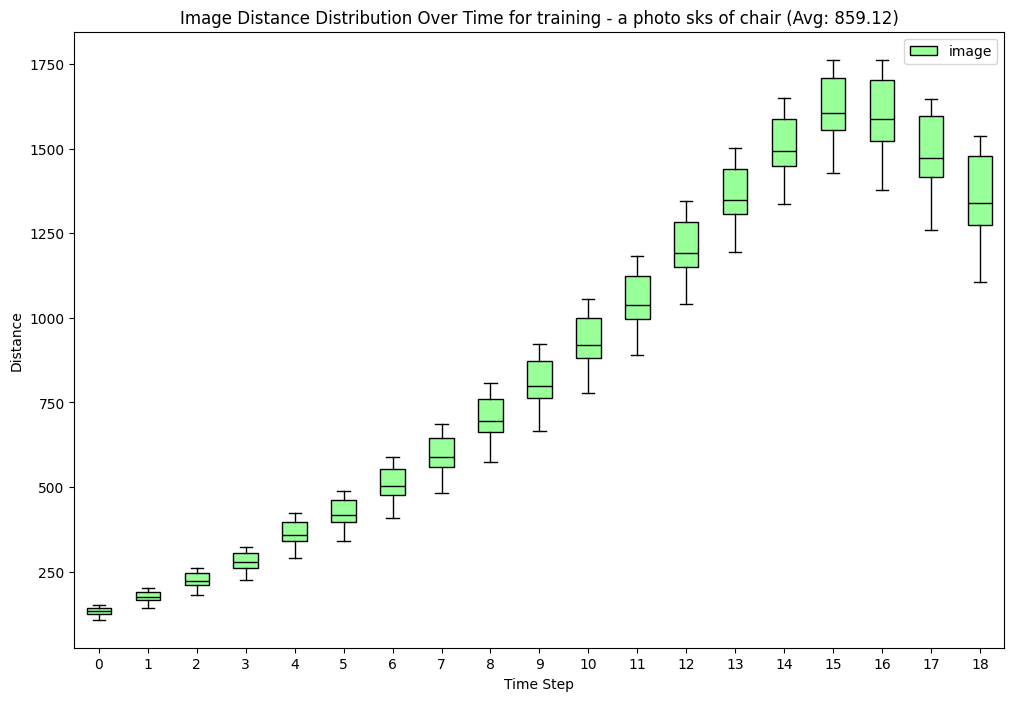

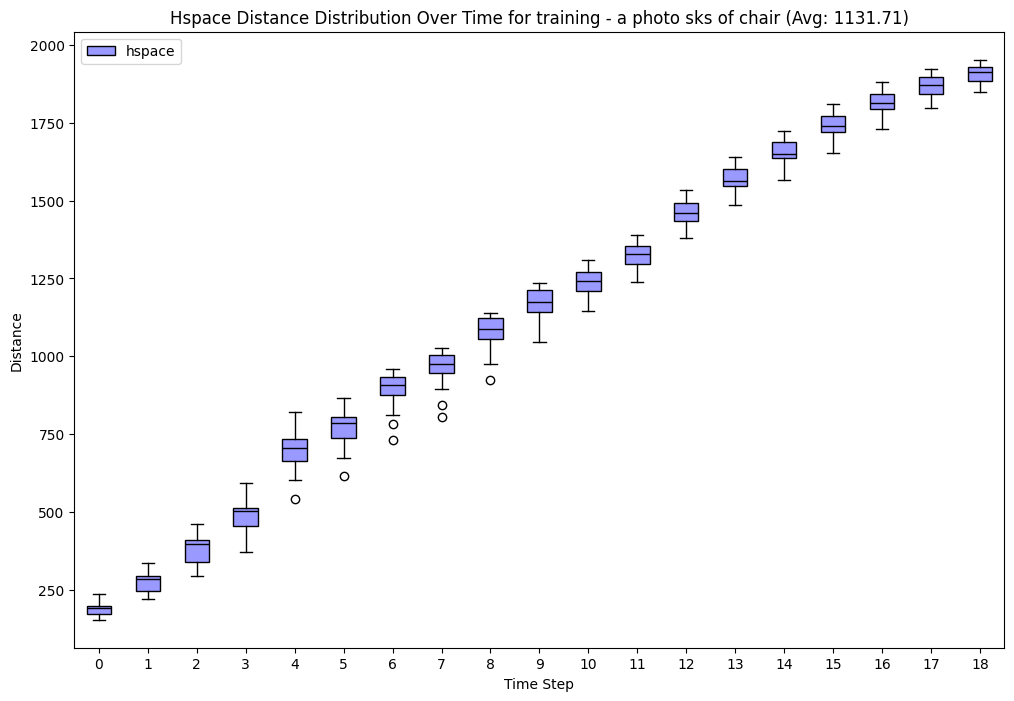

In [34]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    colors = {'latent': '#FF9999', 'image': '#99FF99', 'hspace': '#9999FF'}
    
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for key in ["latent", "image", "hspace"]:
                try:
                    # Collect all time series data
                    all_time_series = []
                    for image_name in analysis_data[prefix][prompt].keys():
                        data = analysis_data[prefix][prompt][image_name][key]
                        if isinstance(data, list) and len(data) > 0:
                            all_time_series.append(data)
                
                    if not all_time_series:
                        print(f"No data found for {prefix}/{prompt}/{key}")
                        continue
                    
                    # Determine number of time steps
                    num_times = len(all_time_series[0])
                    
                    # Reorganize data by time step
                    data_by_time = [[] for _ in range(num_times)]
                    for series in all_time_series:
                        for t, value in enumerate(series[:num_times]):
                            data_by_time[t].append(value)
                    
                    # Create plot
                    plt.figure(figsize=(12, 8))
                    box = plt.boxplot(data_by_time, patch_artist=True, 
                                    boxprops=dict(facecolor=colors[key]))
                    
                    # Calculate average and set properties
                    avg_distance = np.mean([np.mean(d) for d in data_by_time if d])
                    plt.ylabel('Distance')
                    plt.xlabel('Time Step')
                    plt.title(f'{key.capitalize()} Distance Distribution Over Time for {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                    plt.xticks(range(1, len(data_by_time) + 1), range(len(data_by_time)))
                    plt.legend([key])
                    
                    # Set median lines to black
                    for median in box['medians']:
                        median.set_color('black')
                    
                    plt.show()
                    
                except Exception as e:
                    print(f"Error plotting {prefix}/{prompt}/{key}: {e}")

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)


In [35]:
print('hello')

hello


In [36]:
experiment_data.keys()

dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])

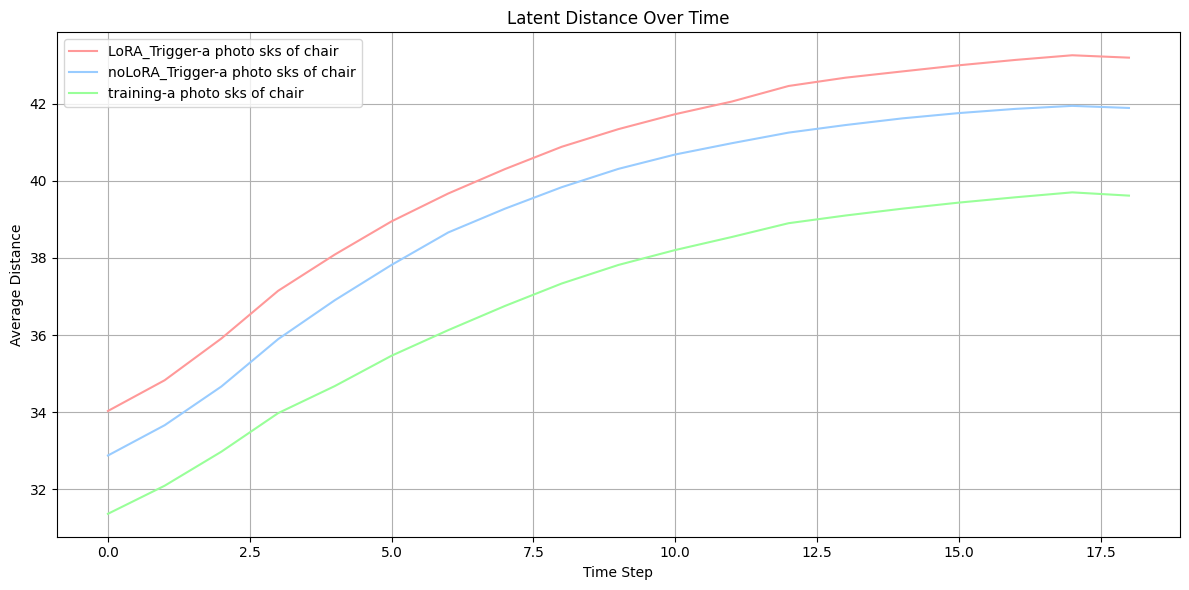

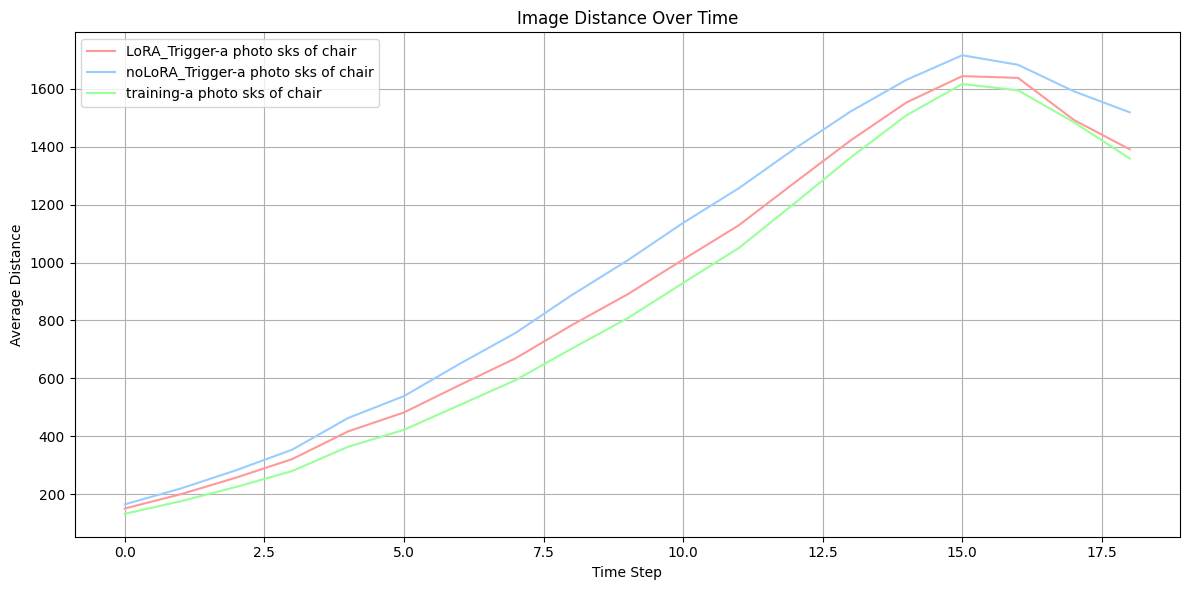

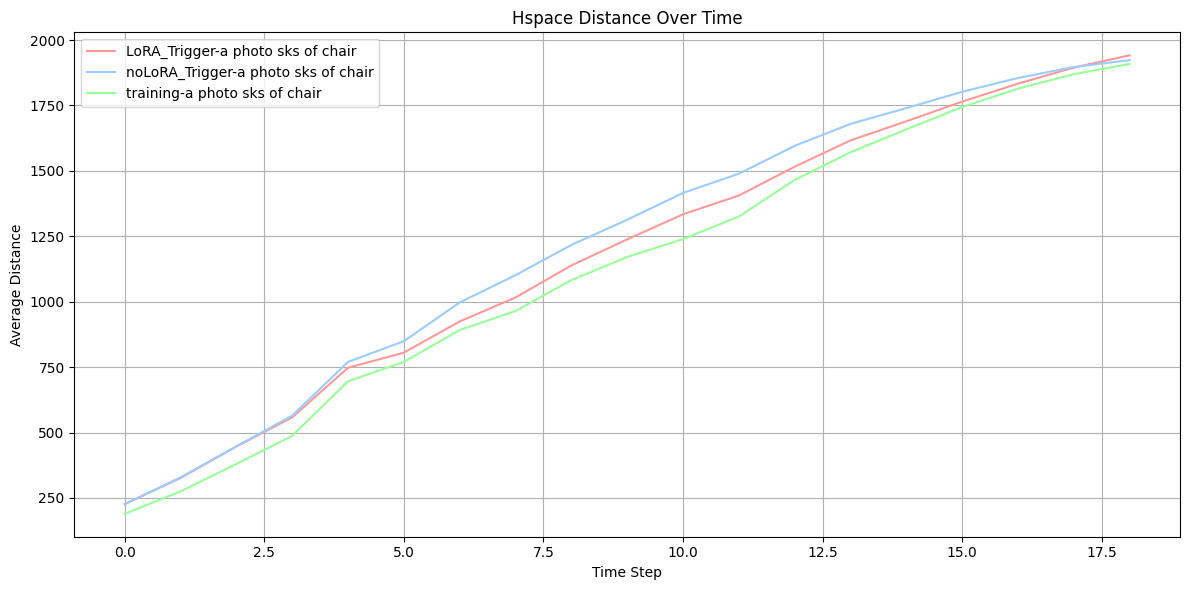

In [37]:
import matplotlib.pyplot as plt
import numpy as np


def plot_lineplot_by_key(analysis_data):
    colors = ['#FF9999', '#99CCFF', '#99FF99', '#FFCC99', '#CC99FF', '#FFFF99']
    keys = ['latent', 'image', 'hspace']

    for key in keys:
        plt.figure(figsize=(12, 6))
        for i, prefix in enumerate(analysis_data):
            for prompt in analysis_data[prefix]:
                # 初始化時間序列
                time_series = []

                for t in range(1000):  # 預設最大 1000 步，實際會 break
                    values_at_t = []
                    for image_name in analysis_data[prefix][prompt]:
                        values = analysis_data[prefix][prompt][image_name].get(key, [])
                        if t < len(values):
                            values_at_t.append(values[t])
                    if not values_at_t:
                        break
                    time_series.append(np.mean(values_at_t))

                if time_series:
                    plt.plot(range(len(time_series)), time_series, label=f'{prefix}-{prompt}', color=colors[i % len(colors)])

        plt.title(f'{key.capitalize()} Distance Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Average Distance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
plot_lineplot_by_key(l2_analysis_data)


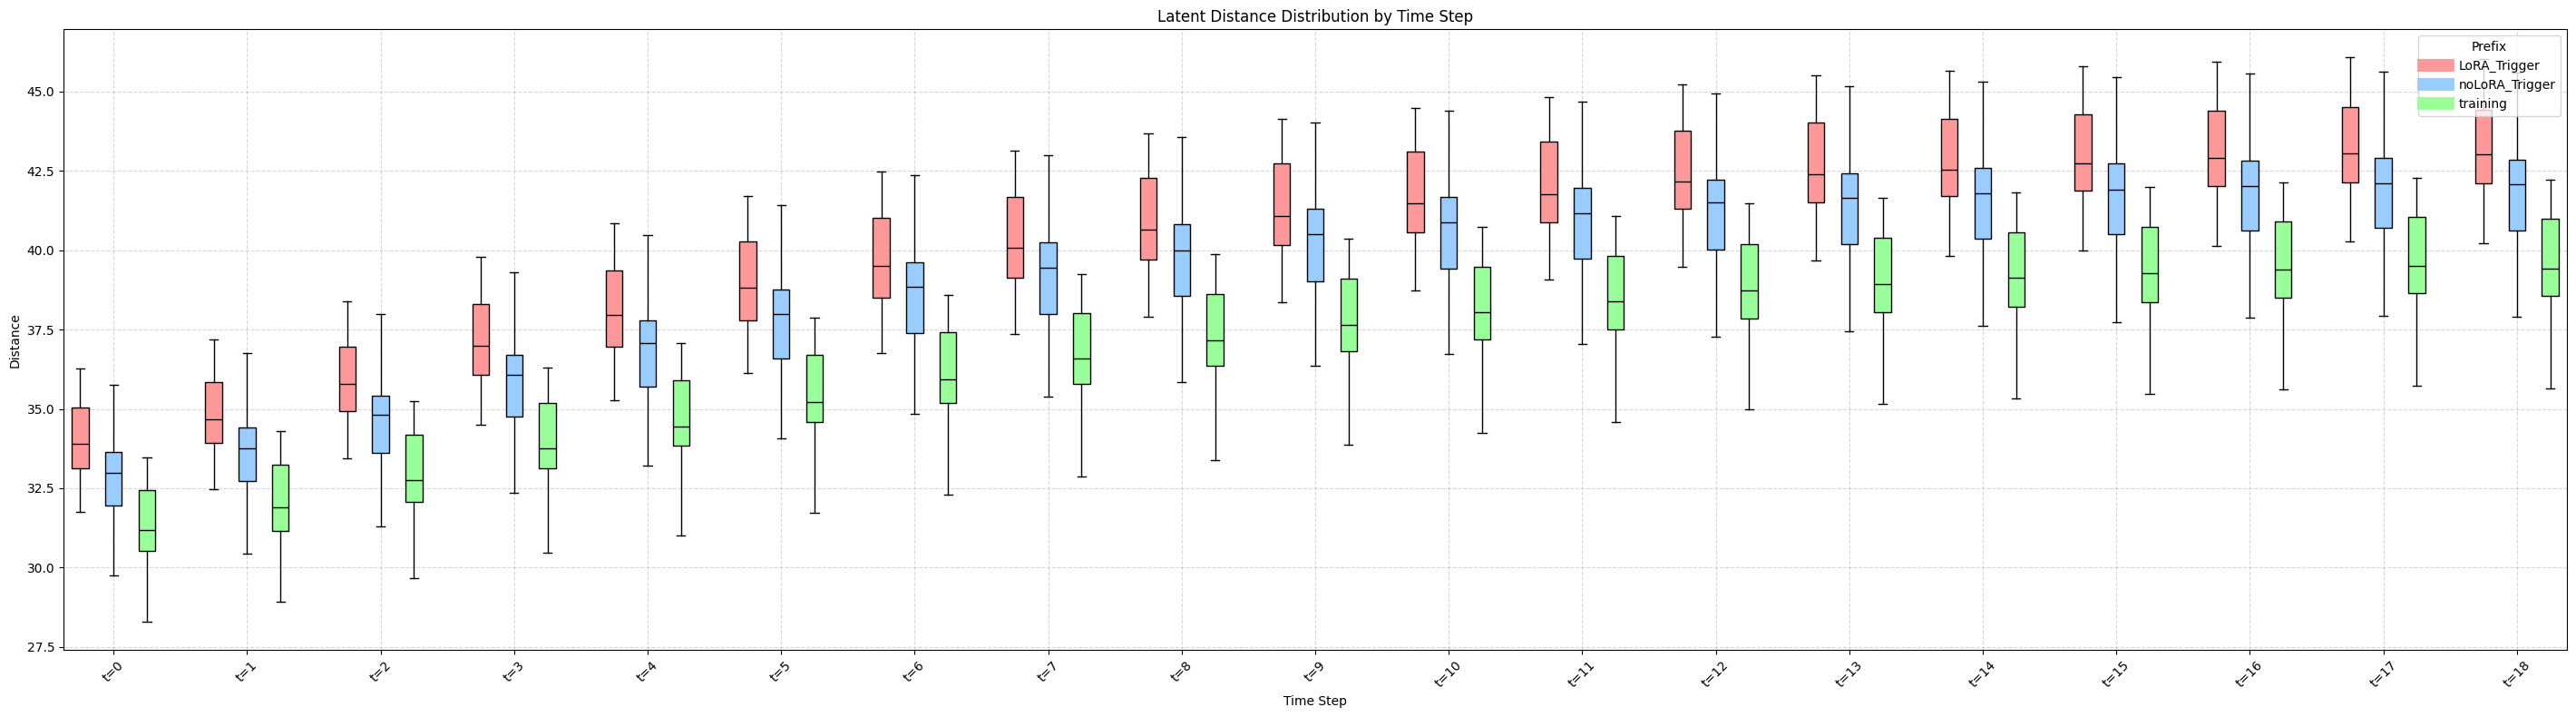

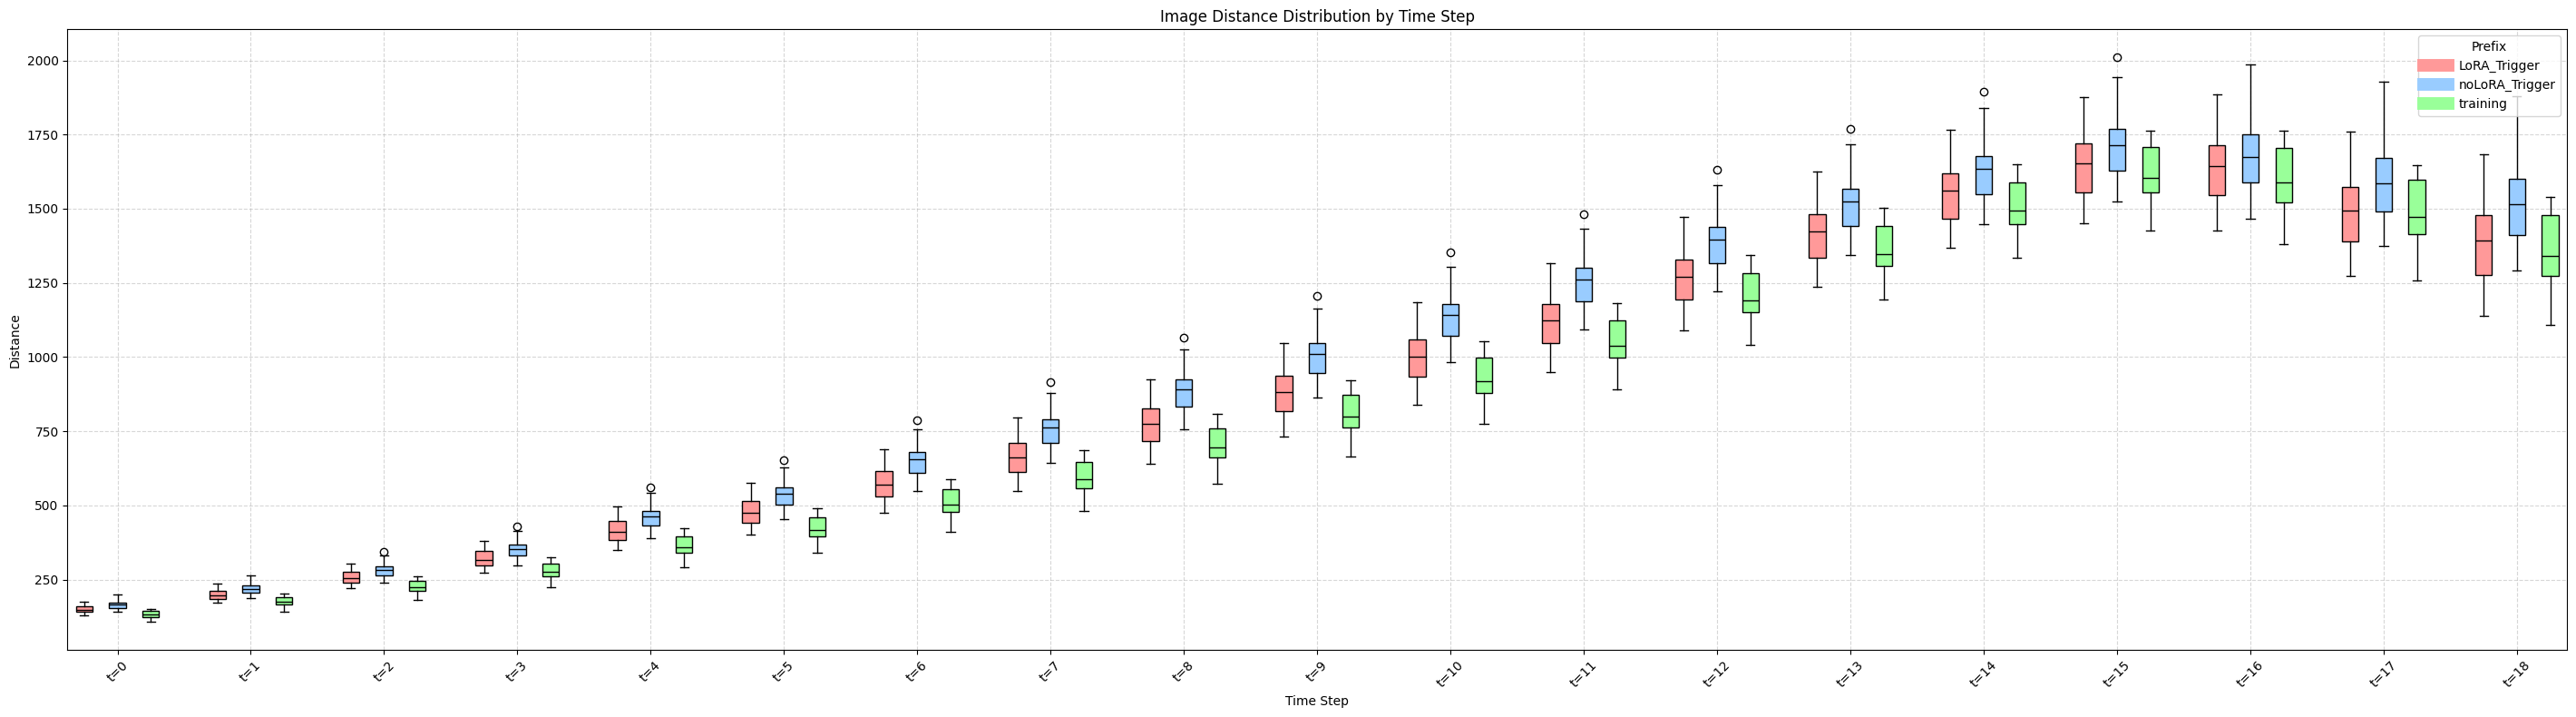

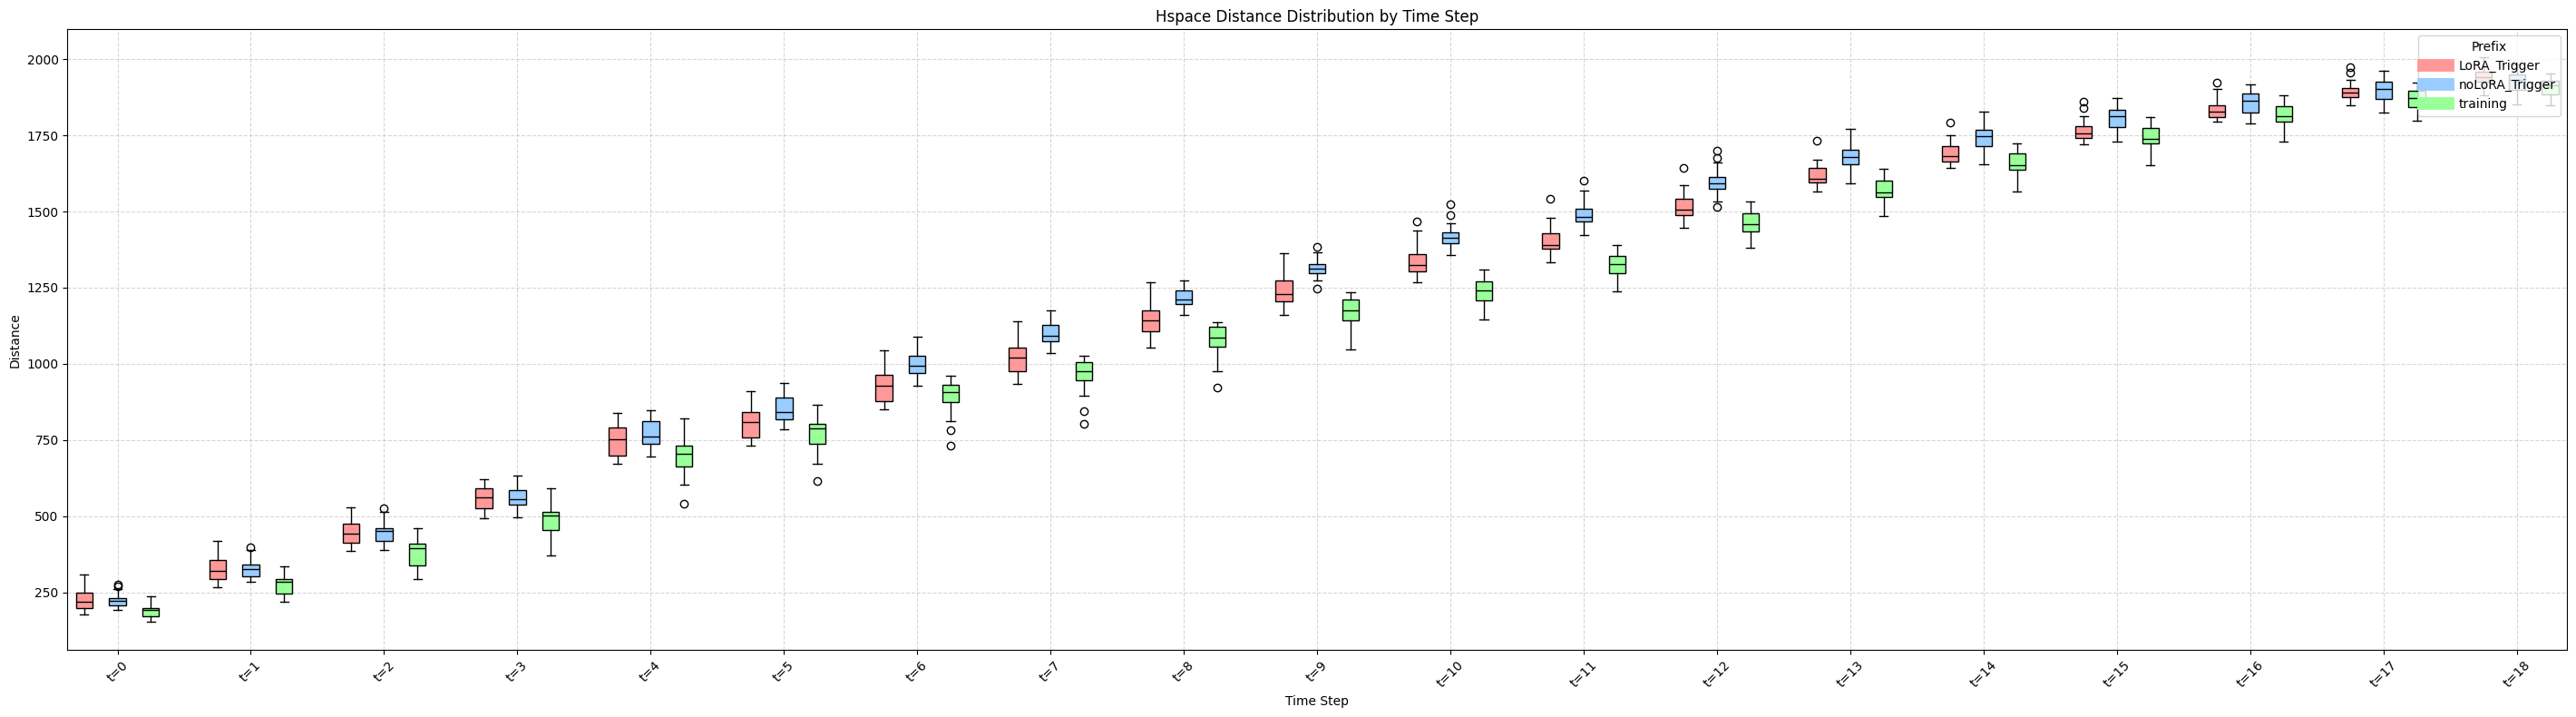

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_key_boxplots_by_prefix(analysis_data):
    keys = ['latent', 'image', 'hspace']
    color_palette = ['#FF9999', '#99CCFF', '#99FF99', '#FFCC99', '#CC99FF', '#FFFF99', '#FFB6C1', '#87CEFA']
    prefix_colors = {}

    for key in keys:
        # 準備每個 prefix 對應的時間步資料
        prefix_time_data = {}
        max_timesteps = 0

        for prefix_idx, prefix in enumerate(analysis_data):
            prefix_colors[prefix] = color_palette[prefix_idx % len(color_palette)]
            for prompt in analysis_data[prefix]:
                for image_name in analysis_data[prefix][prompt]:
                    data = analysis_data[prefix][prompt][image_name].get(key, [])
                    if len(data) == 0:
                        continue
                    if prefix not in prefix_time_data:
                        prefix_time_data[prefix] = [[] for _ in range(len(data))]
                    while len(prefix_time_data[prefix]) < len(data):
                        prefix_time_data[prefix].append([])  # 填充空陣列
                    for t, v in enumerate(data):
                        prefix_time_data[prefix][t].append(v)
                    max_timesteps = max(max_timesteps, len(data))

        if not prefix_time_data:
            print(f"No data found for key: {key}")
            continue

        # 畫圖：每個時間步，對應多個 prefix 的 boxplot
        plt.figure(figsize=(max(12, max_timesteps * 1.5), 8))
        positions = []
        data = []
        colors = []
        ticks = []

        for t in range(max_timesteps):
            for i, prefix in enumerate(prefix_time_data):
                if t < len(prefix_time_data[prefix]):
                    values = prefix_time_data[prefix][t]
                    if len(values) > 0:
                        data.append(values)
                        position = t * (len(prefix_time_data) + 1) + i
                        positions.append(position)
                        colors.append(prefix_colors[prefix])

            # 設定 xtick label 在每組中間
            ticks.append(t * (len(prefix_time_data) + 1) + len(prefix_time_data) // 2)

        box = plt.boxplot(data, positions=positions, patch_artist=True)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        for median in box['medians']:
            median.set_color('black')

        plt.xticks(ticks, [f"t={i}" for i in range(max_timesteps)], rotation=45)
        plt.title(f"{key.capitalize()} Distance Distribution by Time Step")
        plt.xlabel("Time Step")
        plt.ylabel("Distance")
        plt.legend(
            [plt.Line2D([0], [0], color=prefix_colors[p], lw=10) for p in prefix_time_data],
            [p for p in prefix_time_data],
            title="Prefix",
            loc="upper right"
        )
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
plot_key_boxplots_by_prefix(l2_analysis_data)


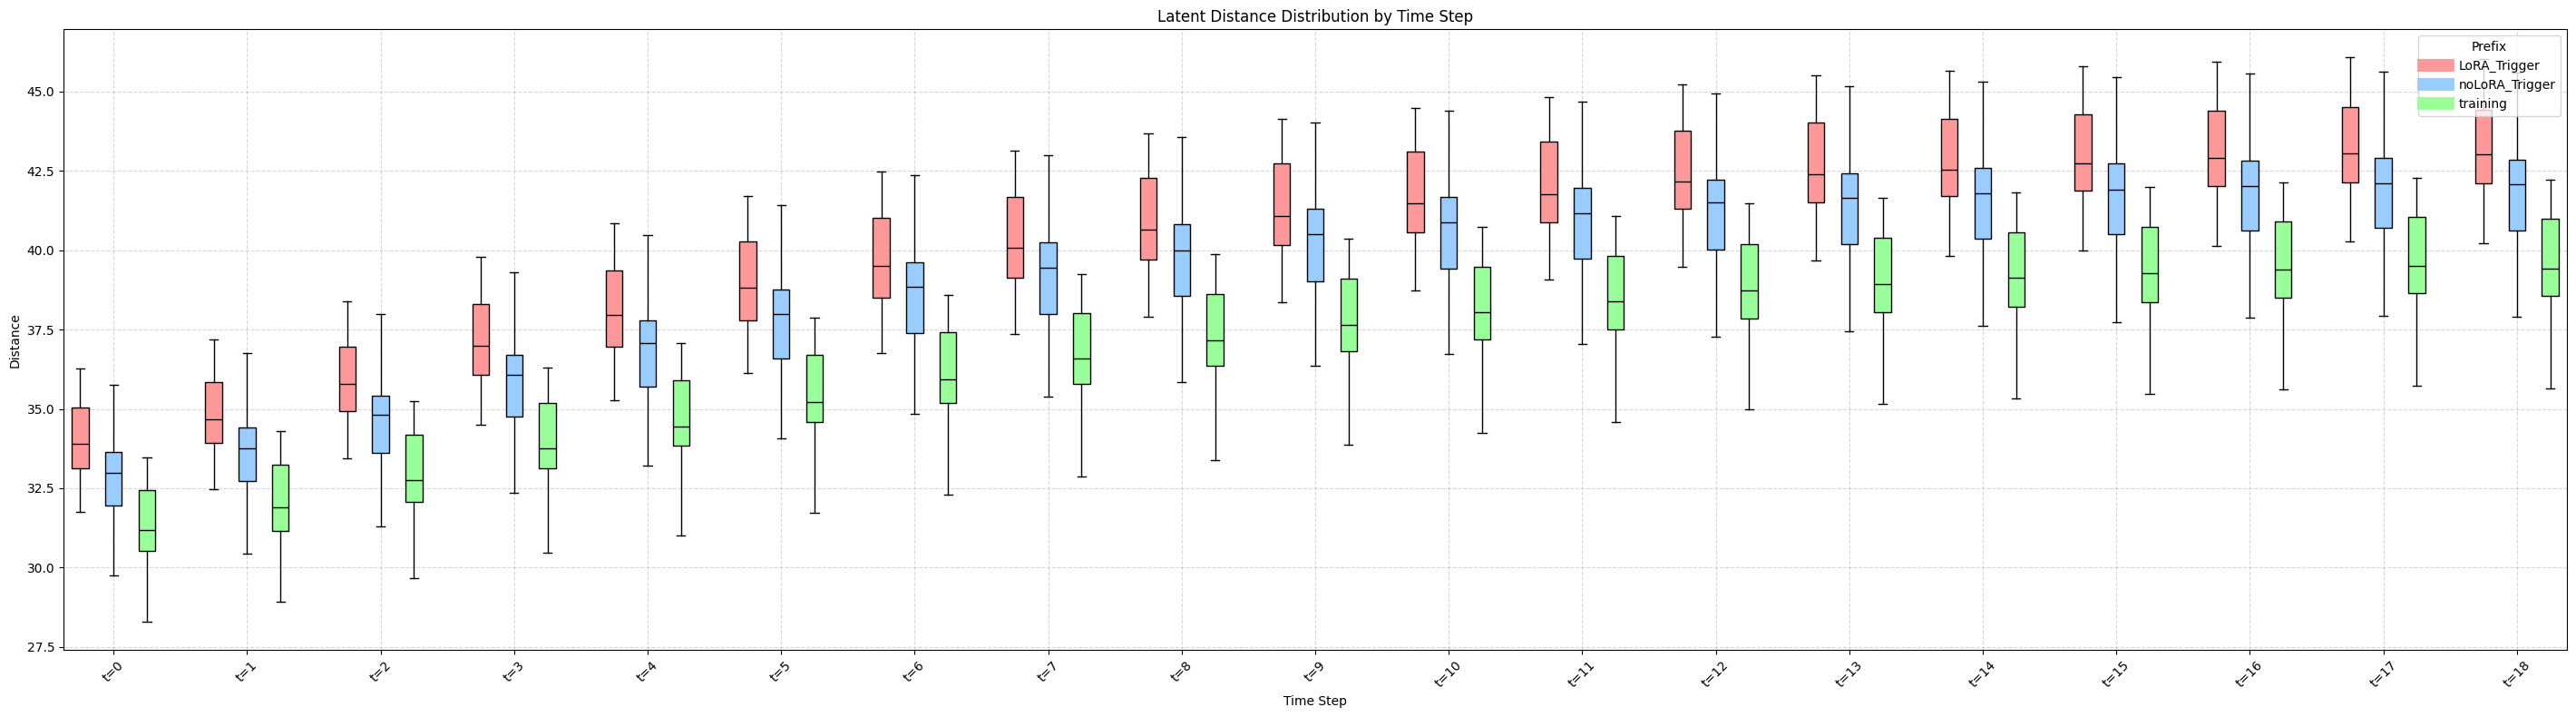


Average distances for key: latent
- LoRA_Trigger: 40.2857
- noLoRA_Trigger: 39.1206
- training: 36.8911


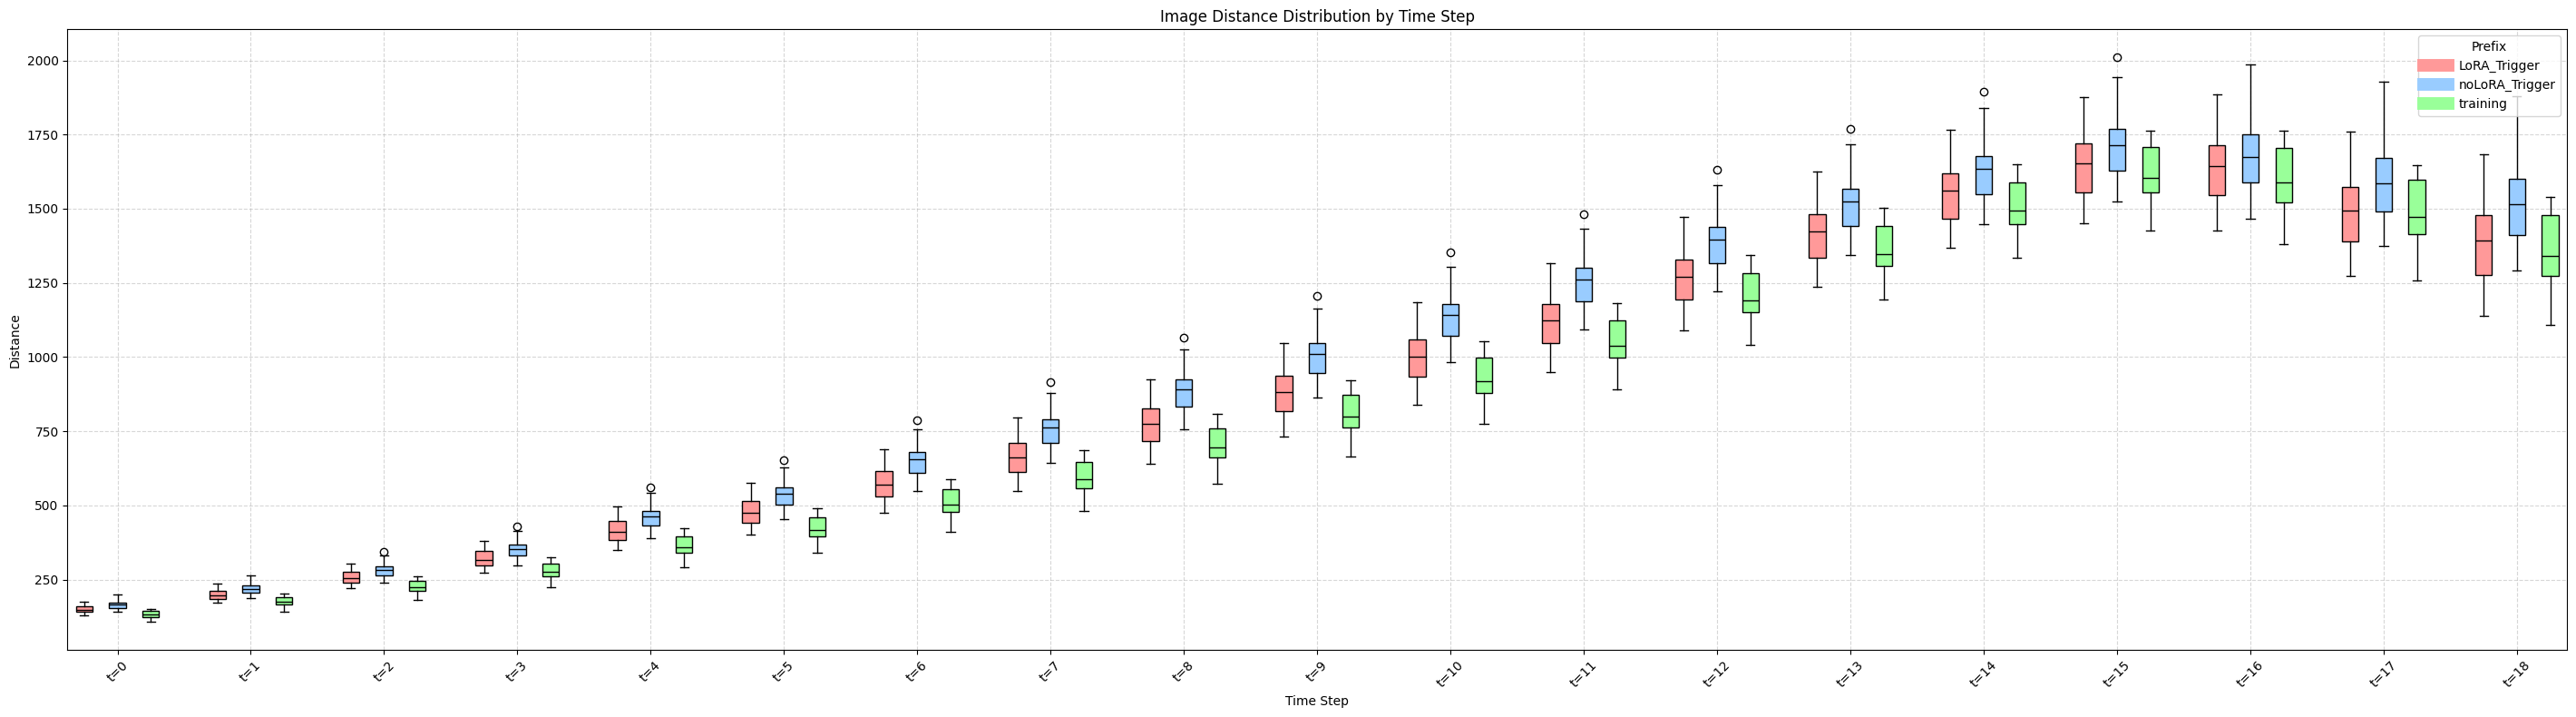


Average distances for key: image
- LoRA_Trigger: 910.6576
- noLoRA_Trigger: 987.9350
- training: 859.1228


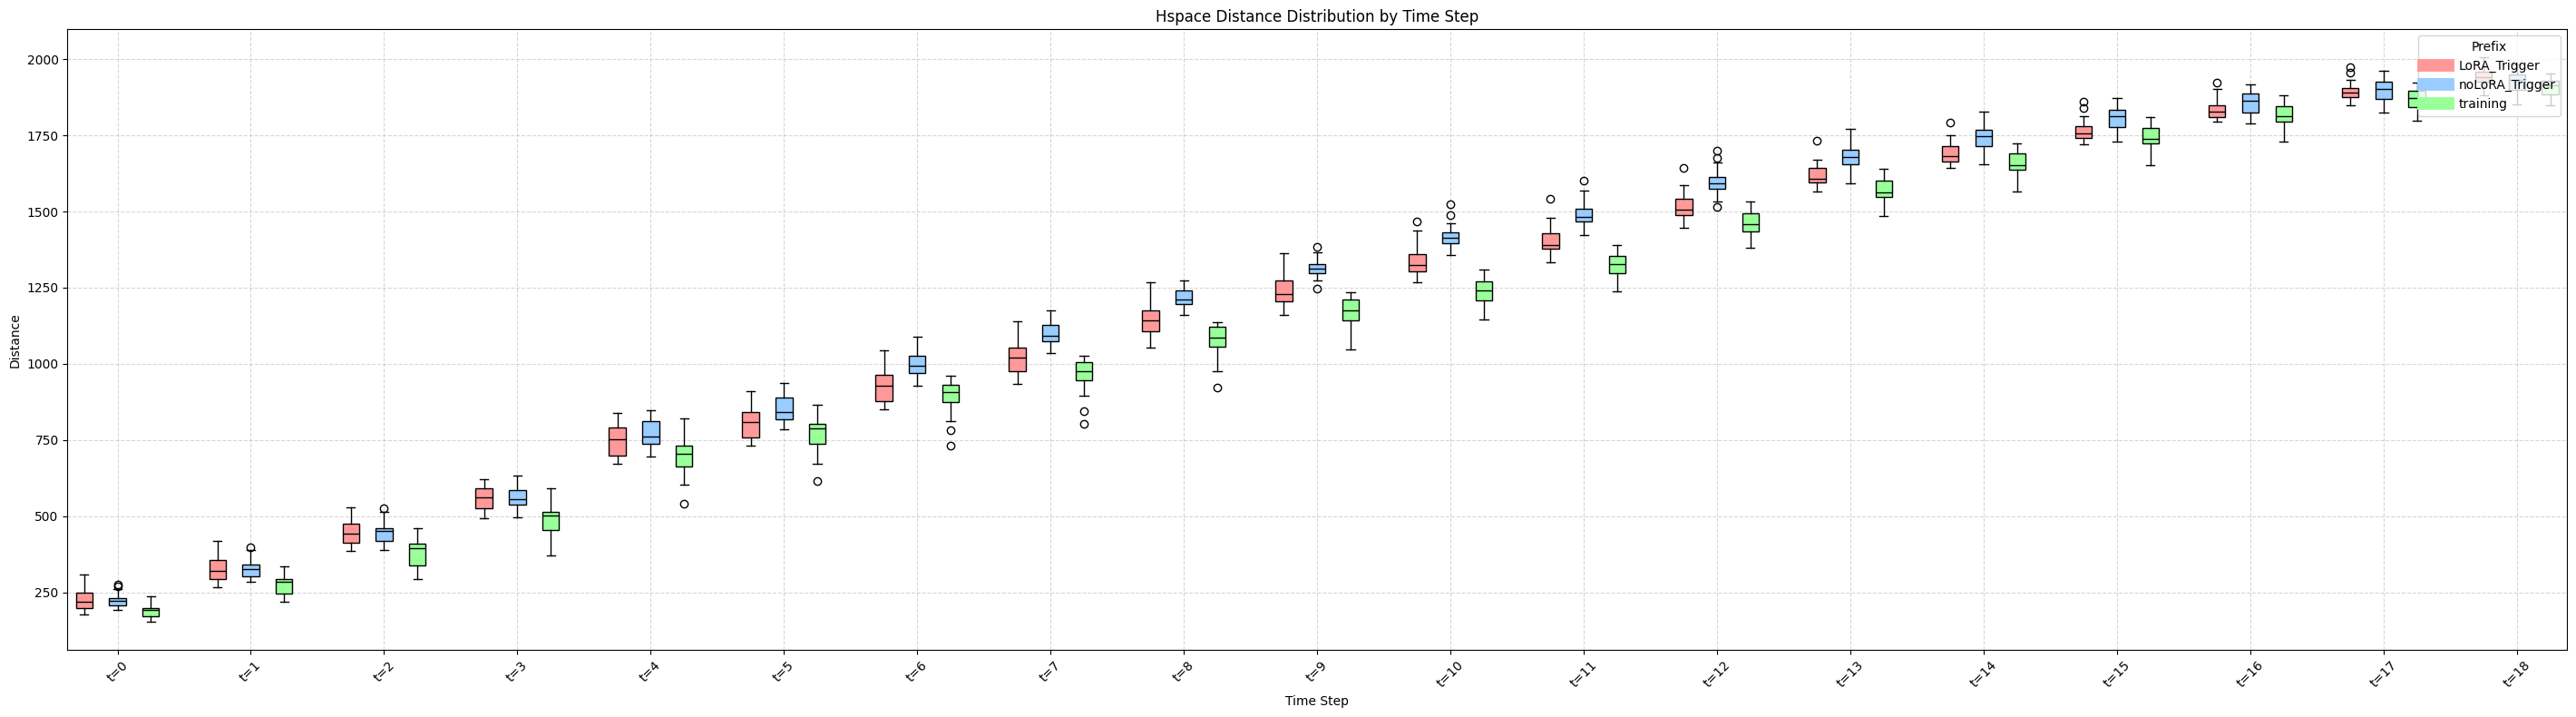


Average distances for key: hspace
- LoRA_Trigger: 1180.1593
- noLoRA_Trigger: 1221.6194
- training: 1131.7125


In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_key_boxplots_by_prefix(analysis_data):
    keys = ['latent', 'image', 'hspace']
    color_palette = ['#FF9999', '#99CCFF', '#99FF99', '#FFCC99', '#CC99FF', '#FFFF99', '#FFB6C1', '#87CEFA']
    prefix_colors = {}

    for key in keys:
        prefix_time_data = {}
        max_timesteps = 0

        for prefix_idx, prefix in enumerate(analysis_data):
            prefix_colors[prefix] = color_palette[prefix_idx % len(color_palette)]
            for prompt in analysis_data[prefix]:
                for image_name in analysis_data[prefix][prompt]:
                    data = analysis_data[prefix][prompt][image_name].get(key, [])
                    if len(data) == 0:
                        continue
                    if prefix not in prefix_time_data:
                        prefix_time_data[prefix] = [[] for _ in range(len(data))]
                    while len(prefix_time_data[prefix]) < len(data):
                        prefix_time_data[prefix].append([])  # 補空
                    for t, v in enumerate(data):
                        prefix_time_data[prefix][t].append(v)
                    max_timesteps = max(max_timesteps, len(data))

        if not prefix_time_data:
            print(f"No data found for key: {key}")
            continue

        # 畫圖
        plt.figure(figsize=(max(12, max_timesteps * 1.5), 8))
        positions = []
        data = []
        colors = []
        ticks = []

        for t in range(max_timesteps):
            for i, prefix in enumerate(prefix_time_data):
                if t < len(prefix_time_data[prefix]):
                    values = prefix_time_data[prefix][t]
                    if len(values) > 0:
                        data.append(values)
                        position = t * (len(prefix_time_data) + 1) + i
                        positions.append(position)
                        colors.append(prefix_colors[prefix])
            ticks.append(t * (len(prefix_time_data) + 1) + len(prefix_time_data) // 2)

        box = plt.boxplot(data, positions=positions, patch_artist=True)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        for median in box['medians']:
            median.set_color('black')

        plt.xticks(ticks, [f"t={i}" for i in range(max_timesteps)], rotation=45)
        plt.title(f"{key.capitalize()} Distance Distribution by Time Step")
        plt.xlabel("Time Step")
        plt.ylabel("Distance")
        plt.legend(
            [plt.Line2D([0], [0], color=prefix_colors[p], lw=10) for p in prefix_time_data],
            [p for p in prefix_time_data],
            title="Prefix",
            loc="upper right"
        )
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # === 新增：平均值輸出 ===
        print(f"\nAverage distances for key: {key}")
        for prefix in prefix_time_data:
            all_values = []
            for t_values in prefix_time_data[prefix]:
                all_values.extend(t_values)
            if all_values:
                avg = np.mean(all_values)
                print(f"- {prefix}: {avg:.4f}")
            else:
                print(f"- {prefix}: no data")
plot_key_boxplots_by_prefix(l2_analysis_data)


In [40]:
def calculate_variance(experiment_data):
    variance_data = {}
    for prefix in experiment_data.keys():
        variance_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            variance_data[prefix][prompt] = {}
            for key in ["latent", "image", "hspace"]:
                all_timesteps = []
                for image_name in experiment_data[prefix][prompt].keys():
                    data = experiment_data[prefix][prompt][image_name][key]
                    if data.size > 0:
                        all_timesteps.append(data)
                if all_timesteps:
                    stacked_data = np.stack(all_timesteps, axis=0)
                    variance_data[prefix][prompt][key] = np.var(stacked_data, axis=0)
                else:
                    variance_data[prefix][prompt][key] = None
    return variance_data

# Example usage
variance_data = calculate_variance(experiment_data)
print(variance_data)

{'LoRA_Trigger': {'a photo sks of chair': {'latent': array([[[[[0.02065221, 0.02407414, 0.0292221 , ..., 0.02476885,
           0.02279685, 0.01487851],
          [0.02134799, 0.02426932, 0.02375628, ..., 0.02153555,
           0.01884538, 0.02006867],
          [0.01996369, 0.02131515, 0.02460208, ..., 0.01988792,
           0.02148384, 0.01428567],
          ...,
          [0.00672364, 0.00778729, 0.00956574, ..., 0.00752131,
           0.00843545, 0.00910515],
          [0.00879321, 0.00668393, 0.00607013, ..., 0.01044773,
           0.00755231, 0.00812087],
          [0.00521965, 0.00525036, 0.00500049, ..., 0.00702963,
           0.00625199, 0.00740221]],

         [[0.00360792, 0.00433708, 0.00718517, ..., 0.00441864,
           0.0053691 , 0.0051234 ],
          [0.00806939, 0.01134578, 0.01022213, ..., 0.00544309,
           0.01259127, 0.00995555],
          [0.00921889, 0.01433399, 0.00946581, ..., 0.01242525,
           0.00948501, 0.00837625],
          ...,
          [0.00

In [41]:
print(variance_data.keys())
print(variance_data['LoRA_Trigger'].keys())
print(variance_data['LoRA_Trigger'][config.short_object_prompt].keys())
print(variance_data['LoRA_Trigger'][config.short_object_prompt]['latent'].shape)

dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])
dict_keys(['a photo sks of chair'])
dict_keys(['latent', 'image', 'hspace'])
(19, 1, 4, 128, 128)
